# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
import xgboost as xgb
import random
import warnings
import pickle
from tabulate import tabulate
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from scipy import stats as ss
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from boruta import BorutaPy
from flask import Flask, request, Response
from platform import python_version
print(python_version())

3.8.11


## 0.1 Helper Funcions

In [36]:
def mean_absolute_percentage_error(y, yhat):
    Y = pd.DataFrame([y]).T.copy()
    Y.columns = ['sales']
    P = pd.DataFrame([yhat]).T.copy().rename(columns={0:'prediction'})
    T = pd.concat([Y, P], axis=1)
    T['diff'] = abs(T['sales'] - T['prediction'])
    T['div'] = T['sales'].apply(lambda x: 1 if x == 0 else x)
    T['mape_p'] = T['diff']/T['div']
    mape = T['mape_p'].sum()/T.shape[0]
    return mape

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

def ml_error(model_name, y, yhat):
    Y = pd.DataFrame([y]).T.copy()
    Y.columns = ['sales']
    P = pd.DataFrame([yhat]).T.copy().rename(columns={0:'prediction'})
    T = pd.concat([Y, P], axis=1)
    T['diff'] = abs(T['sales'] - T['prediction'])
    T['div'] = T['sales'].apply(lambda x: 1 if x == 0 else x)
    T['mape_p'] = T['diff']/T['div']
    mape = T['mape_p'].sum()/T.shape[0]
    
    mae = mean_absolute_error(y, yhat)
    #mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': round(mae,2),
                        'MAPE': round(mape,2),
                        'RMSE': round(rmse,2),
                        'R2' : round(r2,4)
                        }, index=[0])

def ml_error_(y_test, yhat_test, y_train, yhat_train):
    rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
    r2_test = r2_score(y_test, yhat_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
    r2_train = r2_score(y_train, yhat_train)
    
    return pd.DataFrame({
                        'R2_TRAIN' : round(r2_train,4),
                        'R2_TEST' : round(r2_test,4),
                        'RMSE_TRAIN': round(rmse_train,2),
                        'RMSE_TEST': round(rmse_test,2)
                        }, index=[0])

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values #no curso ele usa a função .as_matrix() que foi descontinuada.
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr =  max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (k-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
#0 a 1 - Quanto mais perto do 0 menor a correlação / 1 maior a correlação

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width:100 !import;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

jupyter_settings()

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    r2_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\n KFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales'].values

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        r2_list.append(m_result['R2'])

    return pd.DataFrame({'Model Name': model_name, 
                         'MAE CV': np.round(np.mean(mae_list), 2).astype('str') + '+/-' + np.round(np.std(mae_list), 2).astype('str'),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype('str') + '+/-' + np.round(np.std(mape_list), 2).astype('str'),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype('str') + '+/-' + np.round(np.std(rmse_list), 2).astype('str'),
                         'R2 CV': np.round(np.mean(r2_list), 2).astype('str') + '+/-' + np.round(np.std(r2_list), 2).astype('str')},
                      index=[0])

def res_plot(y_test, yhat):
    res = pd.DataFrame(np.expm1(y_test))
    res['y_hat'] = np.expm1(yhat)
    res['residual'] = res['sales'] - res['y_hat']
    return sns.scatterplot(data=res, x='y_hat', y='residual')

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

### 0.2.1 ANALYSING DF_STORE

In [5]:
store_raw = pd.read_csv('dataset/store.csv', low_memory=False)
store_raw.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
0      1         c          a               1270.0                        9.0                    2008.0       0              NaN              NaN              NaN
1      2         a          a                570.0                       11.0                    2007.0       1             13.0           2010.0  Jan,Apr,Jul,Oct
2      3         a          a              14130.0                       12.0                    2006.0       1             14.0           2011.0  Jan,Apr,Jul,Oct
3      4         c          c                620.0                        9.0                    2009.0       0              NaN              NaN              NaN
4      5         a          a              29910.0                        4.0                    2015.0       0              NaN              NaN              NaN

In [11]:
total_st = store_raw[['Store','StoreType', 'Assortment']].groupby(['StoreType', 'Assortment']).count()
total_st['total'] = total_st['Store'].cumsum()
total_st

Store  total
StoreType Assortment              
a         a             381    381
          c             221    602
b         a               7    609
          b               9    618
          c               1    619
c         a              77    696
          c              71    767
d         a             128    895
          c             220   1115

### 0.2.2 ANALYSING DF_SALES

In [15]:
df_sales = pd.read_csv( 'dataset/train.csv', low_memory=False)

In [16]:
print(df_sales['Date'].min(), df_sales['Date'].max())

2013-01-01 2015-07-31


In [17]:
df_sales['Date'] = pd.to_datetime(df_sales['Date'])
# year
df_sales['year'] = df_sales['Date'].dt.year
# month
df_sales['month'] = df_sales['Date'].dt.month
# week of year
df_sales['week_of_year'] = df_sales['Date'].dt.isocalendar().week
df_sales['week_of_year'] = df_sales['week_of_year'].astype('str')

In [18]:
df_by = df_sales[['Date', 'Store']].groupby(['Date']).count()
df_by[df_by['Store'] < 1115]

Store
Date             
2013-01-01   1114
2014-07-01    935
2014-07-02    935
2014-07-03    935
2014-07-04    935
2014-07-05    935
2014-07-06    935
2014-07-07    935
2014-07-08    935
2014-07-09    935
2014-07-10    935
2014-07-11    935
2014-07-12    935
2014-07-13    935
2014-07-14    935
2014-07-15    935
2014-07-16    935
2014-07-17    935
2014-07-18    935
2014-07-19    935
2014-07-20    935
2014-07-21    935
2014-07-22    935
2014-07-23    935
2014-07-24    935
2014-07-25    935
2014-07-26    935
2014-07-27    935
2014-07-28    935
2014-07-29    935
2014-07-30    935
2014-07-31    935
2014-08-01    935
2014-08-02    935
2014-08-03    935
2014-08-04    935
2014-08-05    935
2014-08-06    935
2014-08-07    935
2014-08-08    935
2014-08-09    935
2014-08-10    935
2014-08-11    935
2014-08-12    935
2014-08-13    935
2014-08-14    935
2014-08-15    935
2014-08-16    935
2014-08-17    935
2014-08-18    935
2014-08-19    935
2014-08-20    935
2014-08-21    935
2014-08-22    935
2014-08-23    935
2014-08-24    935
2014-08-25    935
2014-08-26    935
2014-08-27    935
2014-08-28    935
2014-08-29    935
2014-08-30    935
2014-08-31    935
2014-09-01    935
2014-09-02    935
2014-09-03    935
2014-09-04    935
2014-09-05    935
2014-09-06    935
2014-09-07    935
2014-09-08    935
2014-09-09    935
2014-09-10    935
2014-09-11    935
2014-09-12    935
2014-09-13    935
2014-09-14    935
2014-09-15    935
2014-09-16    935
2014-09-17    935
2014-09-18    935
2014-09-19    935
2014-09-20    935
2014-09-21    935
2014-09-22    935
2014-09-23    935
2014-09-24    935
2014-09-25    935
2014-09-26    935
2014-09-27    935
2014-09-28    935
2014-09-29    935
2014-09-30    935
2014-10-01    935
2014-10-02    935
2014-10-03    935
2014-10-04    935
2014-10-05    935
2014-10-06    935
2014-10-07    935
2014-10-08    935
2014-10-09    935
2014-10-10    935
2014-10-11    935
2014-10-12    935
2014-10-13    935
2014-10-14    935
2014-10-15    935
2014-10-16    935
2014-10-17    935
2014-10-18    935
2014-10-19    935
2014-10-20    935
2014-10-21    935
2014-10-22    935
2014-10-23    935
2014-10-24    935
2014-10-25    935
2014-10-26    935
2014-10-27    935
2014-10-28    935
2014-10-29    935
2014-10-30    935
2014-10-31    935
2014-11-01    935
2014-11-02    935
2014-11-03    935
2014-11-04    935
2014-11-05    935
2014-11-06    935
2014-11-07    935
2014-11-08    935
2014-11-09    935
2014-11-10    935
2014-11-11    935
2014-11-12    935
2014-11-13    935
2014-11-14    935
2014-11-15    935
2014-11-16    935
2014-11-17    935
2014-11-18    935
2014-11-19    935
2014-11-20    935
2014-11-21    935
2014-11-22    935
2014-11-23    935
2014-11-24    935
2014-11-25    935
2014-11-26    935
2014-11-27    935
2014-11-28    935
2014-11-29    935
2014-11-30    935
2014-12-01    935
2014-12-02    935
2014-12-03    935
2014-12-04    935
2014-12-05    935
2014-12-06    935
2014-12-07    935
2014-12-08    935
2014-12-09    935
2014-12-10    935
2014-12-11    935
2014-12-12    935
2014-12-13    935
2014-12-14    935
2014-12-15    935
2014-12-16    935
2014-12-17    935
2014-12-18    935
2014-12-19    935
2014-12-20    935
2014-12-21    935
2014-12-22    935
2014-12-23    935
2014-12-24    935
2014-12-25    935
2014-12-26    935
2014-12-27    935
2014-12-28    935
2014-12-29    935
2014-12-30    935
2014-12-31    935

In [75]:
df_filtered = df_sales[(df_sales['Date'] >= '2014-07-01') & (df_sales['Date'] <= '2014-12-31')]

stores_filt = df_filtered['Store'].unique()

df_missing = store_raw[~store_raw['Store'].isin(stores_filt)]

In [78]:
tab = [
    ['STORE/ASSORTMENT','A', 'B', 'C'],
    ['A', 
     df_missing[(df_missing['StoreType'] == 'a') & (df_missing['Assortment'] == 'a')]['Store'].shape[0],
     0,
     df_missing[(df_missing['StoreType'] == 'a') & (df_missing['Assortment'] == 'c')]['Store'].shape[0]],
    ['B', 
     df_missing[(df_missing['StoreType'] == 'b') & (df_missing['Assortment'] == 'a')]['Store'].shape[0],
     df_missing[(df_missing['StoreType'] == 'b') & (df_missing['Assortment'] == 'b')]['Store'].shape[0],
     df_missing[(df_missing['StoreType'] == 'b') & (df_missing['Assortment'] == 'c')]['Store'].shape[0]],
    ['C', 
     df_missing[(df_missing['StoreType'] == 'c') & (df_missing['Assortment'] == 'a')]['Store'].shape[0],
     0,
     df_missing[(df_missing['StoreType'] == 'c') & (df_missing['Assortment'] == 'c')]['Store'].shape[0]],
    ['D', 
     df_missing[(df_missing['StoreType'] == 'd') & (df_missing['Assortment'] == 'a')]['Store'].shape[0],
     0,
     df_missing[(df_missing['StoreType'] == 'd') & (df_missing['Assortment'] == 'c')]['Store'].shape[0]],
]
# 180 STORES MISSING INFORMATION ABOUT THIS SEMESTER. IT SEEMS TO BE RANDOM
print(tabulate(tab, headers='firstrow'))

STORE/ASSORTMENT      A    B    C
------------------  ---  ---  ---
A                    68    0   16
B                     0    1    0
C                     9    0    5
D                    38    0   43


### MERGING DATAFRAMES

In [80]:
df_sales_raw = pd.read_csv( 'dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'dataset/store.csv', low_memory=False)

#merge - MAIN: SALES MERGING LEFT - Because all sales are related to a store.
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.to_csv('dataset/C3/c03_00_rossman.csv', index=False)

# 1.0 DATA DESCRIPTION

In [3]:
# reading files - SALES + STORE
df1 = pd.read_csv('dataset/C3/c03_00_rossman.csv')

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [82]:
df1.sample(30)

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear     PromoInterval
687792    623          3  2013-10-23   8308        825     1      1            0              1         a          a               4080.0                        3.0                    2011.0       1             13.0           2010.0   Jan,Apr,Jul,Oct
214200    121          2  2015-01-20   3479        439     1      0            0              0         a          a               3570.0                       11.0                    2009.0       1             36.0           2013.0  Mar,Jun,Sept,Dec
24626      97          4  2015-07-09   7957        769     1      0            0              0         d          c               8980.0                        NaN                       NaN       0              NaN              NaN               NaN
819528    789          4  2013-06-27   3226        468     1      0            0              0         a          c               9770.0                        7.0                    2003.0       0              NaN              NaN               NaN
851868    794          3  2013-05-29   2980        512     1      1            0              0         c          c               5090.0                        9.0                    2006.0       0              NaN              NaN               NaN
990745    296          4  2013-01-24   7778        823     1      1            0              0         a          a               9580.0                        5.0                    2007.0       1             45.0           2014.0   Feb,May,Aug,Nov
763726    737          5  2013-08-16   6377        952     1      1            0              1         a          a                100.0                        5.0                    2007.0       1             31.0           2013.0   Jan,Apr,Jul,Oct
795571    247          4  2013-07-18   9231        698     1      1            0              1         d          c                 70.0                       11.0                    2010.0       1              5.0           2013.0   Feb,May,Aug,Nov
575828    159          5  2014-01-31   6497        633     1      0            0              0         d          a               8530.0                        3.0                    2013.0       0              NaN              NaN               NaN
430948    229          2  2014-06-10   8321        732     1      0            0              0         d          c              17410.0                        4.0                    2007.0       1             14.0           2011.0   Jan,Apr,Jul,Oct
440091    452          1  2014-06-02   6933        599     1      1            0              0         a          c               1850.0                        8.0                    2013.0       1              5.0           2011.0   Feb,May,Aug,Nov
395082    827          2  2014-07-15  14151       1845     1      1            0              1         a          c                250.0                        1.0                    2005.0       0              NaN              NaN               NaN
959010    896          5  2013-02-22   6638       1068     1      1            0              0         a          c                170.0                        9.0                    2012.0       0              NaN              NaN               NaN
260948    315          5  2014-12-05   6801        632     1      1            0              0         a          c              38710.0                        4.0                    2013.0       0              NaN              NaN               NaN
795781    457          4  2013-07-18   4239        413     1      1            0              0         d          c              13140.0                        NaN                       NaN       1             31.0           2013.0   Jan,Apr,

In [5]:
# analyzing the columns of DF
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1 Rename Colums

In [4]:
# storing columns names
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

#renaming columns name
df1.columns = cols_new

In [84]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [85]:
print('Number of Rows: {}'.format (df1.shape[0]))
print('Number of Rows: {}'.format (df1.shape[1]))

Number of Rows: 1017209
Number of Rows: 18


## 1.3 Data Types

In [5]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [6]:
df_na = pd.DataFrame(df1.isna().sum(), columns=['NA'])
df_na['%'] = round(df_na['NA']/len(df1)*100, 2)
df_na

NA      %
store                              0   0.00
day_of_week                        0   0.00
date                               0   0.00
sales                              0   0.00
customers                          0   0.00
open                               0   0.00
promo                              0   0.00
state_holiday                      0   0.00
school_holiday                     0   0.00
store_type                         0   0.00
assortment                         0   0.00
competition_distance            2642   0.26
competition_open_since_month  323348  31.79
competition_open_since_year   323348  31.79
promo2                             0   0.00
promo2_since_week             508031  49.94
promo2_since_year             508031  49.94
promo_interval                508031  49.94

## 1.5 Fillout NA

### 1.5.1. COMPETITION DISTANCE - 2642 missing values

In [130]:
print('MAX: ', df1['competition_distance'].max(), '\nMEAN: ', round(df1['competition_distance'].mean(), 2))

MAX:  75860.0 
MEAN:  5430.09


<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

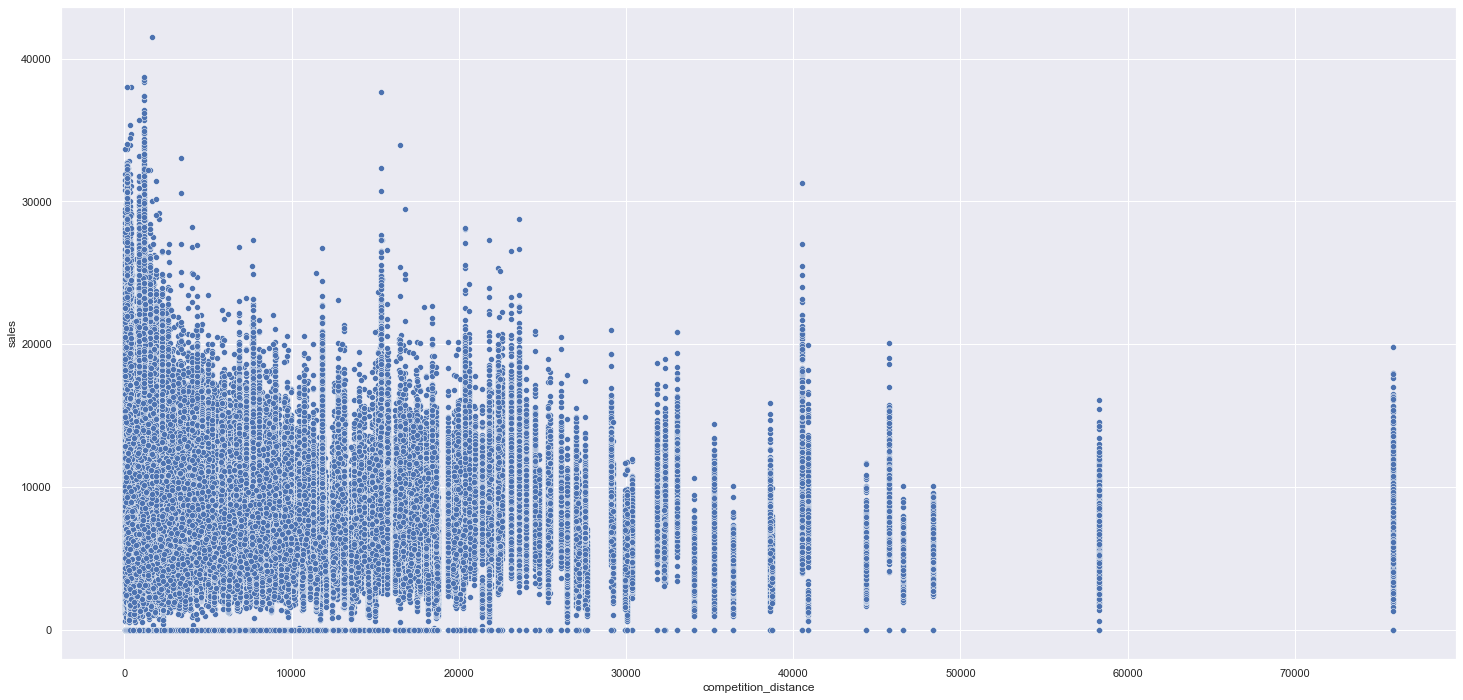

In [131]:
sns.scatterplot(data=df1, x='competition_distance', y='sales')

In [84]:
aux1 = df1[df1['competition_distance'].isna()]
aux1['sales'].describe()

count     2642.000000
mean      4535.892884
std       3159.272631
min          0.000000
25%       2883.250000
50%       4233.000000
75%       6164.250000
max      21872.000000
Name: sales, dtype: float64

In [132]:
aux1 = df1[(df1['sales'] > 4000) & (df1['sales'] < 5000)]
aux1['competition_distance'].describe()

count    122187.000000
mean       5352.096131
std        7731.814137
min          20.000000
25%         780.000000
50%        2330.000000
75%        6470.000000
max       75860.000000
Name: competition_distance, dtype: float64

In [7]:
#C1 - 20.000 m
#C2 - it was used the mean distance, since the sales values is between 4000 to 5000 and the mean distance is 5352.
# competition_distance
#C3 - kept the strategy
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 5352.09 if math.isnan(x) else x)

### 1.5.2. COMPETITION OPEN SINCE MONTH / YEAR - 323348 missing values

In [8]:
aux1 = df1[df1['competition_open_since_month'].isna()]
len(aux1['store'].unique())

354

In [9]:
#Strategy - we are going to use the last day available and think the competitors have started from this day forward
aux1 = df1['date'][0]

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: aux1.month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: aux1.year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

### 1.5.3. PROMO 2 SINCE WEEK / YEAR / PROMO INTERVAL  - 508031 missing values

In [138]:
# All missing values occurs when the promo2 is 0.
len(df1[df1['promo2']== 0])

508031

In [139]:
# Verify if there was some miss typing in the information
len(df1[df1['promo2']== 0]) == len(df1[df1['promo2_since_week'].isna()])

True

In [11]:
# They are randomly distributed
aux1 = df1[df1['promo2_since_week'].isna()]
aux1[['store', 'store_type', 'assortment']].groupby(['store_type', 'assortment']).count().T

store_type       a             b                 c             d       
assortment       a       c     a     b    c      a      c      a      c
store       182195  111546  5652  4710  942  35612  32970  46754  87650

In [157]:
# About half of total stores do not apply for promo2
aux1 = df1[df1['promo2_since_week'].isna()]
len(aux1['store'].unique())

544

In [12]:
# CONCLUSION
# Since promo2 == 0 have all NA values, it means that the NaN values only refers that the information is not applicable.
# we are going to insert the 0 values to remove the NaN value
# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: 0 if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: 0 if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
df1['promo_interval'].fillna(0, inplace=True)

In [13]:
df1.sample(10)

store  day_of_week       date  sales  customers  open  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year    promo_interval
783950    891            1 2013-07-29  11357       1400     1      1             0               1          a          c                 350.0                           7.0                       2015.0       1               31.0             2013.0   Feb,May,Aug,Nov
917091    232            7 2013-03-31      0          0     0      0             0               0          c          c               13570.0                           5.0                       2010.0       1               10.0             2013.0  Mar,Jun,Sept,Dec
650434     60            1 2013-11-25   7727        676     1      0             0               0          d          c                5540.0                          10.0                       2009.0       0                0.0                0.0                 0
795231   1022            5 2013-07-19   7580        871     1      1             0               0          a          c                1520.0                           7.0                       2015.0       0                0.0                0.0                 0
303357    715            2 2014-10-21   7145        743     1      1             0               0          a          a               14810.0                           6.0                       2014.0       0                0.0                0.0                 0
829764    990            2 2013-06-18   6405        528     1      1             0               0          d          a               20930.0                           7.0                       2015.0       0                0.0                0.0                 0
618801    762            2 2013-12-24   2549        286     1      0             0               1          d          c                1280.0                           7.0                       2015.0       1               10.0             2013.0  Mar,Jun,Sept,Dec
619524    370            1 2013-12-23  14017       1237     1      0             0               1          d          a                8250.0                          10.0                       2000.0       1               31.0             2009.0   Jan,Apr,Jul,Oct
750116    507            3 2013-08-28   8542        632     1      1             0               1          a          c                9070.0                           4.0                       2011.0       1               37.0             2009.0   Jan,Apr,Jul,Oct
164643    739            5 2015-03-06  11881        912     1      1             0               0          d          c                2770.0                           6.0                       2008.0       1               22.0             2011.0   Jan,Apr,Jul,Oct

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 1.6 Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [16]:
df1['day_of_week'] = df1['day_of_week'].astype('str')
df1['open'] = df1['open'].astype('str')
df1['promo'] = df1['promo'].astype('str')
df1['state_holiday'] = df1['state_holiday'].astype('str')
df1['school_holiday'] = df1['school_holiday'].astype('str')
#removing the .0 form float value
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('str')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('str')
# yes or no - dicotomic
df1['promo2'] = df1['promo2'].astype('str')
#removing the .0 form float value
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('str')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('str')

## 1.7 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include=('int64', 'float64'))
cat_attributes = df1.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

### 1.7.1 Numerical Attibutes

In [53]:
a = num_attributes.describe().T.reset_index()

d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

n = pd.concat([d4, d5, d6], axis=0).T.reset_index()
n.columns = ['attibutes', 'range', 'skew', 'kurtosis']
b = a.merge(n, right_on='attibutes', left_on='index')
b.drop('index', axis=1, inplace=True)
columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
       'skew', 'kurtosis']
b[columns]

attibutes      count         mean          std     25%     50%     75%   min      max    range      skew   kurtosis
0                 store  1017209.0   558.429727   321.908651   280.0   558.0   838.0   1.0   1115.0   1114.0 -0.000955  -1.200524
1                 sales  1017209.0  5773.818972  3849.926175  3727.0  5744.0  7856.0   0.0  41551.0  41551.0  0.641460   1.778375
2             customers  1017209.0   633.145946   464.411734   405.0   609.0   837.0   0.0   7388.0   7388.0  1.598650   7.091773
3  competition_distance  1017209.0  5429.883074  7705.298682   710.0  2330.0  6880.0  20.0  75860.0  75840.0  2.932422  13.041987

* 'store' - Total of 1115 stores
* 'sales' - The Median and Mean are very close. But there is a high sale value that it could be a outlier (further investigation)
* 'customers' - In average, there is 600 customer per day.
* 'competition_distance' - the graph is positive skewed.

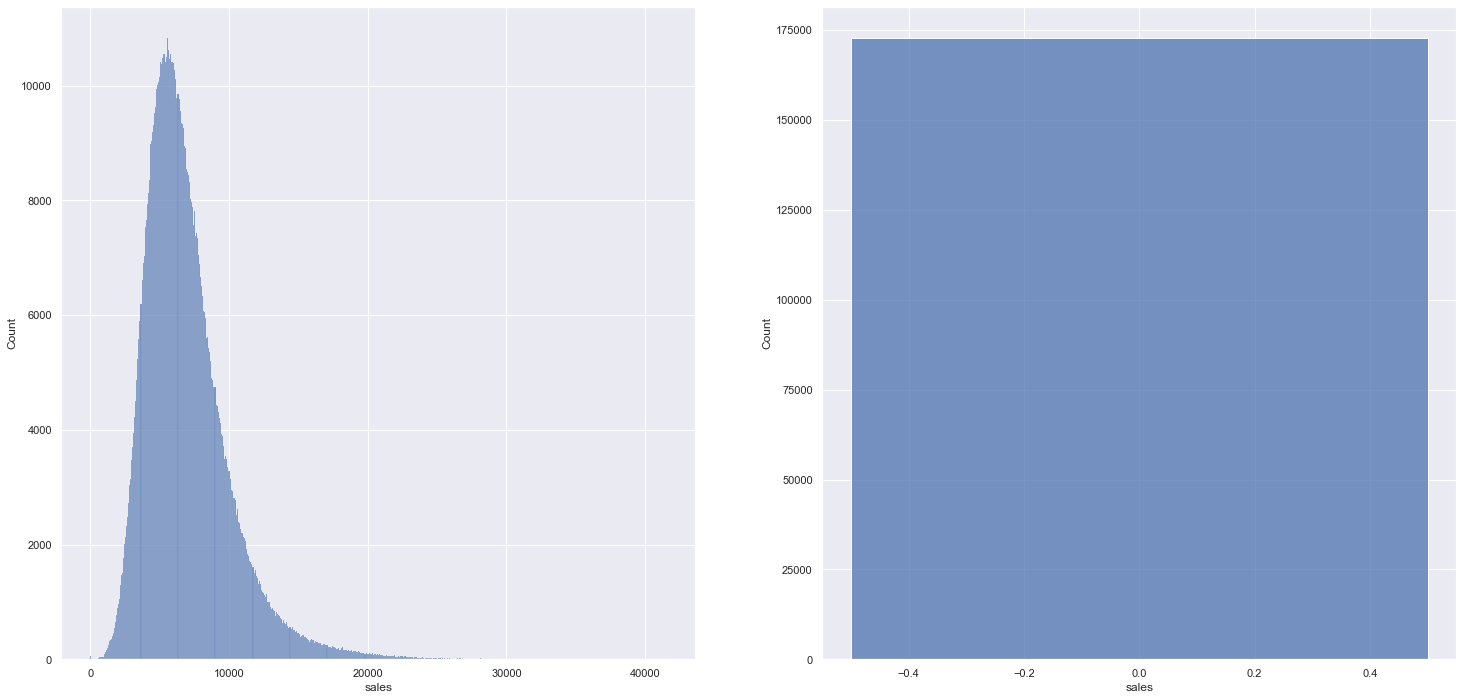

In [109]:
fig, axes = plt.subplots(1, 2)
aux1 = df1[(df1['sales']>=0) & (df1['open'] == '1')]
sns.histplot(aux1['sales'], ax=axes[0])
# There is almost 175000 records (17%) with no sales at all (when it is closed)
aux1 = df1[(df1['sales']>=0) & (df1['open'] == '0')]
sns.histplot(aux1['sales'], ax=axes[1]);

### 1.7.2 Categorical Attibutes

In [56]:
cat_attributes.apply( lambda x: x.unique().shape[0])

day_of_week                      7
open                             2
promo                            2
state_holiday                    4
school_holiday                   2
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2                           2
promo2_since_week               25
promo2_since_year                8
promo_interval                   4
dtype: int64

In [72]:
cat_attributes.columns

Index(['day_of_week', 'open', 'promo', 'state_holiday', 'school_holiday',
       'store_type', 'assortment', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

#### CATEGORICAL GRAPHS : OPEN = 0

In [59]:
aux1 = df1[df1['open'] == '0']
aux1.shape[0] / df1.shape[0]

0.16989330609540418

In [60]:
df1['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

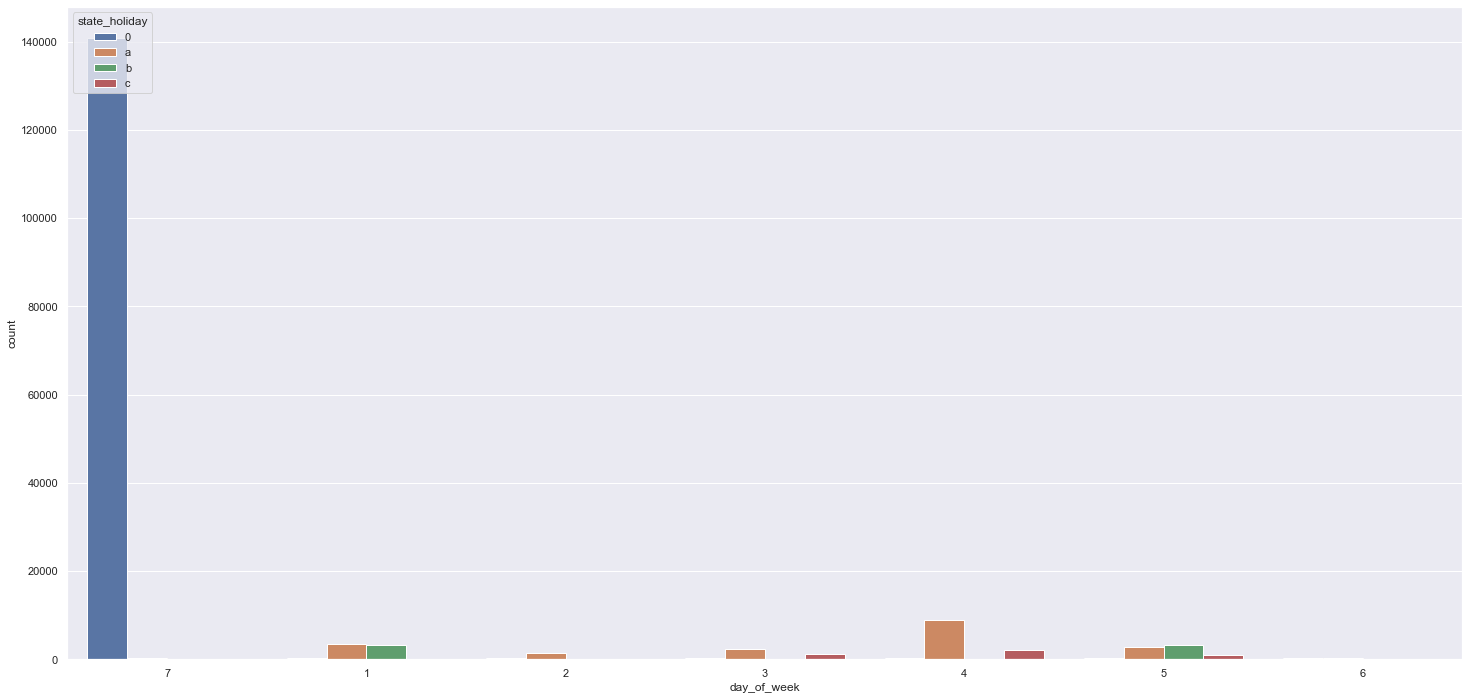

In [61]:
day_order = ['7','1','2','3','4','5','6']
sns.countplot(x='day_of_week', data=aux1, hue='state_holiday', order=day_order)

#### CATEGORICAL GRAPHS : OPEN = 1

<AxesSubplot:xlabel='promo', ylabel='sales'>

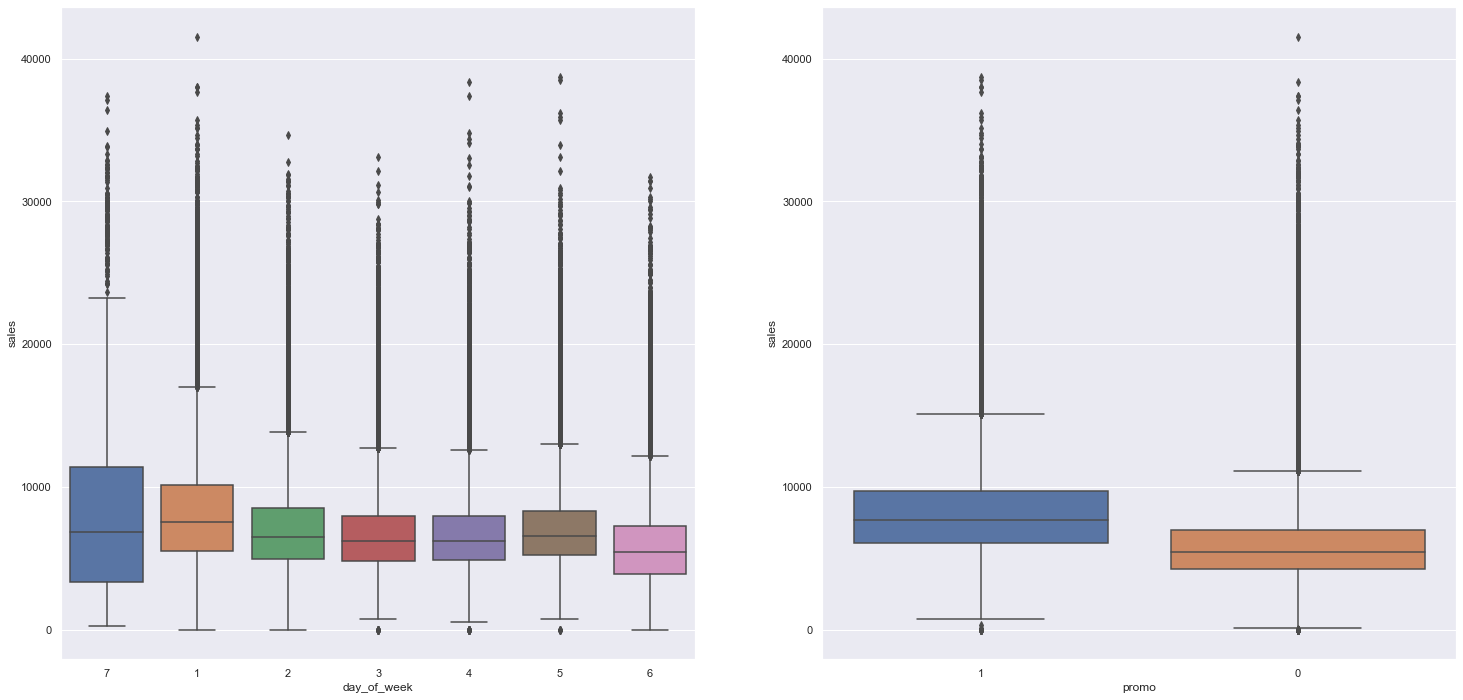

In [62]:
aux1=df1[(df1['open'] != '0')]
plt.subplot(1, 2, 1)
sns.boxplot(x='day_of_week' , y='sales', data=aux1, order=day_order)
plt.subplot(1, 2, 2)
sns.boxplot(x='promo' , y='sales', data=aux1)

<AxesSubplot:xlabel='day_of_week', ylabel='sales'>

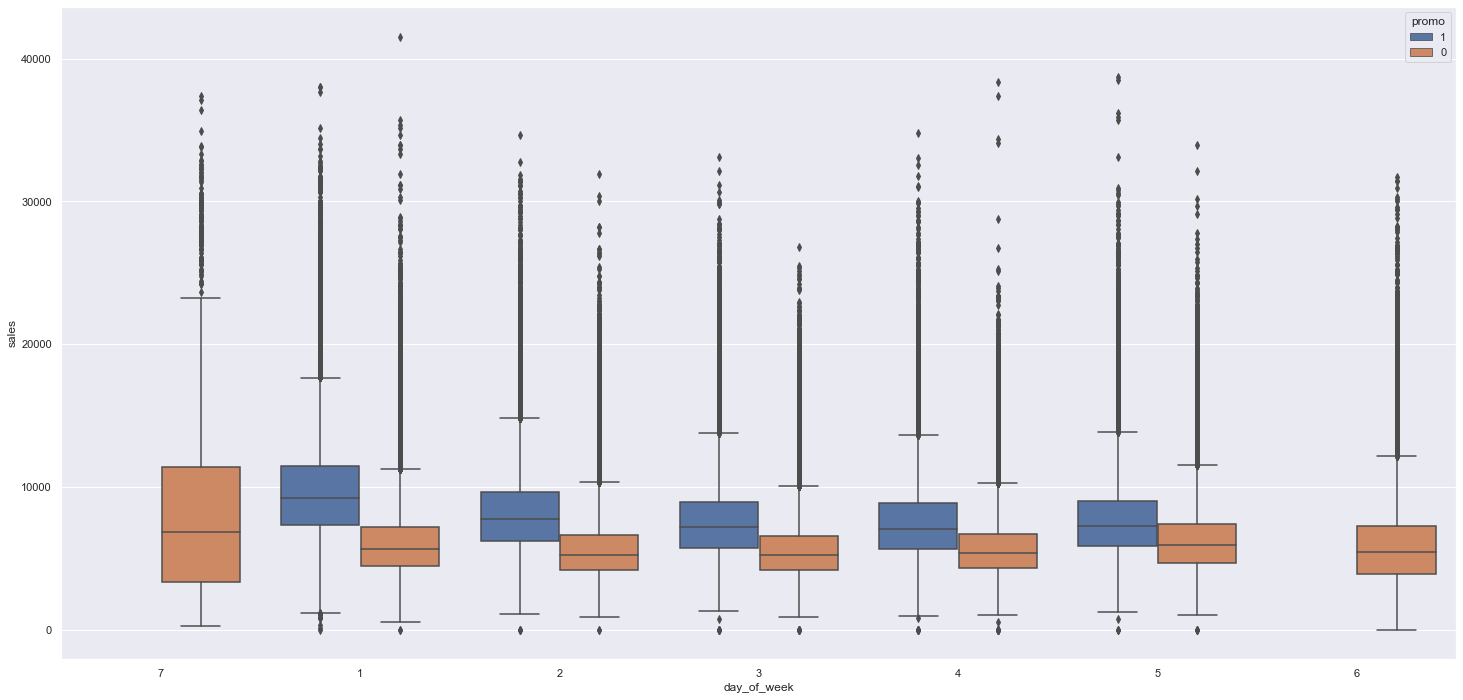

In [116]:
sns.boxplot(x='day_of_week' , y='sales', data=aux1, hue='promo', order=day_order)

* 'day_of_week' = the best median selling day is monday. the worst day is saturday.
* 'promo' = having promo is important to sell more (better median). But promo only happens during the weekday.

<AxesSubplot:xlabel='store_type', ylabel='sales'>

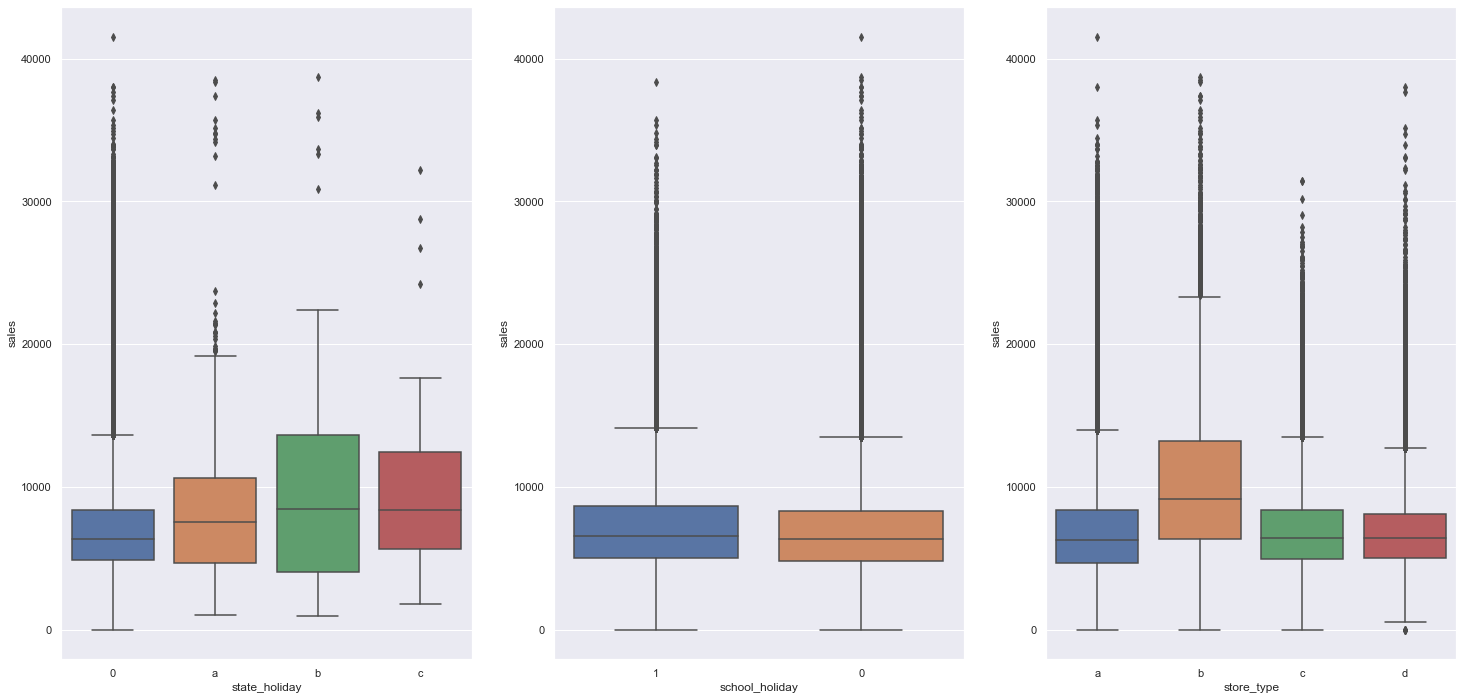

In [117]:
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' , y='sales', data=aux1)
plt.subplot(1, 3, 2)
sns.boxplot(x='school_holiday' , y='sales', data=aux1)
plt.subplot(1, 3, 3)
sns.boxplot(x='store_type' , y='sales', data=aux1, order=['a', 'b', 'c', 'd'])

* 'state_holiday' = easter holidays and Christimas have the best median
* 'school_holiday' = there is no huge effect on sales when the school is closed
* 'store_type' = the best selling store is type B (median).

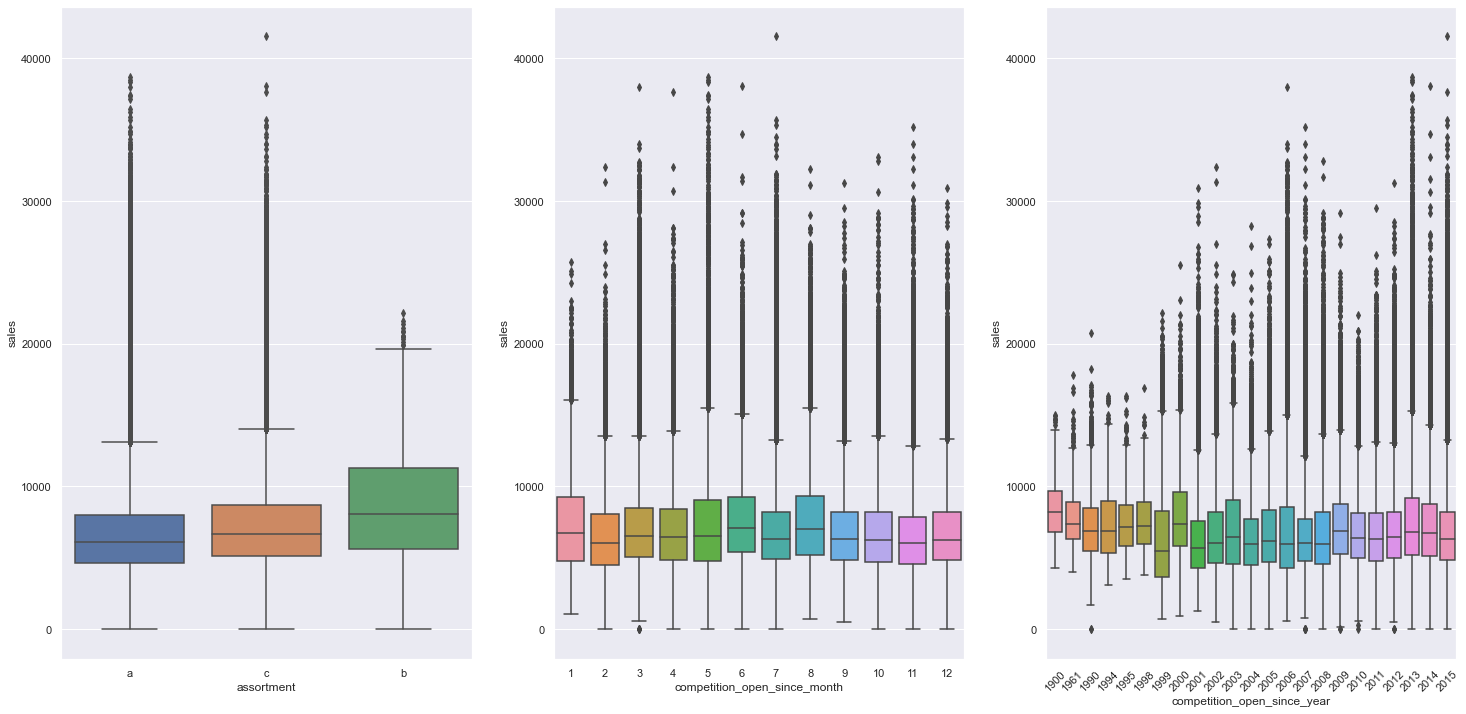

In [121]:
plt.subplot(1, 3, 1)
sns.boxplot(x='assortment' , y='sales', data=aux1)
aux2 = aux1.copy()
aux2['competition_open_since_month'] = aux2['competition_open_since_month'].astype('int64')
aux2['competition_open_since_year'] = aux2['competition_open_since_year'].astype('int64')
plt.subplot(1, 3, 2)
sns.boxplot(x='competition_open_since_month' , y='sales', data=aux2)
plt.subplot(1, 3, 3)
sns.boxplot(x='competition_open_since_year' , y='sales', data=aux2)
plt.xticks(rotation=45);
# 'promo2', 'promo2_since_week',
#       'promo2_since_year', 'promo_interval'

* 'assortment' = "b" assortment store have the best median. "c" is the second.
* 'competition_open_since_month' = the worst median is februrary (2), but it may be not related to competition, but it is a seasonal behavior.
* 'competition_open_since_year' = the longer the store are open (with competition) have better median.

<AxesSubplot:xlabel='promo2_since_year', ylabel='sales'>

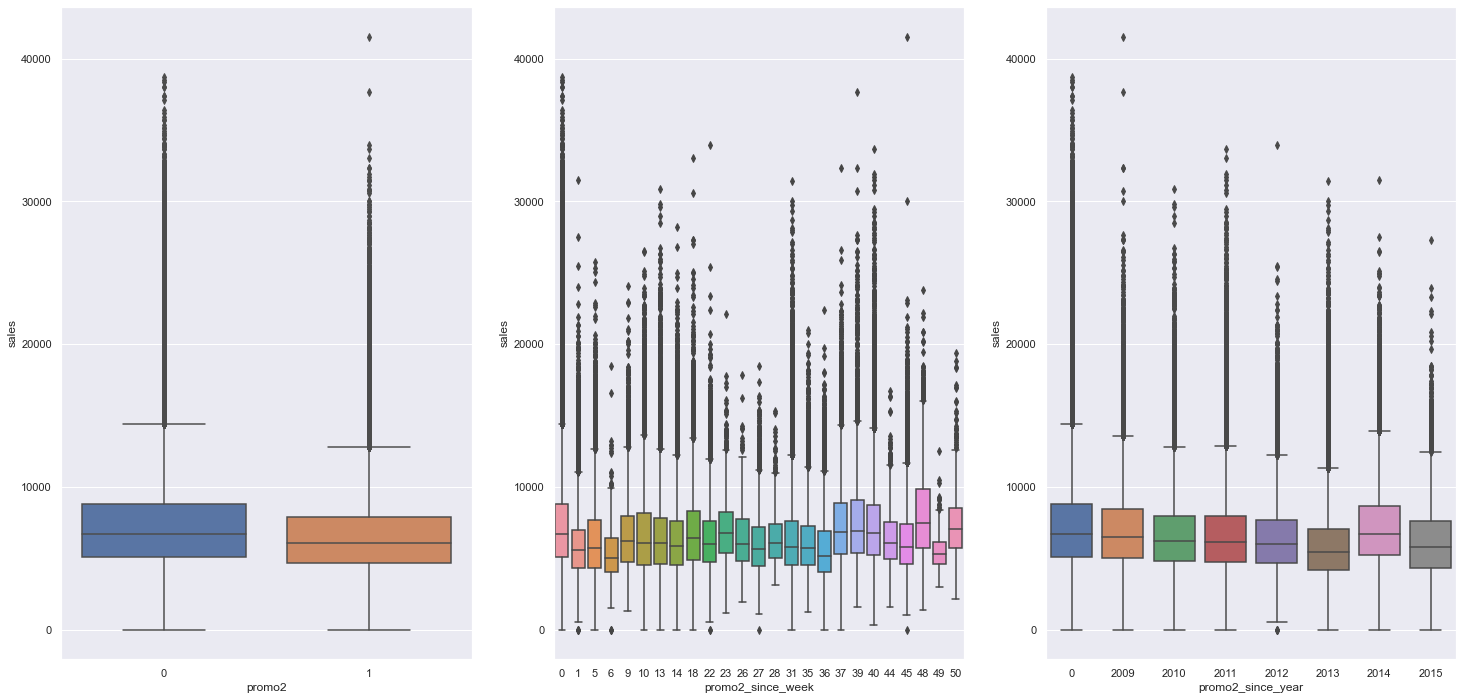

In [123]:
plt.subplot(1, 3, 1)
sns.boxplot(x='promo2' , y='sales', data=aux1)
aux2 = aux1.copy()
aux2['promo2_since_week'] = aux2['promo2_since_week'].astype('int64')
aux2['promo2_since_year'] = aux2['promo2_since_year'].astype('int64')
plt.subplot(1, 3, 2)
sns.boxplot(x='promo2_since_week' , y='sales', data=aux2)
plt.subplot(1, 3, 3)
sns.boxplot(x='promo2_since_year' , y='sales', data=aux2)
#'promo_interval'

* 'promo2' = store which have adopted promo2 have smaller median.
* 'promo2_since_week' = Week 45 has the best median. The worst is week 6
* 'promo2_since_year' = The best median is 0 (stores with no promo2) and the year of 2014 when the stores choose promo2.

<AxesSubplot:xlabel='day_of_week', ylabel='sales'>

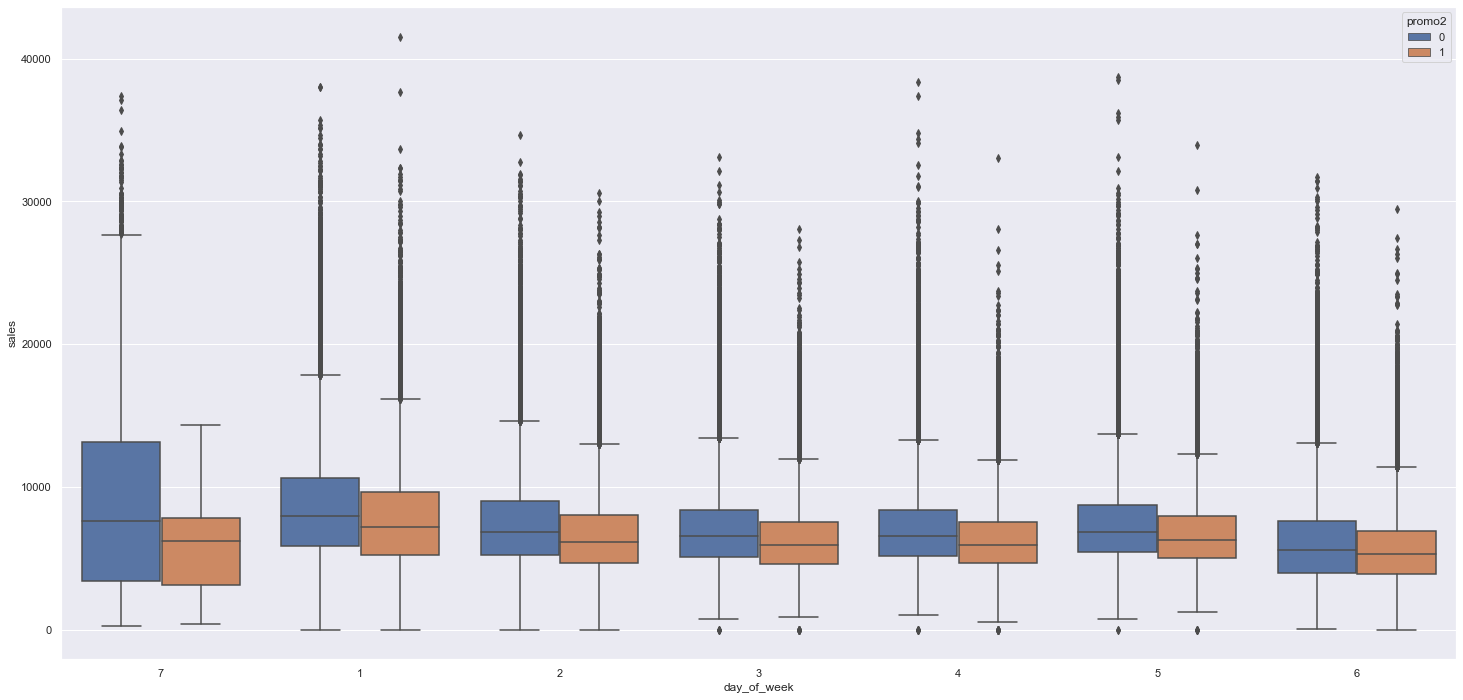

In [85]:
sns.boxplot(x='day_of_week' , y='sales', data=aux1, hue='promo2', order=day_order)

* 'day_of_week' = the median is better between Sunday and Monday, after that it starts to decrease until Saturday.

<AxesSubplot:xlabel='promo_interval', ylabel='sales'>

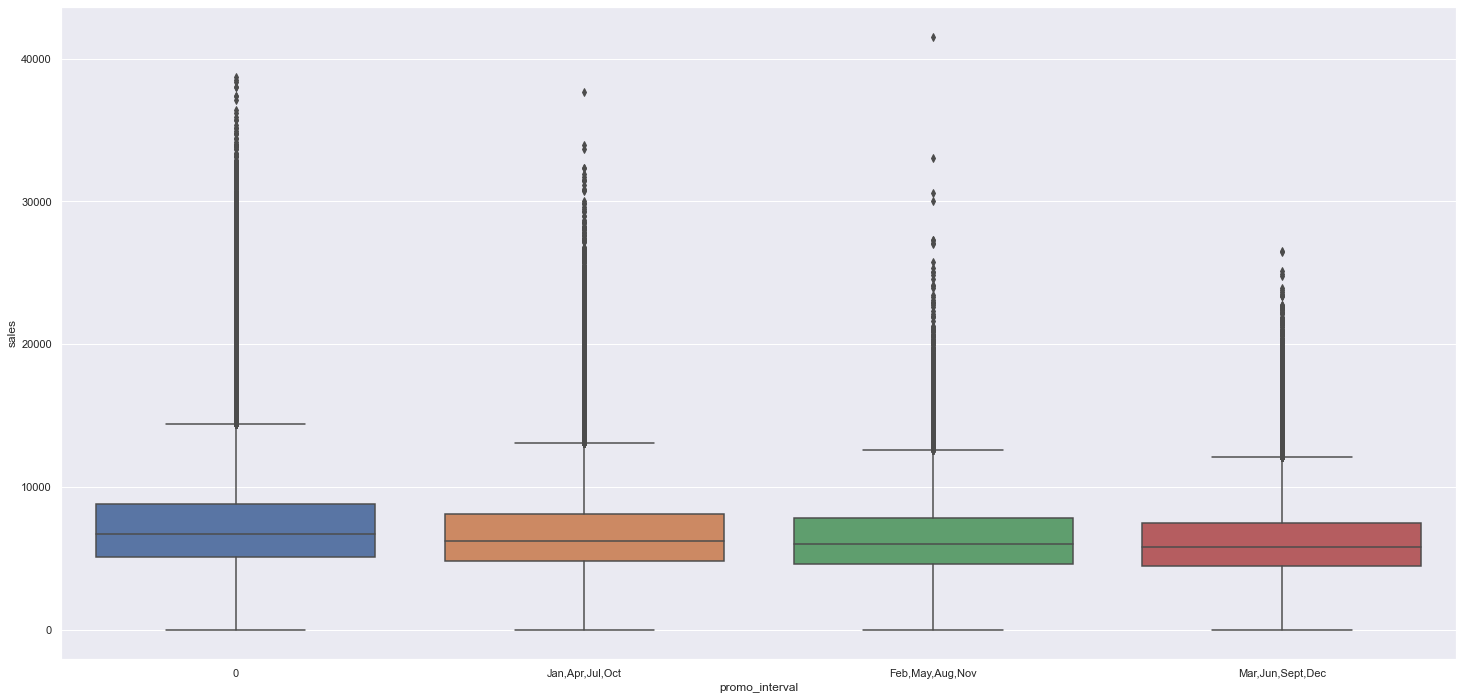

In [80]:
sns.boxplot(x='promo_interval' , y='sales', data=aux1)

In [63]:
df1.to_csv('dataset/C3/c03_01_rossman.csv', index=False)

# 2.0 FEATURE ENGINEERING

In [159]:
df2 = pd.read_csv('dataset/C3/c03_01_rossman.csv')
df2['date'] = pd.to_datetime(df2['date'])
df2.dtypes

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

## 2.1 Hypotheses Mindmap

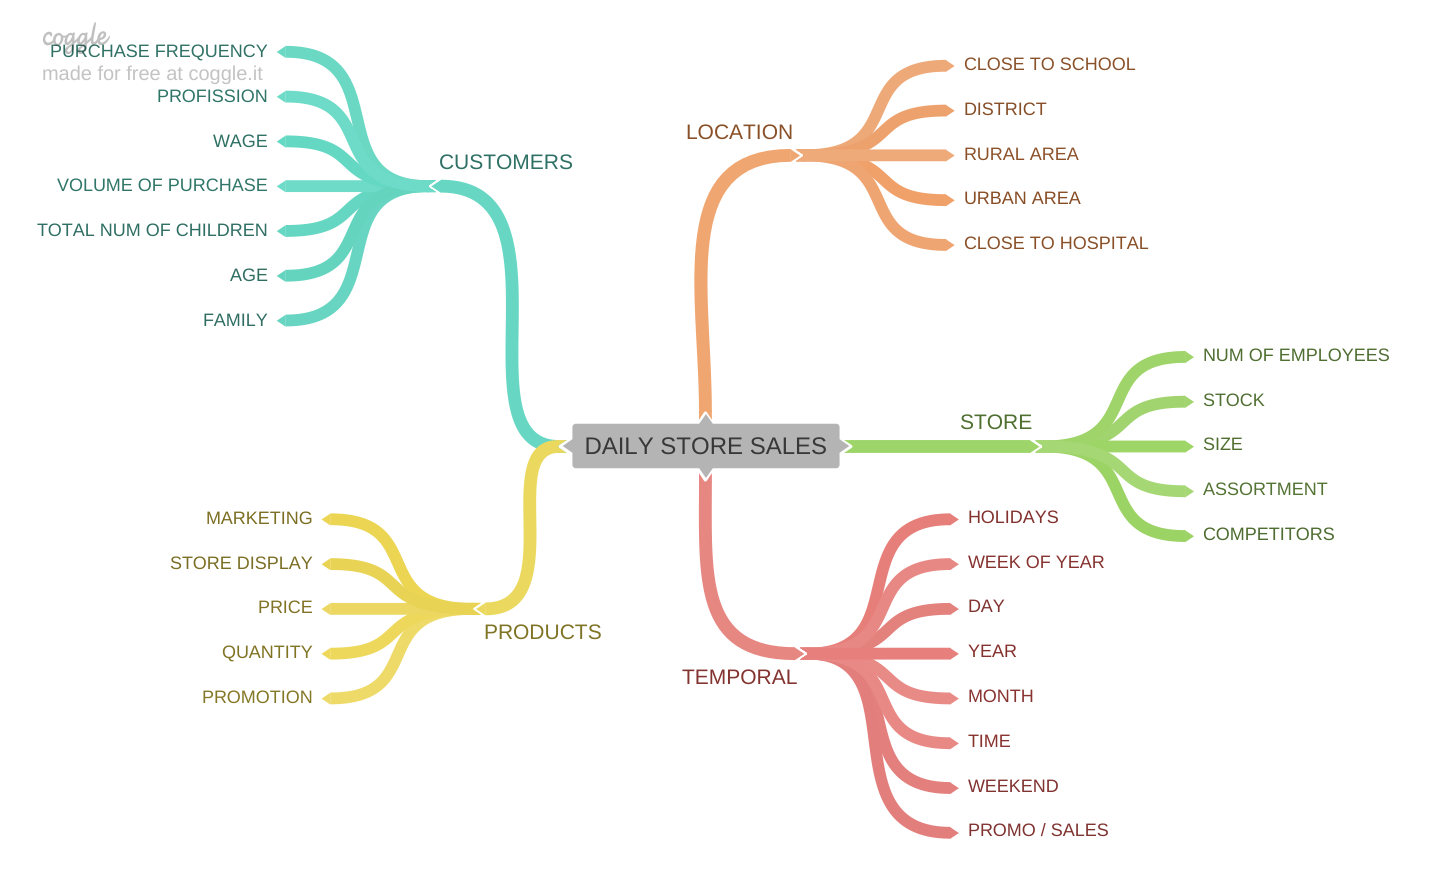

In [71]:
Image('img/DAILY_STORE_SALES_eng.png')

## 2.2 Hypotheses creation

### 2.2.1 Store Hypotheses

**1.** Stores with a larger number of employees should sell more.

**2.** Stores with a larger stock should sell more.

**3.** Larger stores should sell more.

**4.** The best selling store should have an 'extended' inventory.

**5.** Stores with the closest competititors should sell less.

**6.** Stores with competitors for long period should sell more.

**7.** Stores with a highest number of customer have the max selling value.

### 2.2.2 Product Hypothese

**1.** Stores which invest more on marketing should sell more.

**2.** Stores which expose more the product on shelf should sell more.

**3.** Stores with a cheaper product should sell more.

**4.** Stores with a larger discount (aggressive promo) should sell more.

**5.** Stores with extended promo should sell more, compared to regular promo.

**6.** Stores with consecutive promos should sell more.

### 2.2.3 Temporal Hypothese

**1.** Stores should sell more on Christmas.

**2.** Stores should perform better through time.

**3.** Stores should sell less on weekend.

**4.** Stores should sell less during schools holidays.

**5.** Stores open with no sells, should have open on school holiday / holidays.

## 2.3 Hypotheses Final List

**1.** Stores with a larger number of employees should sell more.

**2.** Stores with a larger stock should sell more.

**3.** Larger stores should sell more.

**4.** The best selling store should have an 'extended' inventory.

**5.** Stores with the closest competititors should sell less.

**6.** Stores with competitors for long period should sell more.

**7.** Stores with a highest number of customer have the max selling value.

**8.** Stores which invest more on marketing should sell more.

**9.** Stores which expose more the product on shelf should sell more.

**10.** Stores with a cheaper product should sell more.

**11.** Stores with a larger discount (aggressive promo) should sell more.

**12.** Stores with extended promo should sell more, compared to regular promo.

**13.** Stores with consecutive promos should sell more.

**14.** Stores should sell more on Christmas.

**15.** Stores should perform better through time.

**16.** Stores should sell less on weekend.

**17.** Stores should sell less during schools holidays.

**18.** Stores open with no sells, should have open on school holiday / holidays.

## 2.4 Feature Engineering

In [72]:
df2.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year   promo_interval
0      1            5 2015-07-31   5263        555     1      1             0               1          c          a                1270.0                             9                         2008       0                  0                  0                0
1      2            5 2015-07-31   6064        625     1      1             0               1          a          a                 570.0                            11                         2007       1                 13               2010  Jan,Apr,Jul,Oct
2      3            5 2015-07-31   8314        821     1      1             0               1          a          a               14130.0                            12                         2006       1                 14               2011  Jan,Apr,Jul,Oct
3      4            5 2015-07-31  13995       1498     1      1             0               1          c          c                 620.0                             9                         2009       0                  0                  0                0
4      5            5 2015-07-31   4822        559     1      1             0               1          a          a               29910.0                             4                         2015       0                  0                  0                0

In [160]:
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# promo since
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: (datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7)) if x != '0-0' else datetime.datetime(year=2015, month=7, day=31))
df2['promo2_time_days'] = df2.apply(lambda x: 0 if (x['date'] < x['promo2_since']) else (x['date'] - x['promo2_since']), axis=1)
df2['promo2_time_days'] = df2['promo2_time_days'].apply(lambda x: 0 if isinstance(x, int) else x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x=='a' else 'eastern_holiday' if x=='b' else 'christimas' if x=='c' else 'regular_day')

In [161]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_days'] = df2.apply(lambda x: 0 if (x['date'] < x['competition_since']) else (x['date'] - x['competition_since']), axis=1)
df2['competition_time_days'] = df2['competition_time_days'].apply( lambda x: 0 if isinstance(x, int) else x.days).astype('int64')

In [162]:
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df2['month_map'] = df2['date'].dt.month.map(month_map)

df2['promo2_on'] = df2[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [163]:
df2['store_cat'] = df2['store_type'] + '-' + df2['assortment']

In [164]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year2'] = df2['date'].dt.isocalendar().year
df2['week_of_year'] = df2.apply(lambda x: str(x['week_of_year2']) + '/0' + str(x['week_of_year']) if x['week_of_year'] < 10 else str(x['week_of_year2']) + '/' + str(x['week_of_year']), axis=1)

In [165]:
df2 = df2.drop(['competition_open_since_month', 'competition_open_since_year', 
                'promo2_since_week', 'promo2_since_year', 'promo_interval',
                'year_week', 'promo2_since', 'competition_since', 'month_map', 'week_of_year2'
               ], axis=1)

In [80]:
df2.head().T

0                    1                    2                    3                    4
store                                    1                    2                    3                    4                    5
day_of_week                              5                    5                    5                    5                    5
date                   2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00
sales                                 5263                 6064                 8314                13995                 4822
customers                              555                  625                  821                 1498                  559
open                                     1                    1                    1                    1                    1
promo                                    1                    1                    1                    1                    1
state_holiday                  regular_day          regular_day          regular_day          regular_day          regular_day
school_holiday                           1                    1                    1                    1                    1
store_type                               c                    a                    a                    c                    a
assortment                           basic                basic                basic             extended                basic
competition_distance                1270.0                570.0              14130.0                620.0              29910.0
promo2                                   0                    1                    1                    0                    0
ticket_by_store                   9.482883               9.7024            10.126675             9.342457             8.626118
promo2_time_days                         0                 1957                 1586                    0                    0
competition_time_days                 2524                 2829                 3164                 2159                  121
promo2_on                                0                    1                    1                    0                    0
store_cat                          c-basic              a-basic              a-basic           c-extended              a-basic
year                                  2015                 2015                 2015                 2015                 2015
month                                    7                    7                    7                    7                    7
day                                     31                   31                   31                   31                   31
week_of_year                       2015/31              2015/31              2015/31              2015/31              2015/31

In [166]:
df2.to_csv('dataset/C3/c03_02_rossman.csv', index=False)

# 3.0 FEATURE FILTERING

In [167]:
df3 = pd.read_csv('dataset/C3/c03_02_rossman.csv')

In [86]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'promo2', 'ticket_by_store', 'promo2_time_days',
       'competition_time_days', 'promo2_on', 'store_cat', 'year', 'month',
       'day', 'week_of_year'],
      dtype='object')

In [169]:
order = ['date', 'open', 'day_of_week', 'store', 'store_type', 'assortment', 'store_cat', 'sales', 'customers', 
         'state_holiday', 'school_holiday',
         'competition_time_days', 'competition_distance',
         'promo', 'promo2_on', 'promo2_time_days',
         'year', 'month', 'day', 'week_of_year'
        ]
df3 = df3[order]
df3.head(20)

date  open  day_of_week  store store_type assortment   store_cat  sales  customers state_holiday  school_holiday  competition_time_days  competition_distance  promo  promo2_on  promo2_time_days  year  month  day week_of_year
0   2015-07-31     1            5      1          c      basic     c-basic   5263        555   regular_day               1                   2524                1270.0      1          0                 0  2015      7   31      2015/31
1   2015-07-31     1            5      2          a      basic     a-basic   6064        625   regular_day               1                   2829                 570.0      1          1              1957  2015      7   31      2015/31
2   2015-07-31     1            5      3          a      basic     a-basic   8314        821   regular_day               1                   3164               14130.0      1          1              1586  2015      7   31      2015/31
3   2015-07-31     1            5      4          c   extended  c-extended  13995       1498   regular_day               1                   2159                 620.0      1          0                 0  2015      7   31      2015/31
4   2015-07-31     1            5      5          a      basic     a-basic   4822        559   regular_day               1                    121               29910.0      1          0                 0  2015      7   31      2015/31
5   2015-07-31     1            5      6          a      basic     a-basic   5651        589   regular_day               1                    607                 310.0      1          0                 0  2015      7   31      2015/31
6   2015-07-31     1            5      7          a   extended  a-extended  15344       1414   regular_day               1                    851               24000.0      1          0                 0  2015      7   31      2015/31
7   2015-07-31     1            5      8          a      basic     a-basic   8492        833   regular_day               1                    303                7520.0      1          0                 0  2015      7   31      2015/31
8   2015-07-31     1            5      9          a   extended  a-extended   8565        687   regular_day               1                   5477                2030.0      1          0                 0  2015      7   31      2015/31
9   2015-07-31     1            5     10          a      basic     a-basic   7185        681   regular_day               1                   2159                3160.0      1          0                 0  2015      7   31      2015/31
10  2015-07-31     1            5     11          a   extended  a-extended  10457       1236   regular_day               1                   1368                 960.0      1          1              1313  2015      7   31      2015/31
11  2015-07-31     1            5     12          a   extended  a-extended   8959        962   regular_day               1                     30                1070.0      1          1              1957  2015      7   31      2015/31
12  2015-07-31     1            5     13          d      basic     d-basic   8821        568   regular_day               0                     30                 310.0      1          0              2097  2015      7   31      2015/31
13  2015-07-31     1            5     14          a      basic     a-basic   6544        710   regular_day               1                    517                1300.0      1          1              1404  2015      7   31      2015/31
14  2015-07-31     1            5     15          d   extended  d-extended   9191        766   regular_day               1                   1978                4110.0      1          1              1586  2015      7   31      2015/31
15  2015-07-31     1            5     16          a   extended  a-extended  10231        979   regular_day               1                     30                3270.0      1          0                 0  2015      7   31      2015/31
16  2015-07-31 

## 3.1. Row Filtering

In [20]:
# all lines will be selected

## 3.2. Column Filtering

In [404]:
df3.columns

Index(['date', 'open', 'day_of_week', 'store', 'store_type', 'assortment',
       'store_cat', 'sales', 'customers', 'ticket_by_store', 'state_holiday',
       'school_holiday', 'competition_time_days', 'competition_distance',
       'promo', 'promo2_on', 'promo2_time_days', 'year', 'month', 'day',
       'week_of_year'],
      dtype='object')

In [170]:
df3.to_csv('dataset/C3/c03_03_rossman.csv', index=False)

# 4.0 EXPLORATORY DATA ANALYSIS

In [171]:
df4 = pd.read_csv('dataset/C3/c03_03_rossman.csv')
df4['date'] = pd.to_datetime(df4['date'])
df4.dtypes

date                     datetime64[ns]
open                              int64
day_of_week                       int64
store                             int64
store_type                       object
assortment                       object
store_cat                        object
sales                             int64
customers                         int64
state_holiday                    object
school_holiday                    int64
competition_time_days             int64
competition_distance            float64
promo                             int64
promo2_on                         int64
promo2_time_days                  int64
year                              int64
month                             int64
day                               int64
week_of_year                     object
dtype: object

In [172]:
num_attributes = df4.select_dtypes(include=('int64', 'float64'))
cat_attributes = df4.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

## 4.1. UNIVARIABLE ANALYSIS

### 4.1.1. RESPONSE VARIABLE

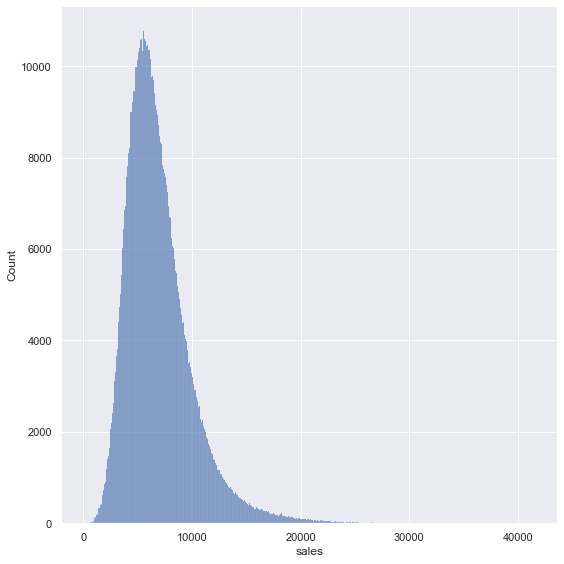

In [173]:
aux1 = df1[df1['sales'] > 0]
sns.set_theme(style="darkgrid")
sns.displot(aux1['sales'], height=8)

### 4.1.2. NUMERICAL VARIABLE

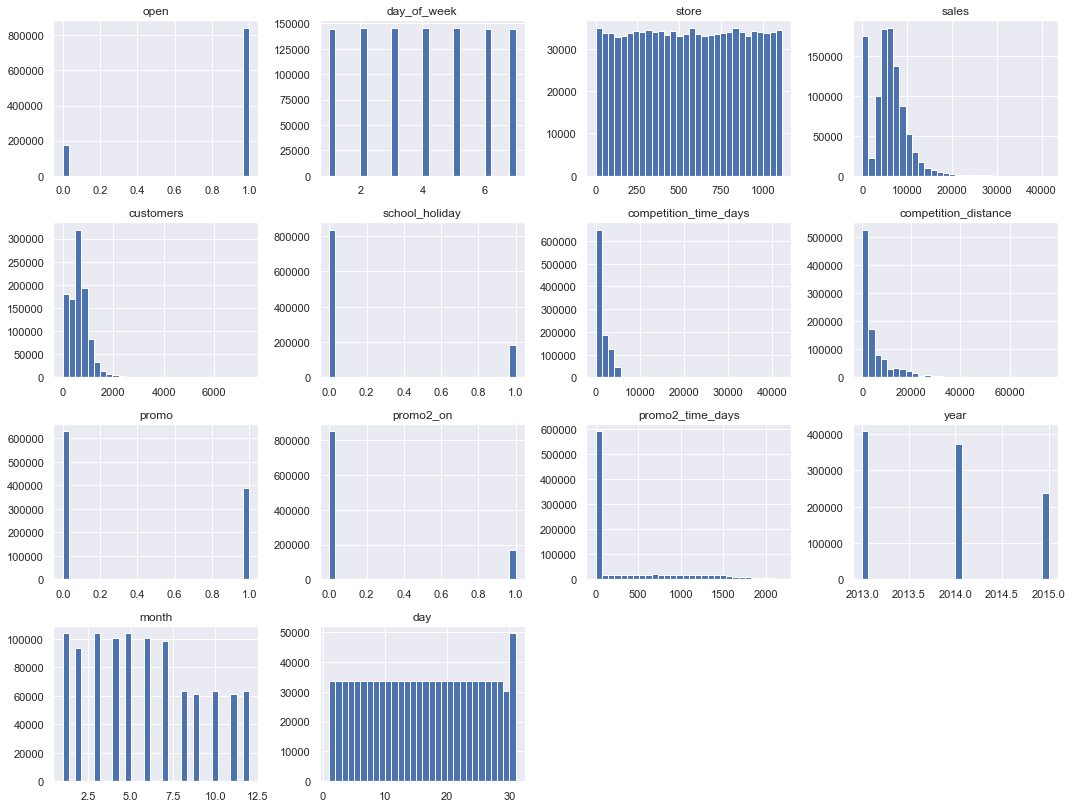

In [174]:
num_attributes.hist(bins=30, figsize = (18,14));
plt.show()

### 4.1.3. CATEGORICAL VARIABLE

In [415]:
cat_attributes.columns

Index(['store_type', 'assortment', 'store_cat', 'state_holiday',
       'week_of_year'],
      dtype='object')

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


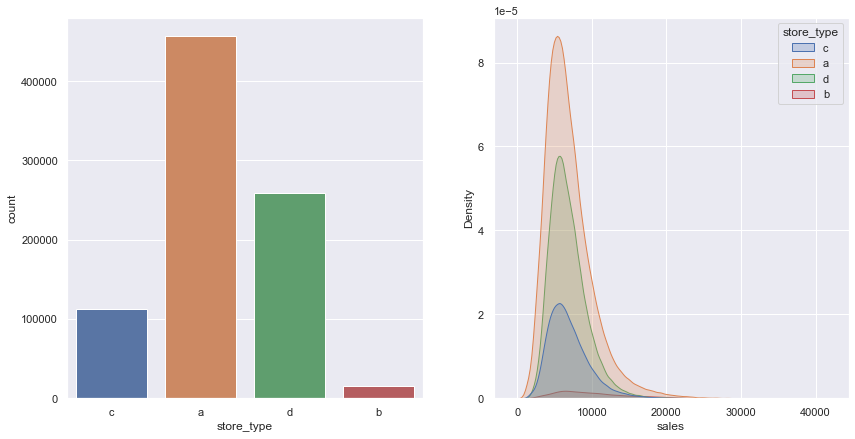

In [96]:
#store_type
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
a = df4[(df4['sales']>0)]
sns.countplot(a['store_type'])

plt.subplot(1, 2, 2)
sns.kdeplot(data=a, x='sales', hue='store_type', shade=True)
plt.show()

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


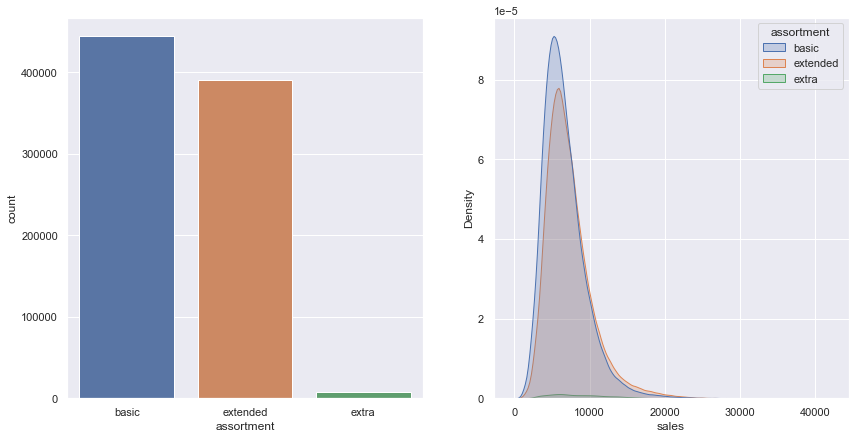

In [420]:
#assortment
plt.figure(figsize=(14, 7))
a = df4[(df4['sales']>0)]
plt.subplot(1, 2, 1)
sns.countplot(a['assortment'])

plt.subplot(1, 2, 2)
sns.kdeplot(data=a, x='sales', hue='assortment', shade=True)
plt.show()

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


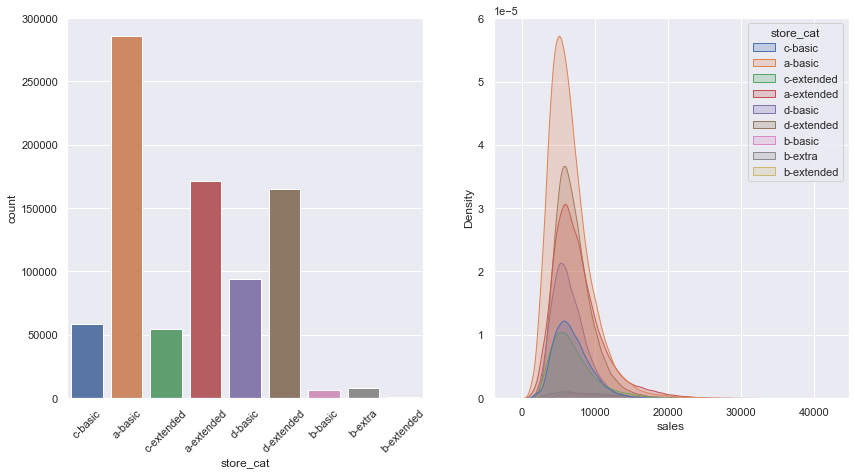

In [422]:
#store_cat
plt.figure(figsize=(14, 7))
a = df4[(df4['sales']>0)]
plt.subplot(1, 2, 1)
sns.countplot(a['store_cat'])
plt.xticks(rotation=45);

plt.subplot(1, 2, 2)
sns.kdeplot(data=a, x='sales', hue='store_cat', shade=True)
plt.show()

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


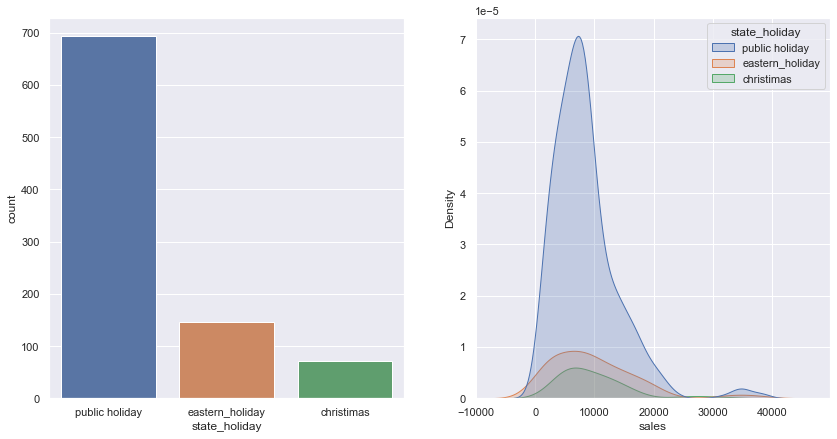

In [417]:
#state_holiday
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
a = df4[(df4['state_holiday'] != 'regular_day') & (df4['sales']>0)]
sns.countplot(a['state_holiday'])

plt.subplot(1, 2, 2)
sns.kdeplot(data=a, x='sales', hue='state_holiday', shade=True)
plt.show()

## 4.2. BIVARIABLE ANALYSIS

In [275]:
df4.columns

Index(['date', 'open', 'day_of_week', 'store', 'store_type', 'assortment',
       'store_cat', 'assortment.1', 'sales', 'customers', 'ticket_by_store',
       'state_holiday', 'school_holiday', 'competition_time_days',
       'competition_distance', 'promo', 'promo2_on', 'promo2_time_days',
       'year', 'month', 'day', 'week_of_year'],
      dtype='object')

In [276]:
df4.head()

date  open  day_of_week  store store_type assortment   store_cat assortment.1  sales  customers  ticket_by_store state_holiday  school_holiday  competition_time_days  competition_distance  promo  promo2_on  promo2_time_days  year  month  day week_of_year
0 2015-07-31     1            5      1          c      basic     c-basic        basic   5263        555         9.482883   regular_day               1                   2524                1270.0      1          0                 0  2015      7   31      2015/31
1 2015-07-31     1            5      2          a      basic     a-basic        basic   6064        625         9.702400   regular_day               1                   2829                 570.0      1          1              1957  2015      7   31      2015/31
2 2015-07-31     1            5      3          a      basic     a-basic        basic   8314        821        10.126675   regular_day               1                   3164               14130.0      1          1              1586  2015      7   31      2015/31
3 2015-07-31     1            5      4          c   extended  c-extended     extended  13995       1498         9.342457   regular_day               1                   2159                 620.0      1          0                 0  2015      7   31      2015/31
4 2015-07-31     1            5      5          a      basic     a-basic        basic   4822        559         8.626118   regular_day               1                    121               29910.0      1          0                 0  2015      7   31      2015/31

#### H1. ASSORTMENT x SALES - The best selling store should have an 'extended' inventory - HIGH

**TRUE:** The mean sales by day of extended assortment is higher than the others assortment types (with a high standard deviation)

In [175]:
aux1 = df4[['store', 'sales', 'store_cat', 'customers', 'store_type', 'assortment']].groupby(['store', 'store_cat', 'store_type', 'assortment']).sum().reset_index()
aux1['total_records'] = df4[['store', 'sales', 'store_cat', 'customers', 'store_type', 'assortment']].groupby(['store', 'store_cat', 'store_type', 'assortment']).count().reset_index()['sales']
aux1['mean_sales_day'] = aux1['sales'] / aux1['total_records']
aux1.sort_values('mean_sales_day', ascending=False)

store   store_cat store_type assortment     sales  customers  total_records  mean_sales_day
261     262     b-basic          b      basic  19516842    3204694            942    20718.515924
816     817     a-basic          a      basic  17057867    2454370            942    18108.139066
561     562  b-extended          b   extended  16927322    2924960            942    17969.556263
1113   1114  a-extended          a   extended  16202585    2509542            942    17200.196391
250     251  a-extended          a   extended  14896870    1908934            942    15814.087049
841     842  d-extended          d   extended  11553523     714829            758    15242.114776
512     513     a-basic          a      basic  14252406    1643527            942    15129.942675
787     788  a-extended          a   extended  14082141    1346835            942    14949.194268
732     733     b-extra          b      extra  14067158    3206058            942    14933.288747
382     383  a-extended          a   extended  13489879    1720249            942    14320.466030
755     756  a-extended          a   extended  12911782    1827980            942    13706.774947
334     335     b-basic          b      basic  12541731    2246936            942    13313.939490
697     698     a-basic          a      basic  12202270    1518304            942    12953.577495
522     523  c-extended          c   extended  12175995    1397803            942    12925.684713
594     595  c-extended          c   extended  11774982    1382516            942    12499.980892
585     586  a-extended          a   extended  11742401    1832458            942    12465.393843
319     320  a-extended          a   extended  11630218    1617489            942    12346.303609
379     380     a-basic          a      basic  11261676    1075375            942    11955.070064
543     544     a-basic          a      basic  10993709    1439156            942    11670.604034
1032   1033     a-basic          a      basic  10870270    1018597            942    11539.564756
258     259     b-extra          b      extra  10851871    2210980            942    11520.032909
335     336     a-basic          a      basic  10850316    1529043            942    11518.382166
545     546     a-basic          a      basic  10726323    1271083            942    11386.754777
681     682     b-basic          b      basic  10557379    1656830            942    11207.408705
466     467  a-extended          a   extended  10501035    1257034            942    11147.595541
422     423     b-basic          b      basic  10200356    1776735            942    10828.403397
768     769     b-extra          b      extra  10198000    2902351            942    10825.902335
210     211  a-extended          a   extended  10187567    1164871            942    10814.826964
767     768  a-extended          a   extended  10185601    1054827            942    10812.739915
469     470  a-extended          a   extended  10174712    1377377            942    10801.180467
559     560  c-extended          c   extended  10168806    1225287            942    10794.910828
1026   1027  a-extended          a   extended   8163847    1032892            758    10770.246702
83       84  a-extended          a   extended  10092722    1084610            942    10714.142251
826     827  a-extended          a   extended  10000214    1302475            942    10615.938429
830     831     a-basic          a      basic   9884733    1228453            942    10493.347134
260     261  d-extended          d   extended   9828244     739220            942    10433.380042
1013   1014  a-extended          a   extended   9509102    1051375            942    10094.588110
443     444     c-basic          c      basic   9470625    1105765            942    10053.742038
819     820  a-extended          a   extended   7517399     677726            758     9917.412929
468     469  c-extended          c   extended   9330742    1192174            942     

<AxesSubplot:xlabel='sales', ylabel='Count'>

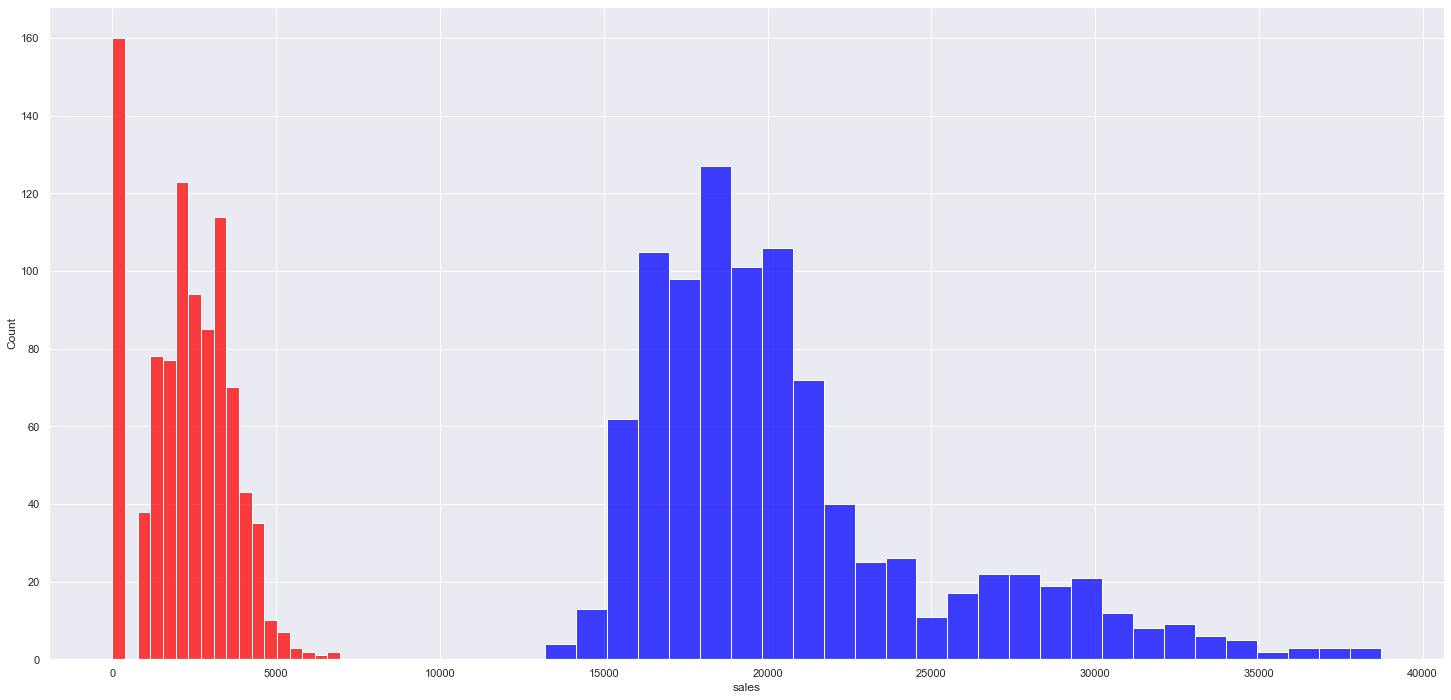

In [6]:
# BEST SELLING
sns.histplot(df4[df4['store'] == 262]['sales'], color='blue')
# WORST SELLING
sns.histplot(df4[df4['store'] == 307]['sales'], color='red')

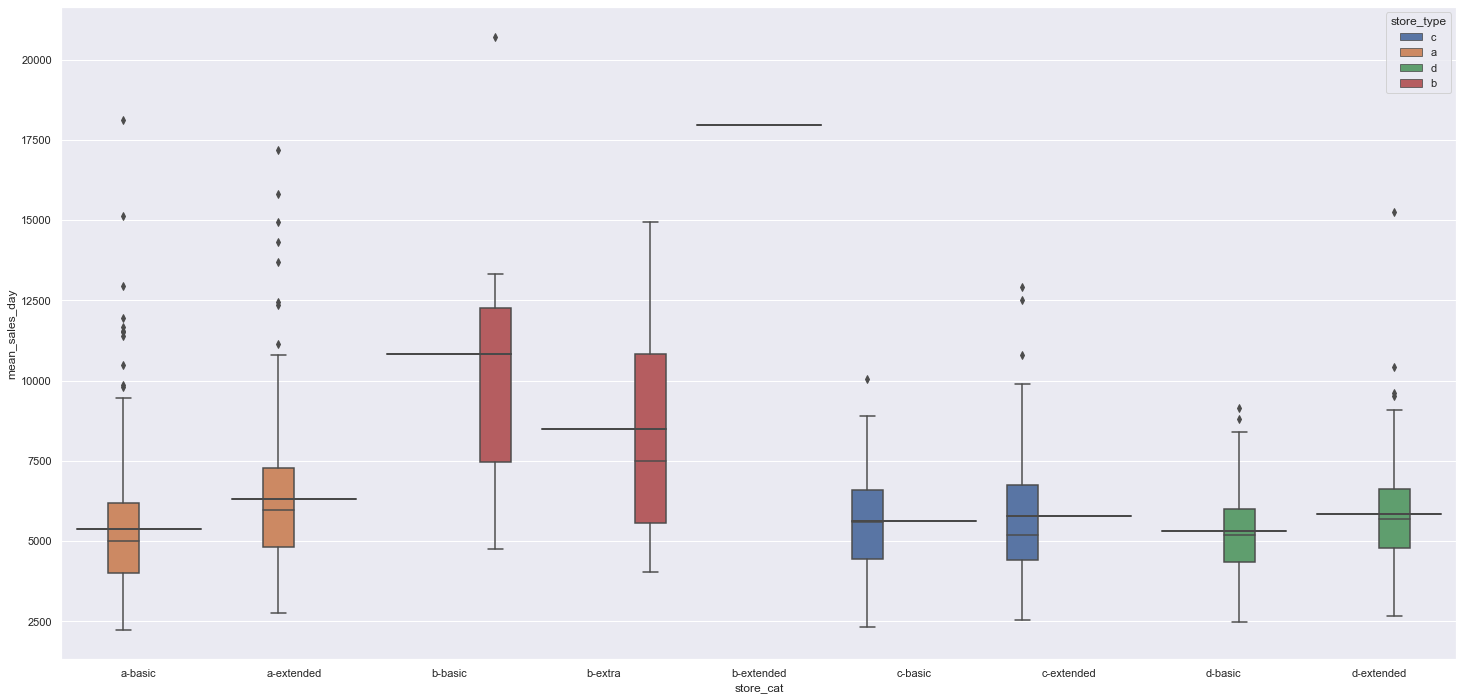

In [113]:
order = ['a-basic', 'a-extended',
         'b-basic', 'b-extra', 'b-extended', 
         'c-basic', 'c-extended', 
         'd-basic', 'd-extended']
aux1_m = aux1[['store_cat', 'assortment', 'mean_sales_day']].groupby(['store_cat', 'assortment']).mean().reset_index()
sns.boxplot(data=aux1, x='store_cat',y='mean_sales_day', hue='store_type', order=order);
sns.boxplot(data=aux1_m, x='store_cat',y='mean_sales_day', order=order, linewidth=2);

In [116]:
a = aux1_m.groupby('assortment').mean()
a['std'] = aux1_m.groupby('assortment').std()
a

mean_sales_day          std
assortment                             
basic          6789.858344  2691.516478
extended       8975.017669  6001.013140
extra          8485.838783          NaN

#### H2. CUSTOMERS x SALES - Stores with a highest number of customer have the max selling value. - LOW

**FALSE:** It is not the first, but the second place have the highest selling value. There is a linear positive correlation and the range(total of customers) vary between stores type x assortment.

Store Type B have the most visit/week, and the lowest is Store Type D.


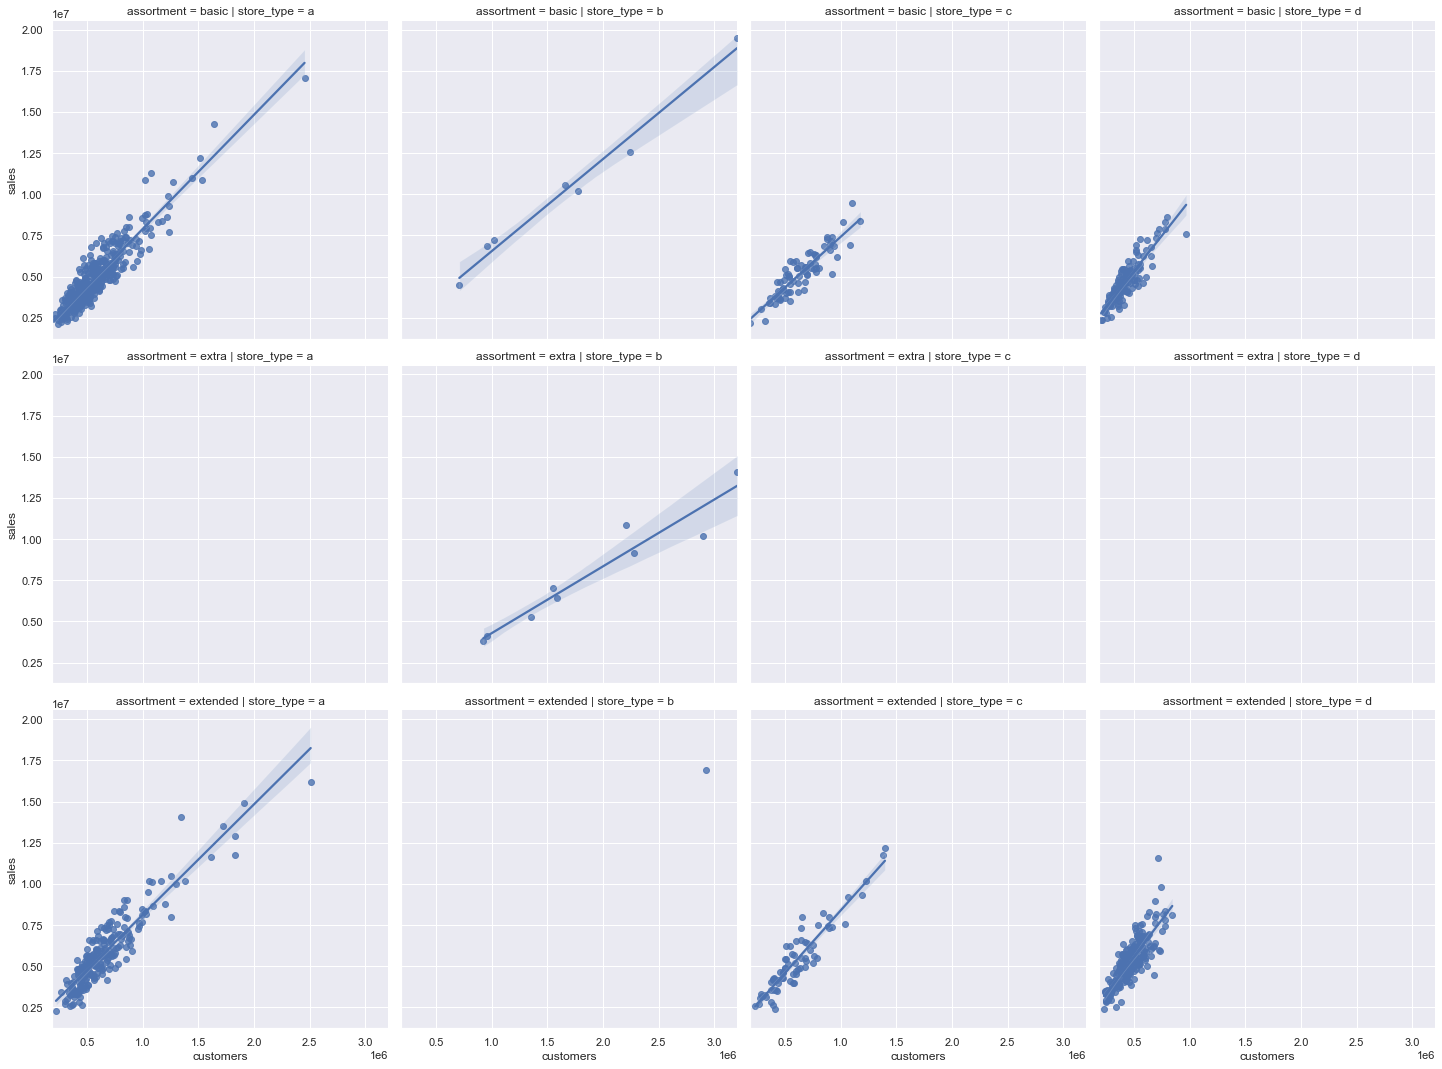

In [117]:
aux1 = df4[['store', 'sales', 'customers', 'assortment', 'store_type']].groupby(['store', 'assortment', 'store_type']).sum().reset_index().sort_values('customers', ascending=False)
sns.lmplot(x="customers", y="sales", data=aux1, col='store_type', row='assortment', col_order=['a', 'b', 'c', 'd'], row_order=['basic', 'extra', 'extended'])

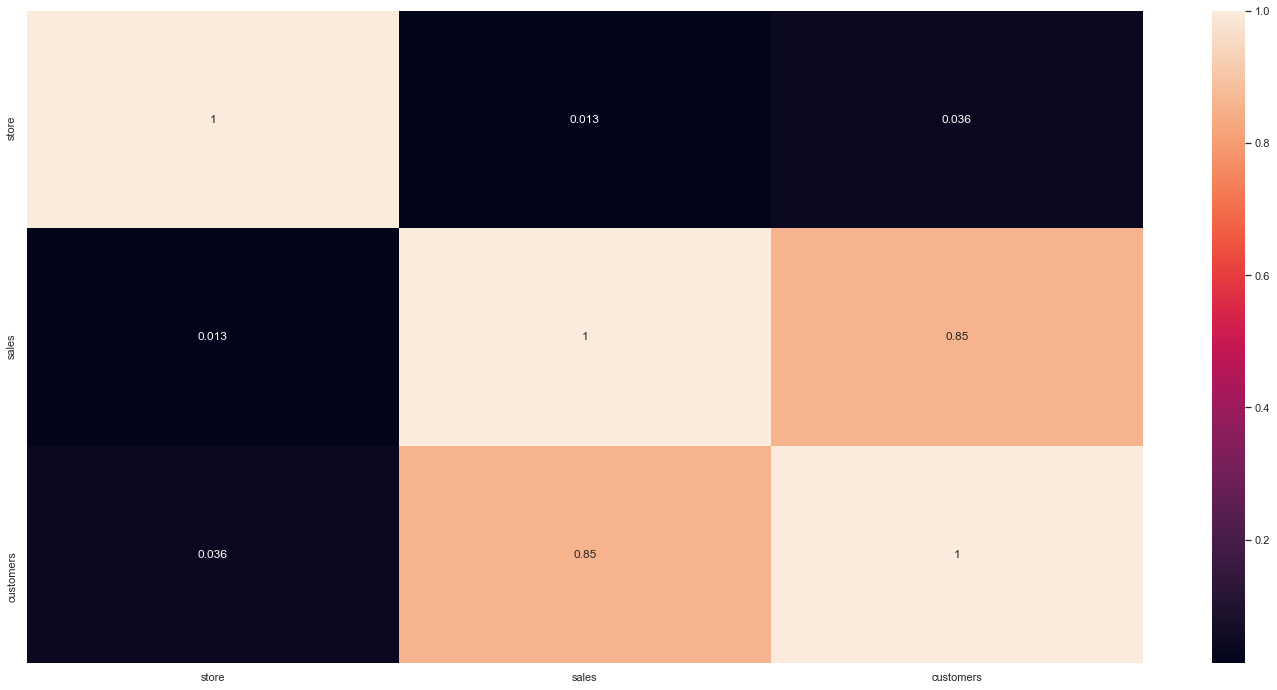

In [118]:
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [14]:
aux1.max()

store             1115
assortment       extra
store_type           d
sales         19516842
customers      3206058
dtype: object

In [15]:
aux1

store assortment store_type     sales  customers
732     733      extra          b  14067158    3206058
261     262      basic          b  19516842    3204694
561     562   extended          b  16927322    2924960
768     769      extra          b  10198000    2902351
1113   1114   extended          a  16202585    2509542
816     817      basic          a  17057867    2454370
1096   1097      extra          b   9179413    2280508
334     335      basic          b  12541731    2246936
258     259      extra          b  10851871    2210980
250     251   extended          a  14896870    1908934
585     586   extended          a  11742401    1832458
755     756   extended          a  12911782    1827980
422     423      basic          b  10200356    1776735
382     383   extended          a  13489879    1720249
681     682      basic          b  10557379    1656830
512     513      basic          a  14252406    1643527
319     320   extended          a  11630218    1617489
947     948      extra          b   6437314    1589133
675     676      extra          b   7057092    1549211
335     336      basic          a  10850316    1529043
697     698      basic          a  12202270    1518304
543     544      basic          a  10993709    1439156
522     523   extended          c  12175995    1397803
594     595   extended          c  11774982    1382516
469     470   extended          a  10174712    1377377
352     353      extra          b   5255773    1349510
787     788   extended          a  14082141    1346835
826     827   extended          a  10000214    1302475
545     546      basic          a  10726323    1271083
466     467   extended          a  10501035    1257034
579     580   extended          a   7994967    1256554
721     722      basic          a   7711931    1241124
124     125      basic          a   9280089    1233970
830     831      basic          a   9884733    1228453
559     560   extended          c  10168806    1225287
431     432      basic          a   8610571    1218907
448     449   extended          a   8789176    1198781
468     469   extended          c   9330742    1192174
24       25      basic          c   8376557    1177772
501     502      basic          a   8377408    1176212
210     211   extended          a  10187567    1164871
525     526      basic          a   8312841    1139140
443     444      basic          c   9470625    1105765
415     416   extended          a   8633413    1096337
83       84   extended          a  10092722    1084610
671     672      basic          c   6892942    1083587
963     964      basic          a   7534699    1077174
379     380      basic          a  11261676    1075375
982     983      basic          a   7941077    1068066
1017   1018   extended          c   9187204    1063112
767     768   extended          a  10185601    1054827
444     445      basic          a   6673717    1052928
1013   1014   extended          a   9509102    1051375
478     479      basic          a   8782548    1039144
3         4   extended          c   7556507    1036254
1026   1027   extended          a   8163847    1032892
644     645      basic          a   8337410    1031306
103     104      basic          a   7939205    1028904
463     464      basic          c   8343864    1023585
712     713   extended          a   8349365    1023424
206     207      basic          a   8768418    1019499
1032   1033      basic          a  10870270    1018597
708     709      basic          a   7751342    1017426
493     494      basic          b   7205637    1016989
194     195   extended          a   8345567    1011485
531     532   extended          a   8487100     996269
332     333   extended          a   7662181     993414
905     906      basic          a   8535775     992530
388     389   extended          a   8104523     992082
904     905      basic          a   6645066     987344
664     665      basic          a   6360621     975872
973     974      basic          a   7178474   

###### CUSTOMERS VS STORE_TYPE

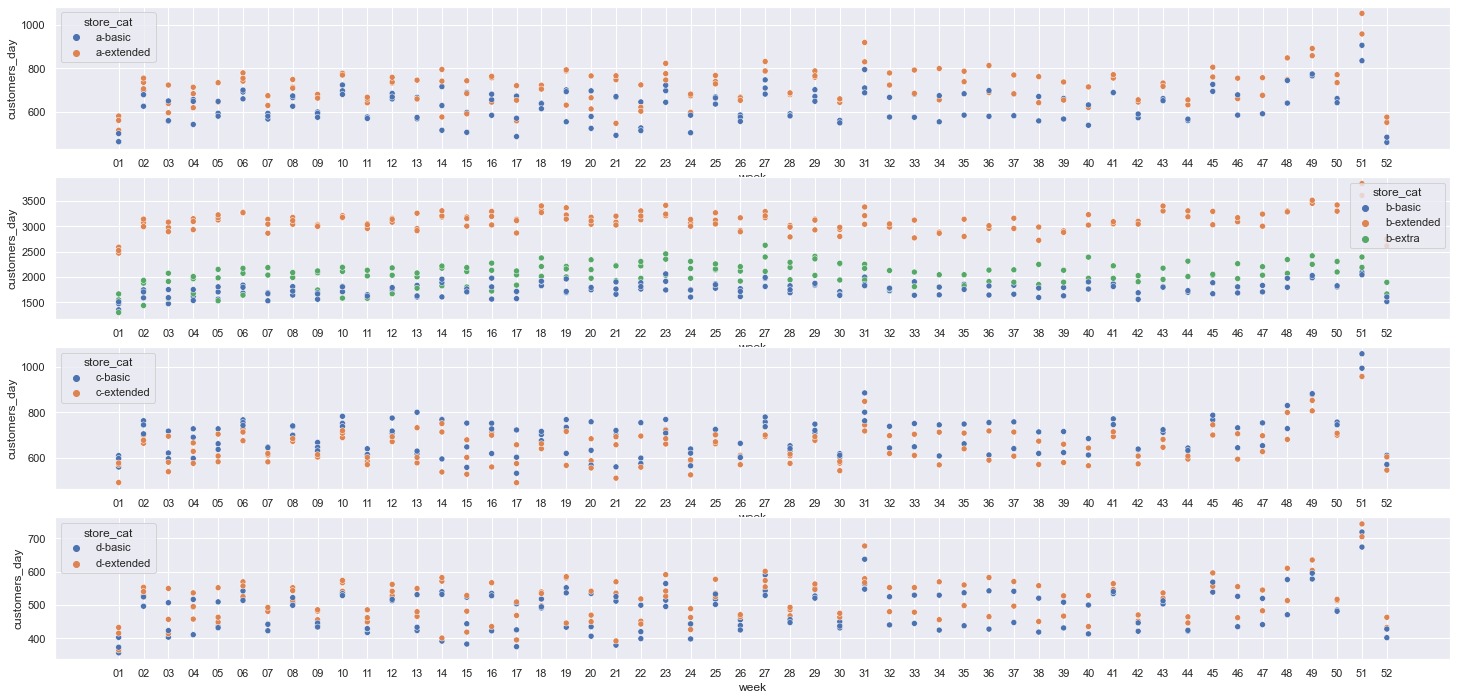

In [136]:
aux1 = df4[['customers', 'week_of_year', 'store_cat']].groupby(['week_of_year', 'store_cat']).sum().reset_index()
aux1['stores_t'] = df4[['customers', 'week_of_year', 'store_cat']].groupby(['week_of_year', 'store_cat']).count().reset_index()['customers']
aux1['customers_day'] = aux1['customers']/aux1['stores_t']
aux1['year'] = aux1['week_of_year'].apply(lambda x: x.split('/')[0])
aux1['week'] = aux1['week_of_year'].apply(lambda x: x.split('/')[1])
aux1['semester'] = aux1['week'].apply(lambda x: '01' if int(x) < 7 else '02')
aux1['semester_year'] = aux1['year'] + '/' + aux1['semester']

st_a = ['a-extended', 'a-basic']
st_b = ['b-extended', 'b-extra', 'b-basic']
st_c = ['c-extended', 'c-basic']
st_d = ['d-extended', 'd-basic']
aux_a = aux1[aux1['store_cat'].isin(st_a)]
aux_b = aux1[aux1['store_cat'].isin(st_b)]
aux_c = aux1[aux1['store_cat'].isin(st_c)]
aux_d = aux1[aux1['store_cat'].isin(st_d)]

plt, axes = plt.subplots(4, 1)
a = sns.scatterplot(data=aux_a, x='week', y='customers_day', hue='store_cat', ax=axes[0])
sns.scatterplot(data=aux_b, x='week', y='customers_day', hue='store_cat', ax=axes[1])
sns.scatterplot(data=aux_c, x='week', y='customers_day', hue='store_cat', ax=axes[2])
sns.scatterplot(data=aux_d, x='week', y='customers_day', hue='store_cat', ax=axes[3]);

#### **H3.** COMPETITION DISTANCE x SALES - Stores with closest competitors should sell less. - HIGH

**FALSE:** Stores with closest competitors sells are higher.

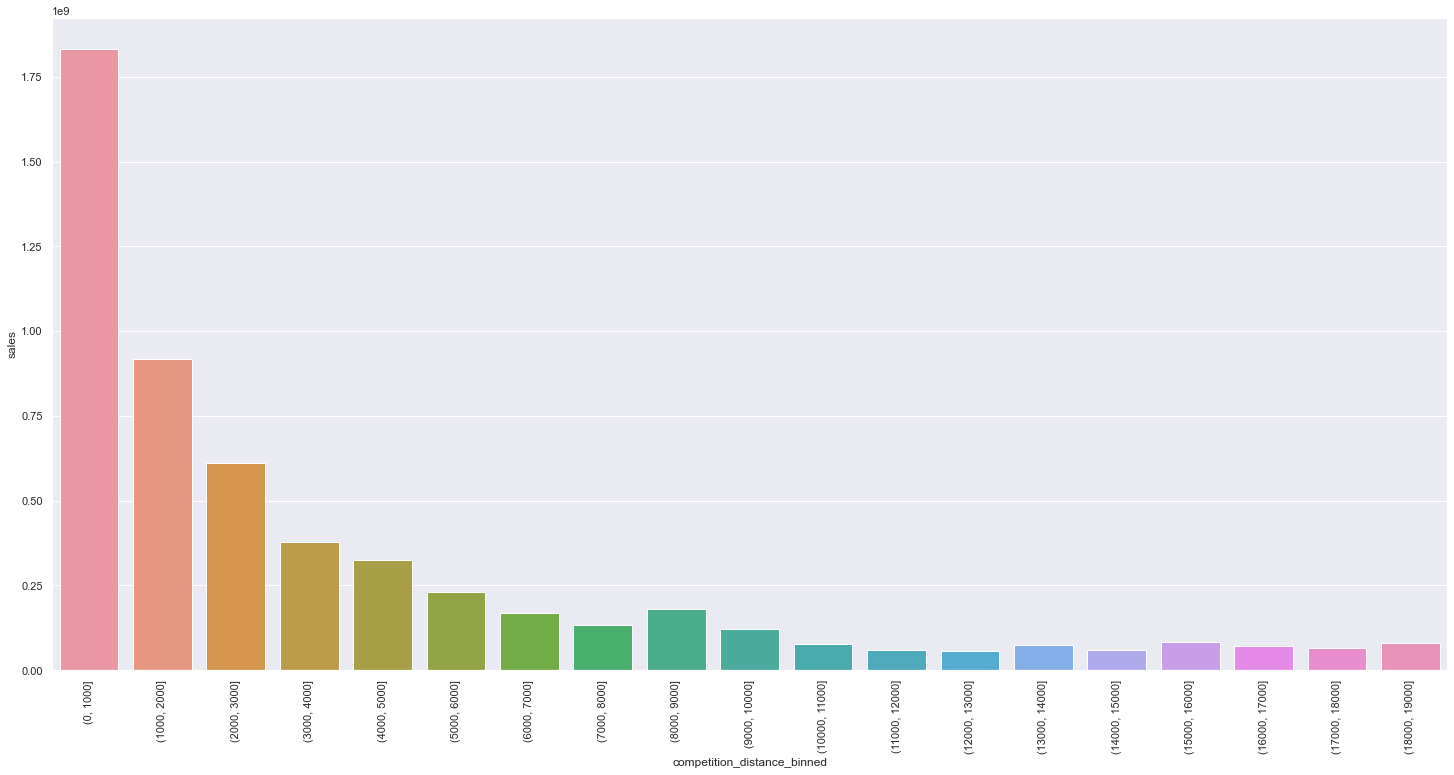

In [155]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

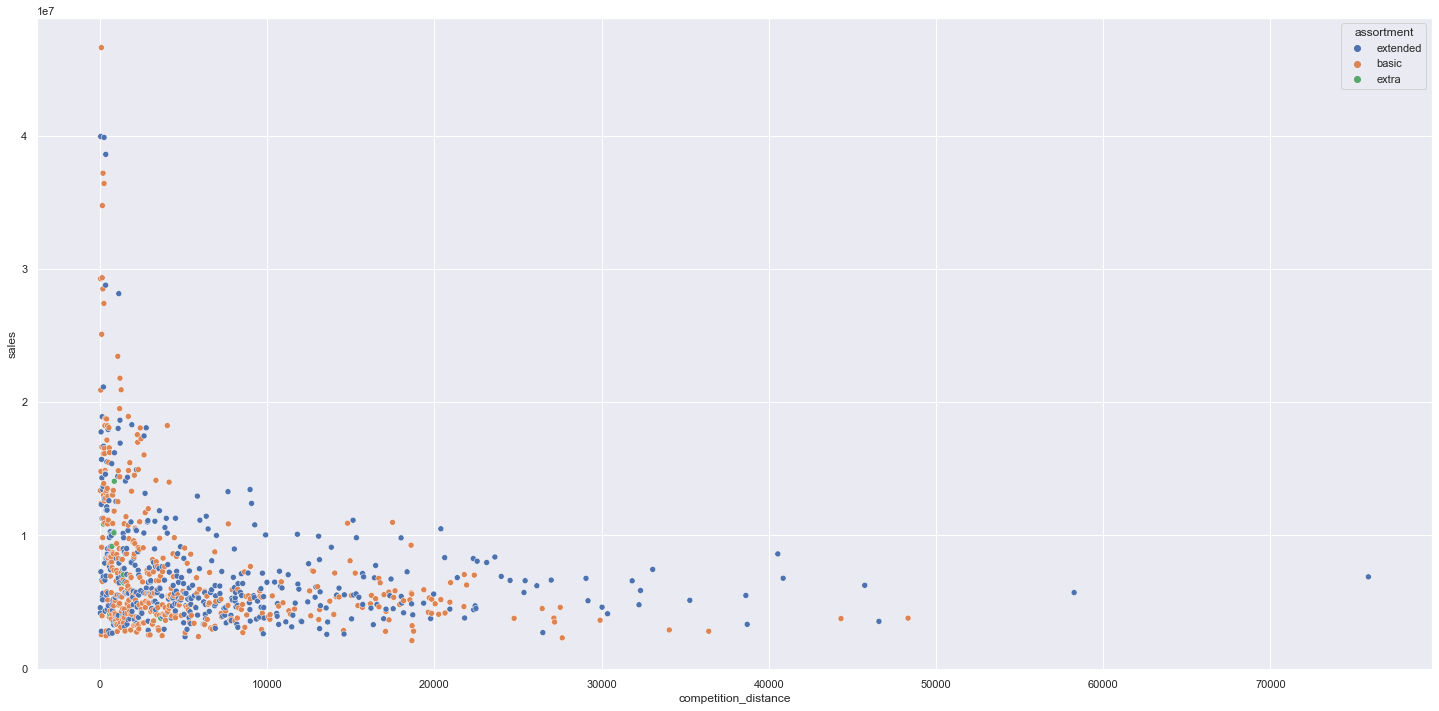

In [85]:
aux1 = df4[['competition_distance', 'sales', 'assortment']].groupby(['competition_distance', 'assortment']).sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1, hue='assortment');

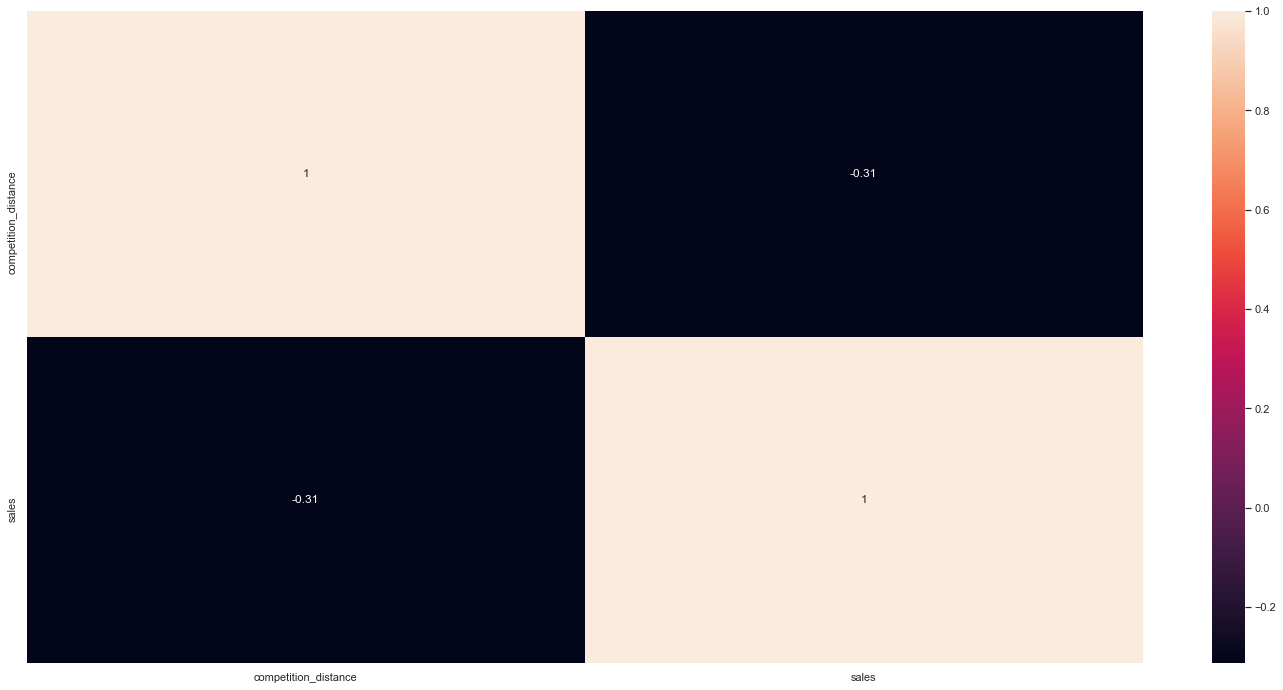

In [51]:
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.show()

##### DISTANCE COMPETITION + STORE TYPE / ASSORTMENT vs SALES

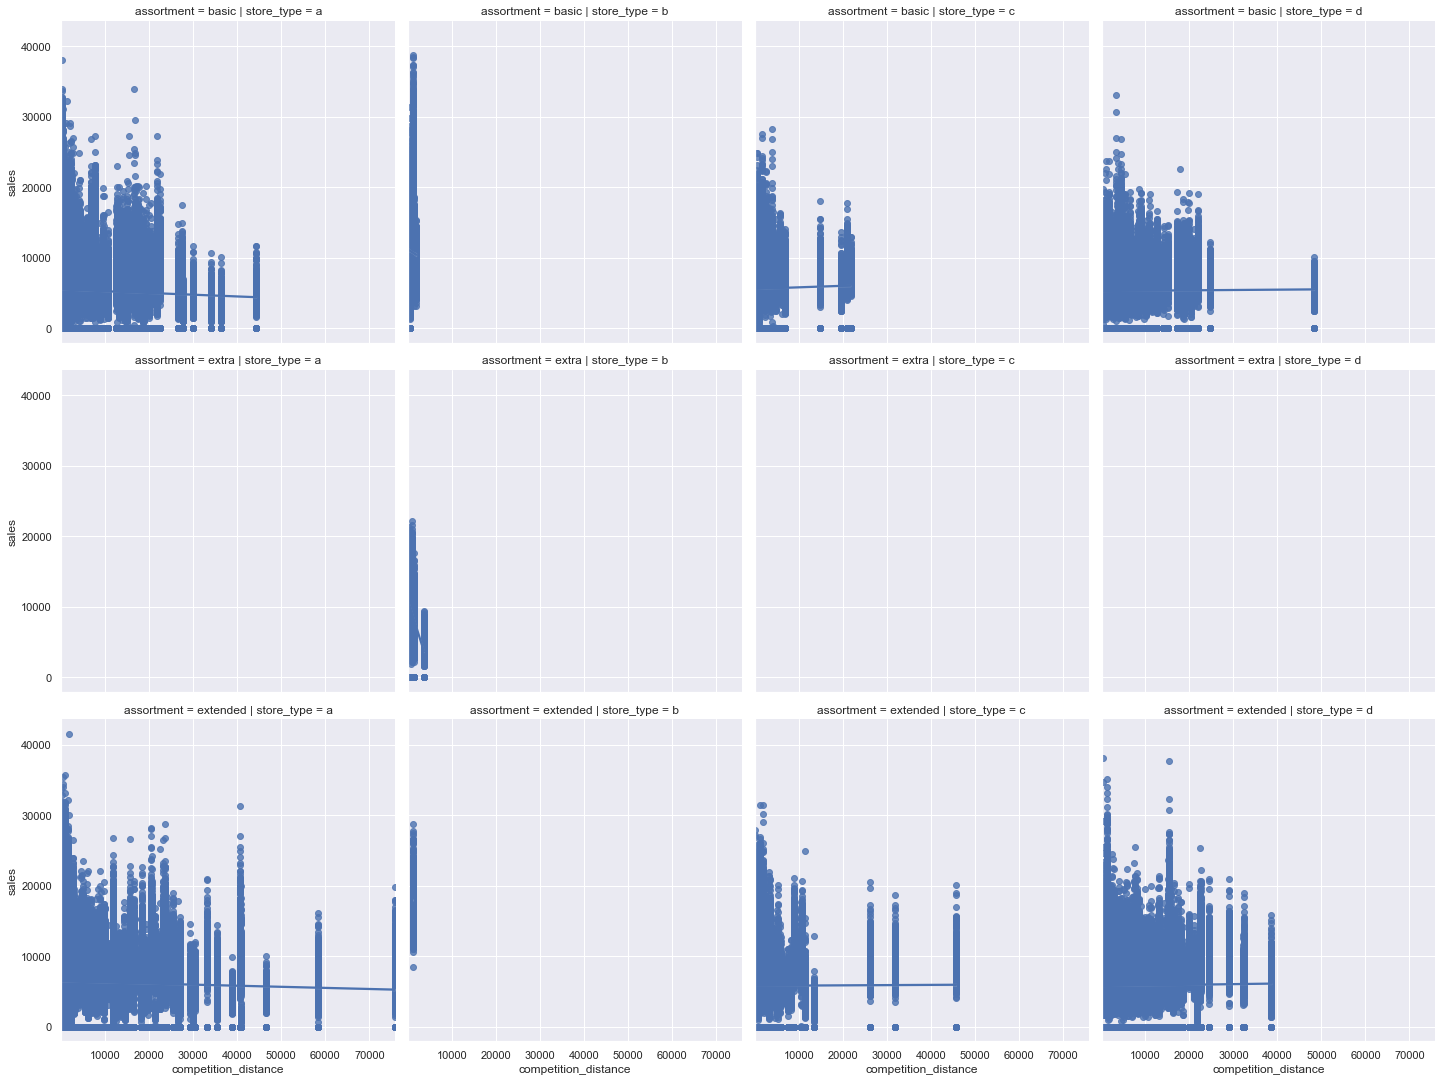

In [80]:
sns.lmplot(x="competition_distance", y="sales", data=df4, col='store_type', row='assortment', col_order=['a', 'b', 'c', 'd'], row_order=['basic', 'extra', 'extended'])

#### **H4.** COMPETITION TIME DAYS x SALES - Stores with competitors for long period should sell more. - LOW

**FALSE:** Stores with competitors for long period sell less.

In [176]:
df2['competition_open_since_year'].unique()

array([2008, 2007, 2006, 2009, 2015, 2013, 2014, 2000, 2011, 2010, 2005,
       1999, 2003, 2012, 2004, 2002, 1961, 1995, 2001, 1990, 1994, 1900,
       1998], dtype=int64)

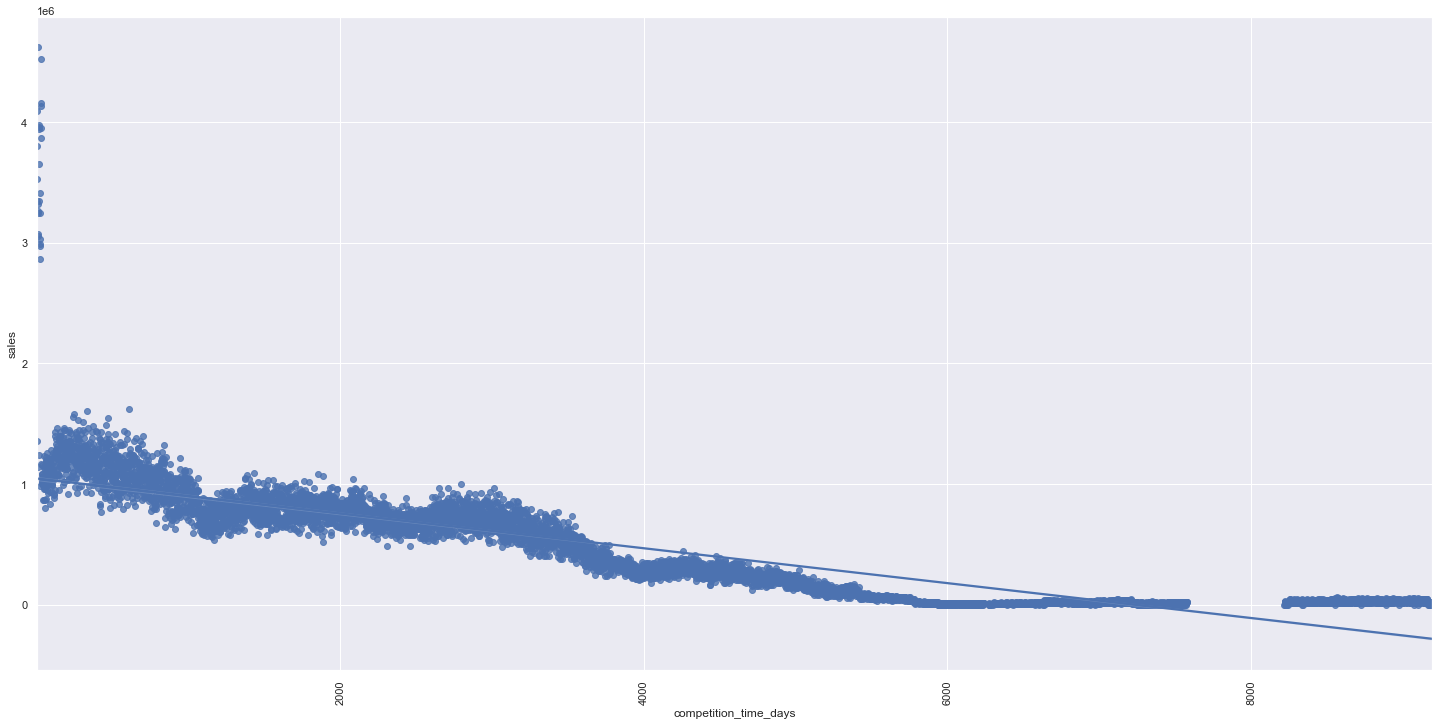

In [34]:
aux1 = df4[['competition_time_days', 'sales']].groupby('competition_time_days').sum().reset_index()
aux2 = aux1[(aux1['competition_time_days'] < 10000) & (aux1['competition_time_days'] !=0)]
sns.regplot(x='competition_time_days', y='sales', data=aux2);
plt.xticks(rotation=90);

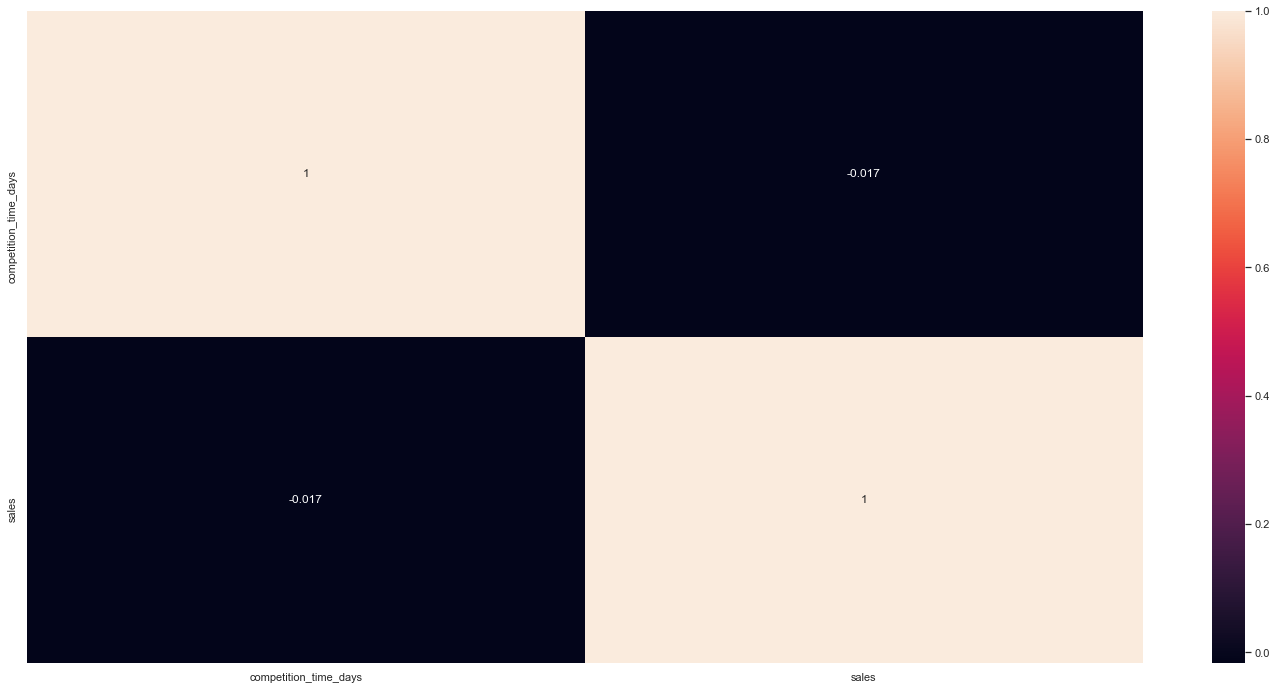

In [161]:
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

#### **H5.** PROMO2_ON / PROMO x SALES - Stores with extended promo should sell more, compared to regular promo. - HIGH

**FALSE:**  Promo 2 (extended promo) does not sell more.

<AxesSubplot:xlabel='promo', ylabel='sales'>

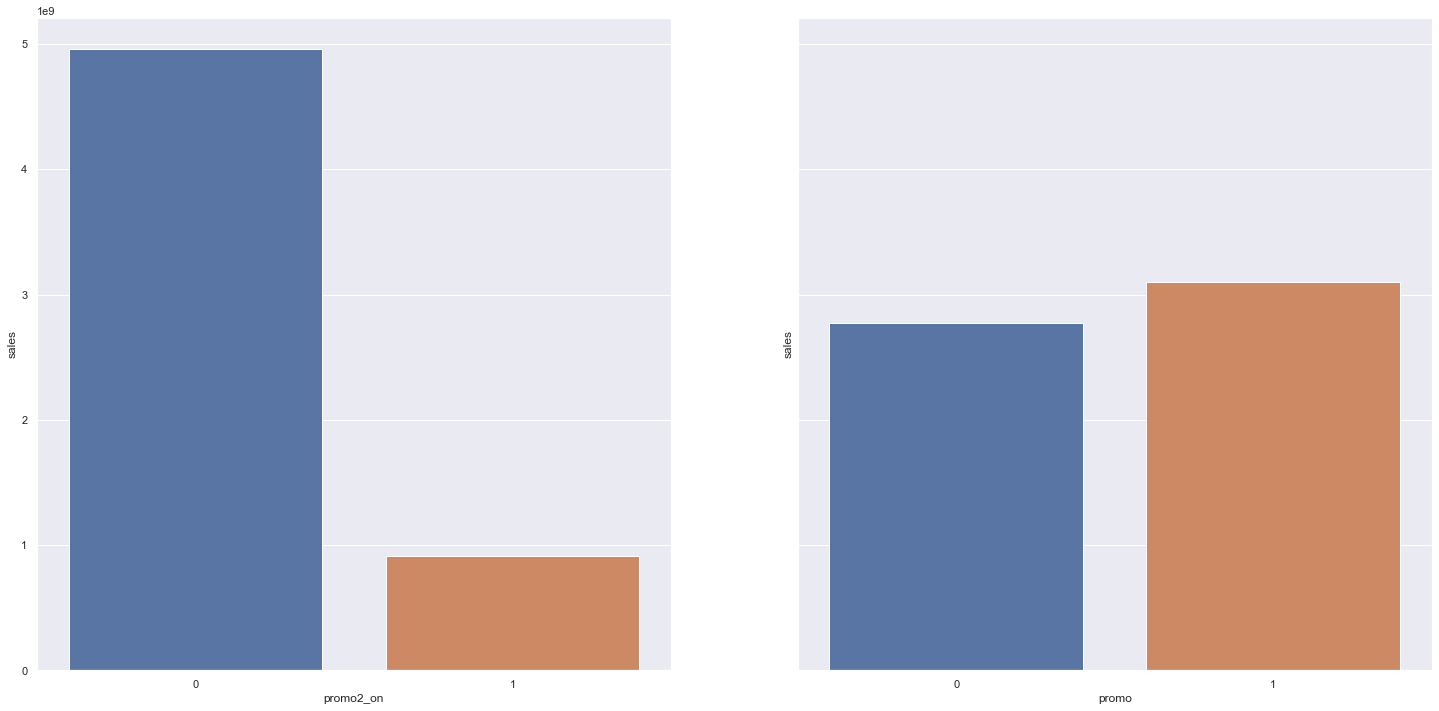

In [141]:
aux1 = df4[['promo2_on', 'sales']].groupby('promo2_on').sum().reset_index() #extended promo
aux2 = df4[['promo', 'sales']].groupby('promo').sum().reset_index() # regular promo

fig, axes = plt.subplots(1, 2, sharey=True)
sns.barplot(data=aux1, x='promo2_on', y='sales', ax=axes[0])
sns.barplot(data=aux2, x='promo', y='sales', ax=axes[1])

<AxesSubplot:>

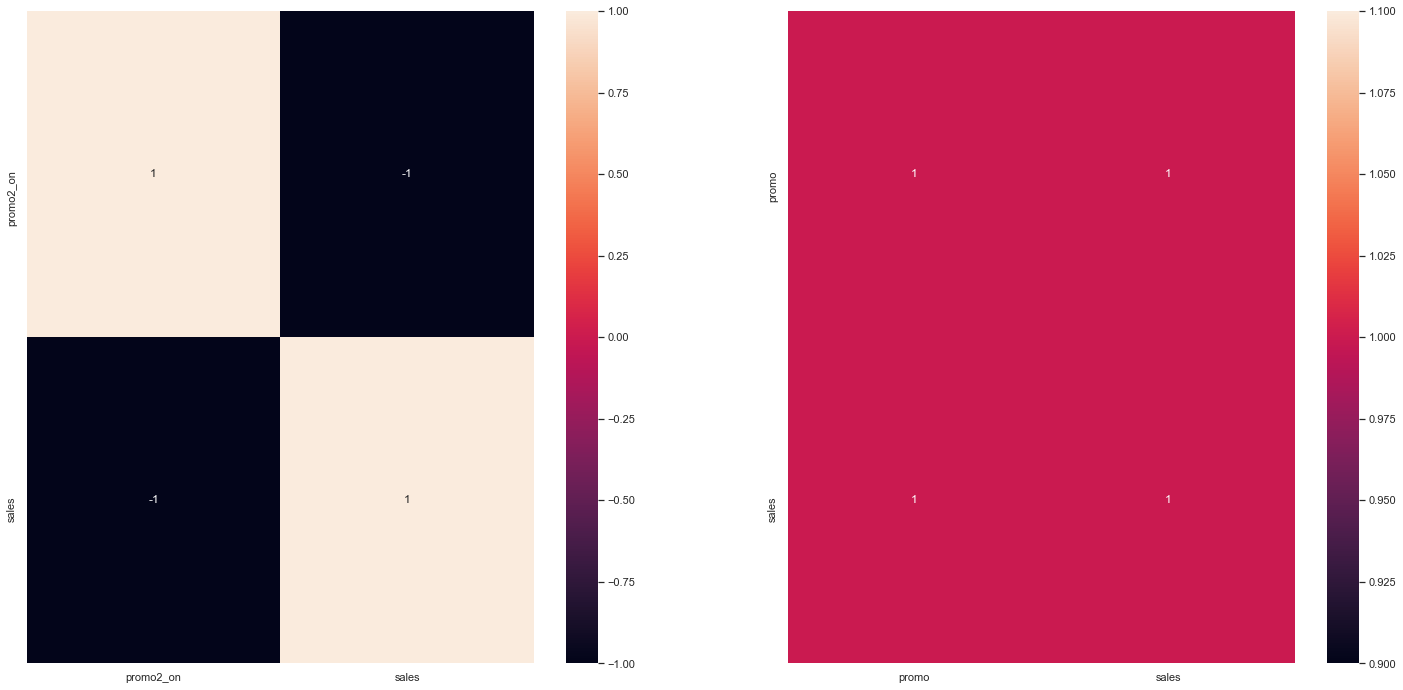

In [144]:
fig, axes = plt.subplots(1, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=axes[0])
sns.heatmap(aux2.corr(method='pearson'), annot=True, ax=axes[1])

#### **H6.** PROMO + PROMO2_ON x SALE - Stores with consecutive promos should sell more. - MEDIUM

**FALSE:** Regular promos sell more than combining promo extended (promo2_on)

<AxesSubplot:xlabel='total_promo', ylabel='sales'>

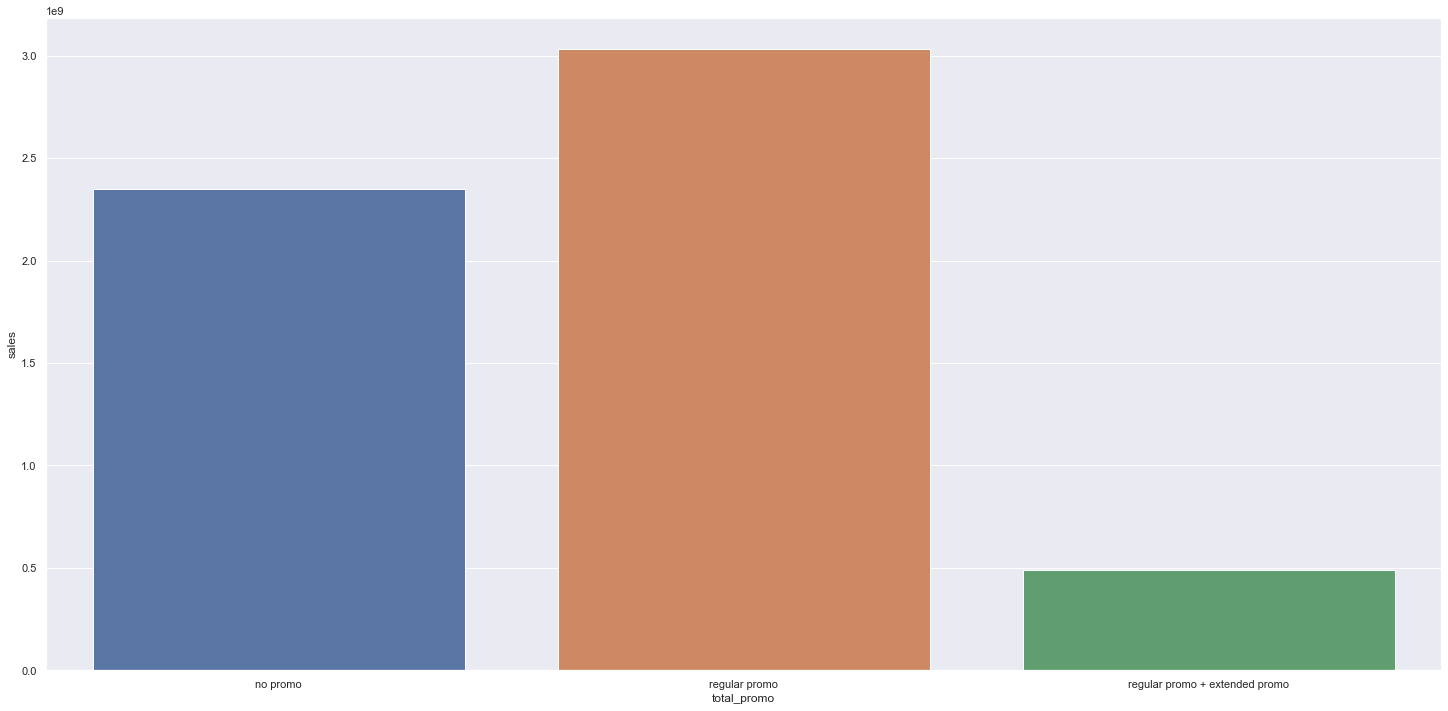

In [147]:
aux1 = df4.copy()
aux1['total_promo'] = df4['promo'] + df4['promo2_on']
promo_map = {0:'no promo', 1: 'regular promo', 2: 'regular promo + extended promo'}
aux1['total_promo'] = aux1['total_promo'].map(promo_map)
aux2 = aux1[['total_promo', 'sales']].groupby('total_promo').sum().reset_index()
sns.barplot(data=aux2, x='total_promo', y='sales')

#### **H7.** STATE HOLIDAY x SALES - Stores should sell more on Christmas. - LOW

**FALSE:** Christmas holiday sells less than the others

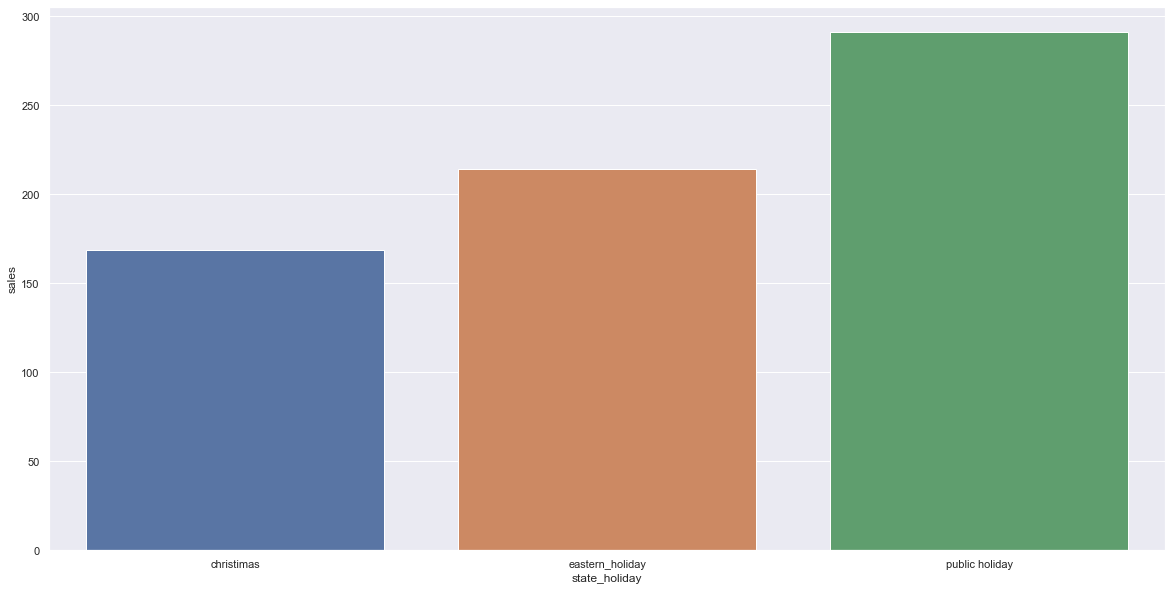

In [223]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
plt.figure(figsize=(20, 10))
sns.barplot(x='state_holiday', y='sales', data=aux1);
plt.show()

#### **H8.** YEAR x SALES - Stores should perform better through time. - MEDIUM

**TRUE:** Stores perform better through time*

##### WRONG GRAPH - WITH MISSING PERIOD

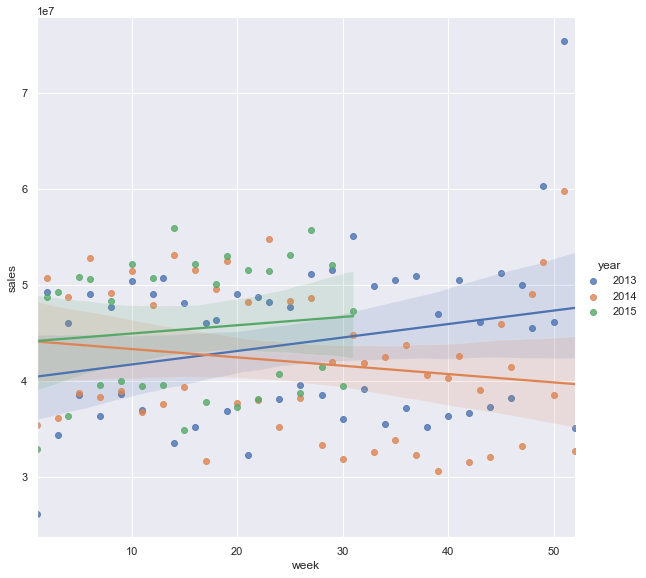

In [149]:
aux2013 = df4[df4['date'].dt.isocalendar().year == 2013]
a2013 = aux2013[['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
week = np.arange(1, len(a2013)+1).tolist()
a2013['week'] = week
a2013['year'] = 2013

aux2014 = df4[df4['date'].dt.isocalendar().year == 2014]
a2014 = aux2014[['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
week = np.arange(1, len(a2014)+1).tolist()
a2014['week'] = week
a2014['year'] = 2014

aux2015 = df4[df4['date'].dt.isocalendar().year == 2015]
a2015 = aux2015[['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
week = np.arange(1, len(a2015)+1).tolist()
a2015['week'] = week
a2015['year'] = 2015

total = pd.concat([a2013, a2014, a2015], axis=0)

sns.lmplot(x='week', y='sales', data=total, hue='year', height=8);
# we would say that 2014 the sales were worst comparing the other years, but there is missing data of 1 semester of 2014.

##### Find the missing stores

In [375]:
x = df4[['date','store']].groupby('date').count().reset_index()
# between 2014/07/01 to 2014/12/31 there is missing data from 180 stores
x = x[x['store'] == 935]['date'] #total stores missing

df_t = pd.DataFrame()
for i in x.tolist():
    a = df4[df4['date'] == i]
    df_t = pd.concat([df_t, pd.Series(a['store'].unique())], axis=1)
    
df_t.columns = x.tolist()
df_t_t = df_t.copy().T
df_t_t['soma'] = df_t_t.sum(axis=1)

In [377]:
#verifing if there is some stores diferences between the days.
df_t_t['soma']

2014-07-01    524108
2014-07-02    524108
2014-07-03    524108
2014-07-04    524108
2014-07-05    524108
2014-07-06    524108
2014-07-07    524108
2014-07-08    524108
2014-07-09    524108
2014-07-10    524108
2014-07-11    524108
2014-07-12    524108
2014-07-13    524108
2014-07-14    524108
2014-07-15    524108
2014-07-16    524108
2014-07-17    524108
2014-07-18    524108
2014-07-19    524108
2014-07-20    524108
2014-07-21    524108
2014-07-22    524108
2014-07-23    524108
2014-07-24    524108
2014-07-25    524108
2014-07-26    524108
2014-07-27    524108
2014-07-28    524108
2014-07-29    524108
2014-07-30    524108
2014-07-31    524108
2014-08-01    524108
2014-08-02    524108
2014-08-03    524108
2014-08-04    524108
2014-08-05    524108
2014-08-06    524108
2014-08-07    524108
2014-08-08    524108
2014-08-09    524108
2014-08-10    524108
2014-08-11    524108
2014-08-12    524108
2014-08-13    524108
2014-08-14    524108
2014-08-15    524108
2014-08-16    524108
2014-08-17   

In [381]:
stores_selected = df_t_t.iloc[0,:-1].tolist()

##### CORRECTED GRAPH - REMOVED STORES WITH MISSING DATA

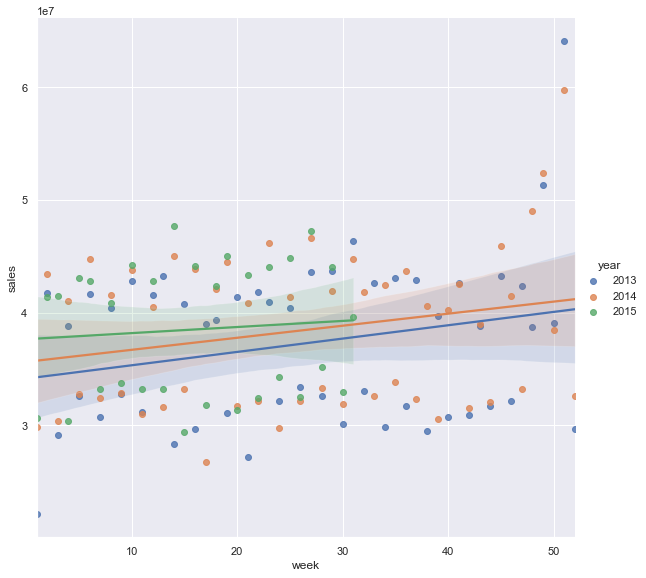

In [389]:
df4_selected = df4[df4['store'].isin(stores_selected)]

aux2013 = df4_selected[df4_selected['date'].dt.isocalendar().year == 2013]
a2013 = aux2013[['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
week = np.arange(1, len(a2013)+1).tolist()
a2013['week'] = week
a2013['year'] = 2013

aux2014 = df4_selected[df4_selected['date'].dt.isocalendar().year == 2014]
a2014 = aux2014[['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
week = np.arange(1, len(a2014)+1).tolist()
a2014['week'] = week
a2014['year'] = 2014

aux2015 = df4_selected[df4_selected['date'].dt.isocalendar().year == 2015]
a2015 = aux2015[['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
week = np.arange(1, len(a2015)+1).tolist()
a2015['week'] = week
a2015['year'] = 2015

total = pd.concat([a2013, a2014, a2015], axis=0)

sns.lmplot(x='week', y='sales', data=total, hue='year', height=8);

#### **H9.** DAY OF WEEK x SALES - Stores should sell less on weekend.  - LOW

**TRUE:** Stores sell less on weekend.

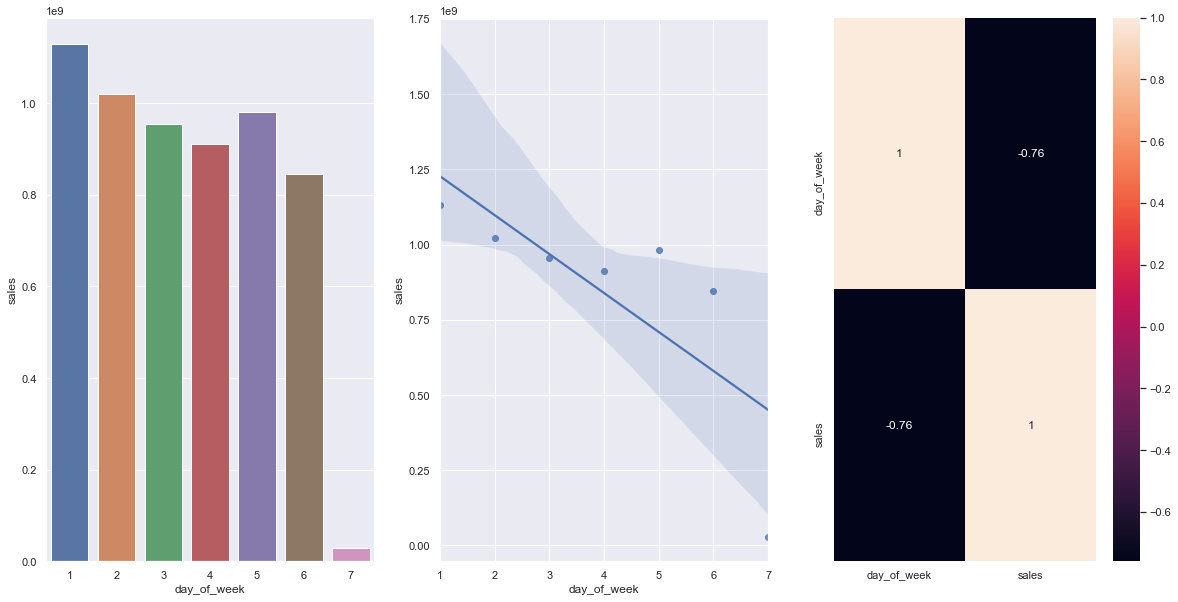

In [150]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.show()

# IT HAPPENS BECAUSE MOST OF STORES ARE CLOSED ON SUNDAY

#### **H10.** SCHOOL HOLIDAY x SALES - Stores should sell less during schools holidays. - LOW

**TRUE:** Stores should sell less during schools holidays, except on July and August.

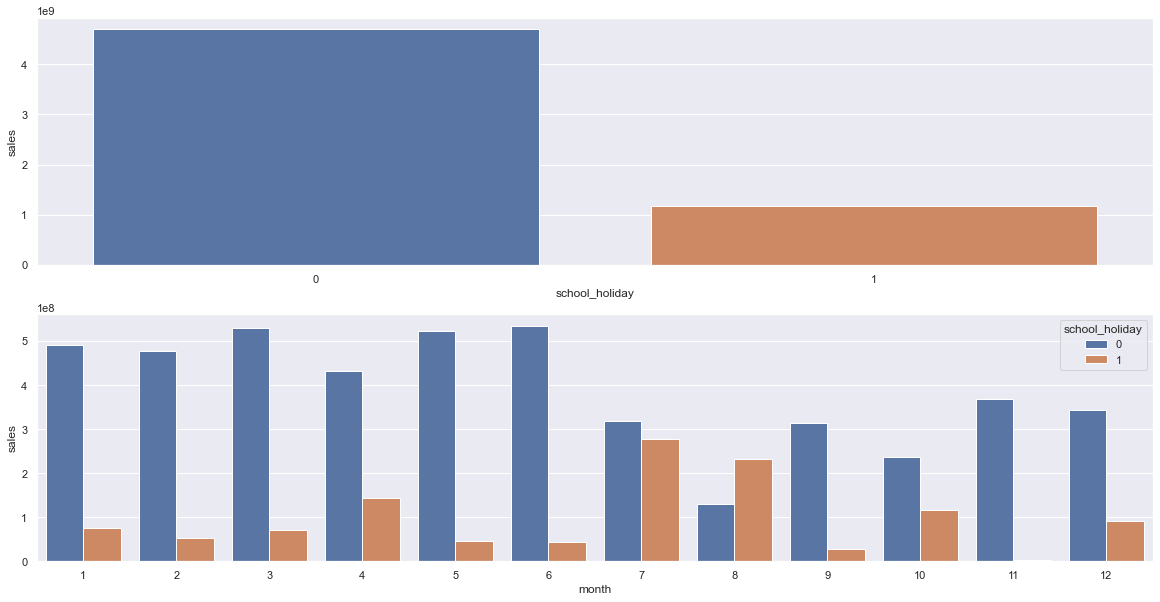

In [394]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday',data=aux2)
plt.show()

#### **H11.**OPEN x SALES - Stores open with no sells, should have open on school holiday / holidays. - LOW

**FALSE:** There is nothing can be explained why there is no sell when stores are open with no sell. Everytime we got zero sells it was on regular day.

<AxesSubplot:xlabel='day_of_week', ylabel='sales'>

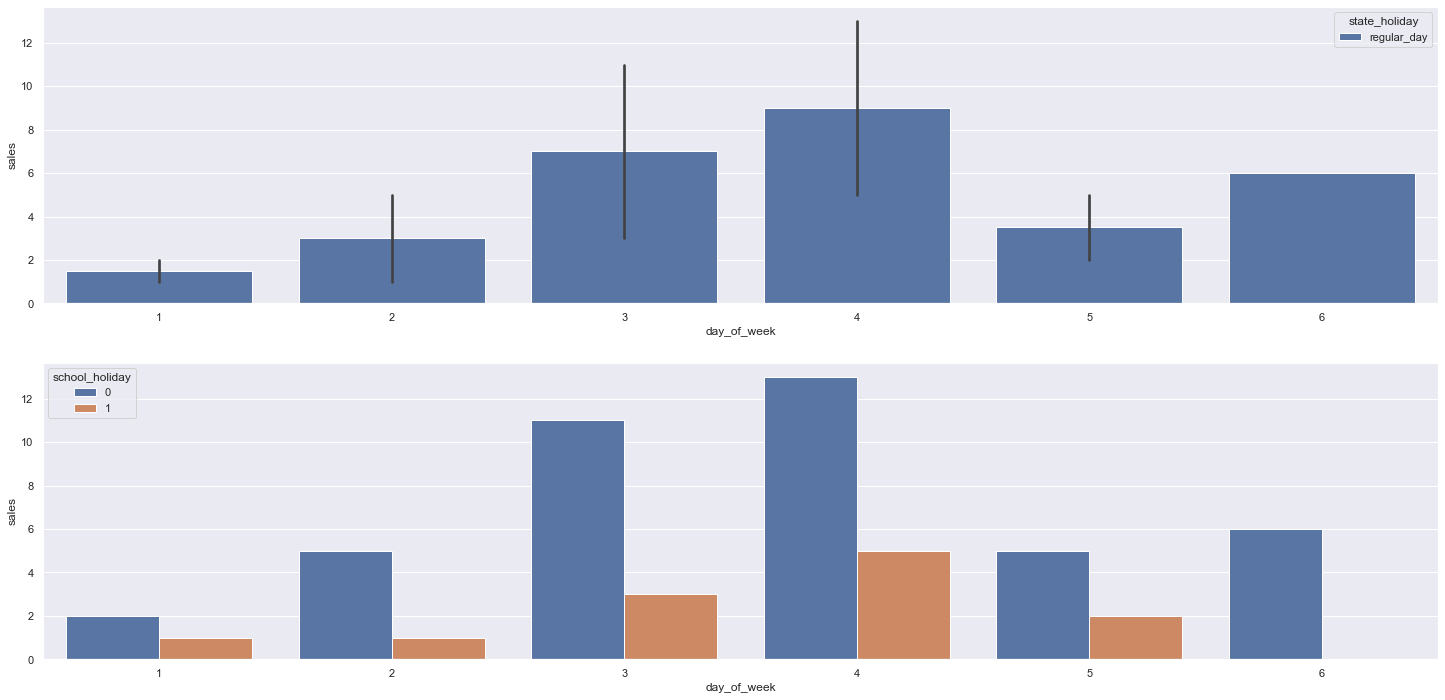

In [152]:
aux1 = df4[(df4['sales']==0) & df4['open']==1]
aux2 = aux1[['day_of_week', 'school_holiday', 'state_holiday', 'sales']].groupby(['day_of_week', 'school_holiday', 'state_holiday']).count().reset_index()
plt.subplot(2,1,1)
sns.barplot(data=aux2, x='day_of_week', y='sales', hue='state_holiday')

plt.subplot(2,1,2)
sns.barplot(data=aux2, x='day_of_week', y='sales', hue='school_holiday')

In [156]:
# Potential elimination of this misleading information
print('Total number of records with no sells when the store were open:', aux2['sales'].sum())

Total number of records with no sells when the store were open: 54


### 4.2.1 HYPOTHESES SUMMARY

In [148]:
tab = [['HYPTOTHESES', 'CONCLUSION', 'RELEVANCE', 'FEATURE'],
      ['H1', 'TRUE', 'HIGH', 'ASSORTMENT'],
      ['H2', 'FALSE', 'LOW', 'CUSTOMERS'], 
      ['H3', 'FALSE', 'HIGH', 'COMPETITION DISTANCE'],
      ['H4', 'FALSE', 'LOW', 'COMPETITION TIME DAYS'],
      ['H5', 'FALSE', 'HIGH', 'PROMO2_ON'],
      ['H6', 'FALSE', 'MEDIUM', 'PROMO + PROMO2_ON'], 
      ['H7', 'FALSE', 'LOW', 'STATE HOLIDAY'],
      ['H8', 'TRUE', 'MEDIUM', 'YEAR'],
      ['H9', 'TRUE', 'LOW', 'DAY OF WEEK'],
      ['H10', 'TRUE', 'LOW', 'SCHOOL HOLIDAY'],
      ['H11', 'FALSE', 'LOW', 'OPEN']
      ]
print(tabulate(tab, headers='firstrow'))

HYPTOTHESES    CONCLUSION    RELEVANCE    FEATURE
-------------  ------------  -----------  ---------------------
H1             TRUE          HIGH         ASSORTMENT
H2             FALSE         LOW          CUSTOMERS
H3             FALSE         HIGH         COMPETITION DISTANCE
H4             FALSE         LOW          COMPETITION TIME DAYS
H5             FALSE         HIGH         PROMO2_ON
H6             FALSE         MEDIUM       PROMO + PROMO2_ON
H7             FALSE         LOW          STATE HOLIDAY
H8             TRUE          MEDIUM       YEAR
H9             TRUE          LOW          DAY OF WEEK
H10            TRUE          LOW          SCHOOL HOLIDAY
H11            FALSE         LOW          OPEN


## 4.3. MULTIVARIABLE ANALYSIS

### 4.3.1. NUMERICAL ATTIBUTES

<AxesSubplot:>

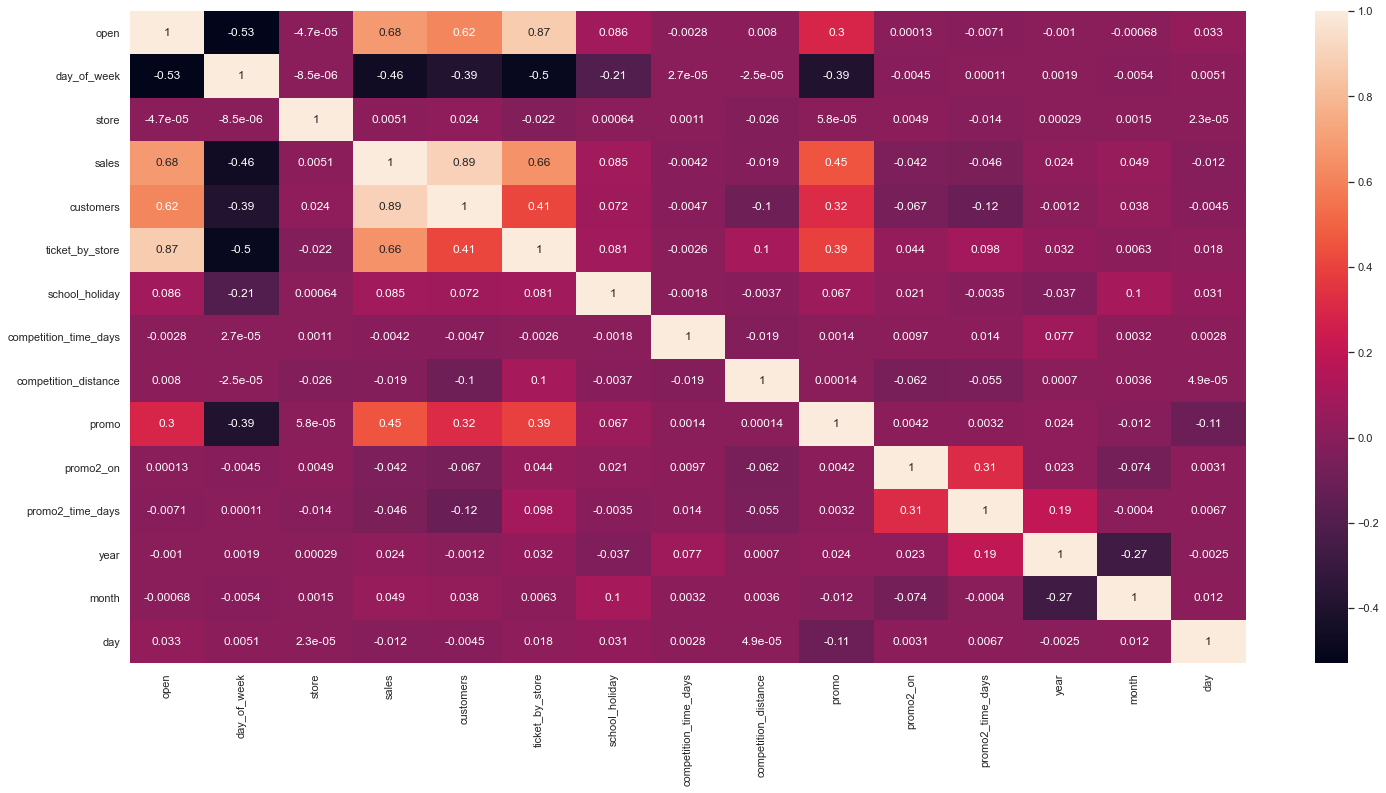

In [88]:
correlation = num_attributes.corr(method ='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2. CATEGORICAL ATTRIBUTES

In [408]:
a = df4.select_dtypes(include='object')
a.head()

store_type assortment   store_cat state_holiday week_of_year
0          c      basic     c-basic   regular_day      2015/31
1          a      basic     a-basic   regular_day      2015/31
2          a      basic     a-basic   regular_day      2015/31
3          c   extended  c-extended   regular_day      2015/31
4          a      basic     a-basic   regular_day      2015/31

<AxesSubplot:>

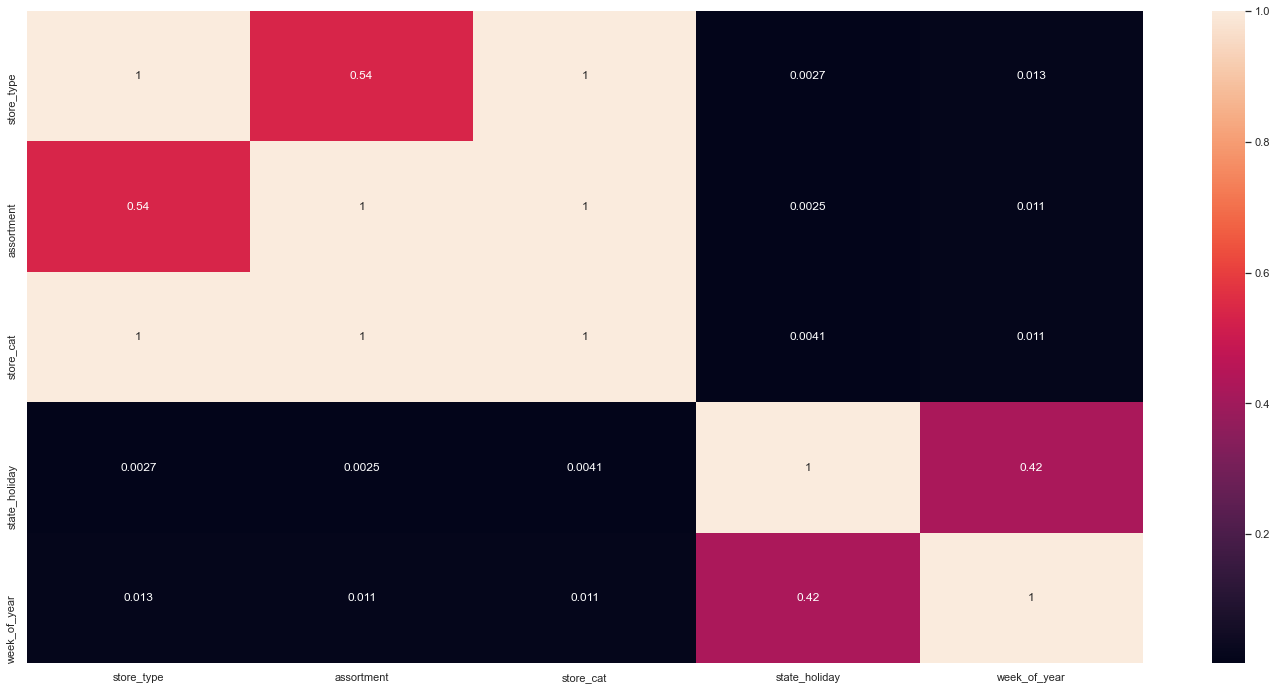

In [410]:
a1 = cramer_v(a['store_type'], a['store_type'])
a2 = cramer_v(a['store_type'], a['assortment'])
a3 = cramer_v(a['store_type'], a['store_cat'])
a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['week_of_year'])

a6 = cramer_v(a['assortment'],  a['store_type'])
a7 = cramer_v(a['assortment'],  a['assortment'])
a8 = cramer_v(a['assortment'],  a['store_cat'])
a9 = cramer_v(a['assortment'],  a['state_holiday'])
a10 = cramer_v(a['assortment'], a['week_of_year'])

a11 = cramer_v(a['store_cat'],  a['store_type'])
a12 = cramer_v(a['store_cat'],  a['assortment'])
a13 = cramer_v(a['store_cat'],  a['store_cat'])
a14 = cramer_v(a['store_cat'],  a['state_holiday'])
a15 = cramer_v(a['store_cat'], a['week_of_year'])

a16 = cramer_v(a['state_holiday'],  a['store_type'])
a17 = cramer_v(a['state_holiday'],  a['assortment'])
a18 = cramer_v(a['state_holiday'],  a['store_cat'])
a19 = cramer_v(a['state_holiday'],  a['state_holiday'])
a20 = cramer_v(a['state_holiday'], a['week_of_year'])

a21 = cramer_v(a['week_of_year'],  a['store_type'])
a22 = cramer_v(a['week_of_year'],  a['assortment'])
a23 = cramer_v(a['week_of_year'],  a['store_cat'])
a24 = cramer_v(a['week_of_year'],  a['state_holiday'])
a25 = cramer_v(a['week_of_year'], a['week_of_year'])

d = pd.DataFrame({'store_type' : [a1, a2, a3, a4, a5],
                  'assortment' : [a6, a7, a8, a9, a10],
                  'store_cat' : [a11, a12, a13, a14, a15],
                  'state_holiday' : [a16, a17, a18, a19, a20],
                  'week_of_year' : [a21, a22, a23, a24, a25]
                  })
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

In [176]:
df4.to_csv('dataset/C3/c03_04_rossman.csv', index=False)

# 5.0 DATA PREPARATION

In [178]:
df5 = pd.read_csv('dataset/C3/c03_04_rossman.csv')
df5['date'] = pd.to_datetime(df5['date'])
df5['school_holiday'] = df5['school_holiday'].astype('str')
df5['promo'] = df5['promo'].astype('str')
df5['promo2_on'] = df5['promo2_on'].astype('str')
df5.dtypes

date                     datetime64[ns]
open                              int64
day_of_week                       int64
store                             int64
store_type                       object
assortment                       object
store_cat                        object
sales                             int64
customers                         int64
state_holiday                    object
school_holiday                   object
competition_time_days             int64
competition_distance            float64
promo                            object
promo2_on                        object
promo2_time_days                  int64
year                              int64
month                             int64
day                               int64
week_of_year                     object
dtype: object

In [179]:
df5.shape

(1017209, 20)

### 5.0.0 REMOVING STORES OPEN WITH NO SELL

In [180]:
df5 = df5[~((df5['open']==1) & (df5['sales']==0))]
#df5 = df5.drop('open', axis=1)
df5.shape

(1017155, 20)

## 5.1. NORMALIZATION

In [ ]:
# No potential features for normalization  

## 5.2. RESCALLING

In [181]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.describe().T

count         mean          std     min     25%     50%     75%      max
open                   1017155.0     0.830098     0.375547     0.0     1.0     1.0     1.0      1.0
day_of_week            1017155.0     3.998356     1.997420     1.0     2.0     4.0     6.0      7.0
store                  1017155.0   558.428444   321.907787     1.0   280.0   558.0   838.0   1115.0
sales                  1017155.0  5774.125500  3849.798502     0.0  3728.0  5744.0  7856.0  41551.0
customers              1017155.0   633.179552   464.401158     0.0   405.0   609.0   837.0   7388.0
competition_time_days  1017155.0  1288.476275  1992.595970     0.0     0.0   510.0  2234.0  42214.0
competition_distance   1017155.0  5430.028129  7705.407661    20.0   710.0  2330.0  6880.0  75860.0
promo2_time_days       1017155.0   401.622394   581.524096     0.0     0.0     0.0   769.0   2195.0
year                   1017155.0  2013.832299     0.777405  2013.0  2013.0  2014.0  2014.0   2015.0
month                  1017155.0     5.846792     3.326120     1.0     3.0     6.0     8.0     12.0
day                    1017155.0    15.702801     8.787591     1.0     8.0    16.0    23.0     31.0

In [182]:
rs = RobustScaler(unit_variance=False) #rescalling with IQR - stronger with outliers
mms = MinMaxScaler() #senstive with outliers

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/C03/competition_distance_scaler.pkl', 'wb'))

#competition time days
df5['competition_time_days'] = rs.fit_transform(df5[['competition_time_days']].values)
pickle.dump(rs, open('parameter/C03/competition_time_days_scaler.pkl', 'wb'))

#promo time days
df5['promo2_time_days'] = mms.fit_transform(df5[['promo2_time_days']].values)
pickle.dump(mms, open('parameter/C03/promo2_time_days_scaler.pkl', 'wb'))

In [183]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.describe().T

count         mean          std          min          25%     50%          75%           max
open                   1017155.0     0.830098     0.375547     0.000000     1.000000     1.0     1.000000      1.000000
day_of_week            1017155.0     3.998356     1.997420     1.000000     2.000000     4.0     6.000000      7.000000
store                  1017155.0   558.428444   321.907787     1.000000   280.000000   558.0   838.000000   1115.000000
sales                  1017155.0  5774.125500  3849.798502     0.000000  3728.000000  5744.0  7856.000000  41551.000000
customers              1017155.0   633.179552   464.401158     0.000000   405.000000   609.0   837.000000   7388.000000
competition_time_days  1017155.0     0.348467     0.891941    -0.228290    -0.228290     0.0     0.771710     18.667860
competition_distance   1017155.0     0.502436     1.248851    -0.374392    -0.262561     0.0     0.737439     11.917342
promo2_time_days       1017155.0     0.182971     0.264931     0.000000     0.000000     0.0     0.350342      1.000000
year                   1017155.0  2013.832299     0.777405  2013.000000  2013.000000  2014.0  2014.000000   2015.000000
month                  1017155.0     5.846792     3.326120     1.000000     3.000000     6.0     8.000000     12.000000
day                    1017155.0    15.702801     8.787591     1.000000     8.000000    16.0    23.000000     31.000000

## 5.3. TRANSFORMAÇÃO

### 5.3.1 ENCODING

In [185]:
#store type - Label Encoding
le_st = LabelEncoder()
df5['store_type'] = le_st.fit_transform(df5['store_type'])
pickle.dump(le_st, open('parameter/C03/store_type_scaler.pkl', 'wb'))

#assortment - Oridinal Encoding
assortment_dict = {'basic': 1, 'extra' : 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#store_cat
le_cat = LabelEncoder()
df5['store_cat'] = le_cat.fit_transform(df5['store_cat'])
pickle.dump(le_cat, open('parameter/C03/store_cat_scaler.pkl', 'wb'))

# state_holiday - One Hot Encoding
le_sh = LabelEncoder()
df5['state_holiday'] = le_sh.fit_transform(df5['state_holiday'])
pickle.dump(le_sh, open('parameter/C03/state_holiday_scaler.pkl', 'wb'))

### 5.3.2. RESPONSE VARIABLE TRANSFORMATION

In [186]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2. NATURE TRANSFORMATION

In [187]:
#day of the week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))
#week of year
df5['week_of_year'] = df5['week_of_year'].apply(lambda x: x.split('/')[1])
df5['week_of_year'] = df5['week_of_year'].astype('int64')
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

In [188]:
df5.to_csv('dataset/C3/c03_05_rossman.csv', index=False)

# 6.0 FEATURE SELECTION

In [4]:
df6 = pd.read_csv('dataset/C3/c03_05_rossman.csv')
df6['date'] = pd.to_datetime(df6['date'])
df6.dtypes

date                     datetime64[ns]
open                              int64
day_of_week                       int64
store                             int64
store_type                        int64
assortment                        int64
store_cat                         int64
sales                           float64
customers                         int64
state_holiday                     int64
school_holiday                    int64
competition_time_days           float64
competition_distance            float64
promo                             int64
promo2_on                         int64
promo2_time_days                float64
year                              int64
month                             int64
day                               int64
week_of_year                      int64
day_of_week_sin                 float64
day_of_week_cos                 float64
month_sin                       float64
month_cos                       float64
day_sin                         float64


## 6.1. SPLIT DATAFRAME INTO TRAINING AND TEST DATASET

In [5]:
cols_drop = ['day_of_week', 'customers', 
             'month', 'day', 'week_of_year']
df6 = df6.drop(cols_drop, axis=1)

In [191]:
# hidding future sales value
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7) # six weeks back

Timestamp('2015-06-19 00:00:00')

In [6]:
#Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [193]:
X_train.to_csv('x_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

## 6.2. BORUTA as FEATURE SELECTOR

In [194]:
X_train.head()

date  open  store  store_type  assortment  store_cat     sales  state_holiday  school_holiday  competition_time_days  competition_distance  promo  promo2_on  promo2_time_days  year  day_of_week_sin  day_of_week_cos     month_sin  month_cos   day_sin   day_cos  week_of_year_sin  week_of_year_cos
47945 2015-06-18     1      1           2           1          5  8.443762              3               0               0.882274             -0.171799      1          0          0.000000  2015        -0.433884        -0.900969  1.224647e-16       -1.0 -0.587785 -0.809017          0.120537         -0.992709
47946 2015-06-18     1      2           0           1          0  8.547722              3               0               1.018800             -0.285251      1          0          0.871982  2015        -0.433884        -0.900969  1.224647e-16       -1.0 -0.587785 -0.809017          0.120537         -0.992709
47947 2015-06-18     1      3           0           1          0  8.927712              3               0               1.168756              1.912480      1          0          0.702961  2015        -0.433884        -0.900969  1.224647e-16       -1.0 -0.587785 -0.809017          0.120537         -0.992709
47948 2015-06-18     1      4           2           3          6  9.091669              3               0               0.718890             -0.277147      1          0          0.000000  2015        -0.433884        -0.900969  1.224647e-16       -1.0 -0.587785 -0.809017          0.120537         -0.992709
47949 2015-06-18     1      5           0           1          0  8.502080              3               0              -0.193375              4.470016      1          0          0.000000  2015        -0.433884        -0.900969  1.224647e-16       -1.0 -0.587785 -0.809017          0.120537         -0.992709

In [195]:
#training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel() #ravel coverter em vetor

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42, max_iter=30).fit(X_train_n, y_train_n)

Iteration: 	1 / 30
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 30
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 30
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 30
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 30
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 30
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 30
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 30
Confirmed: 	15
Tentative: 	0
Rejected: 	6


BorutaPy finished running.

Iteration: 	9 / 30
Confirmed: 	15
Tentative: 	0
Rejected: 	6


### 6.2.1. BEST FEATURES FROM BORUTA

In [196]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['date','sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [197]:
columns_boruta = X_train.drop(['date','sales'], axis=1).columns.tolist()

df_b = pd.DataFrame()
for i, j in zip(columns_boruta, boruta.ranking_):
    aux = pd.DataFrame({'feature': i, 'ranking': j}, index=[0])
    df_b = pd.concat([df_b, aux], axis=0)
    df_b = df_b.sort_values('ranking', ascending=True)

df_b

feature  ranking
0                   open        1
0        day_of_week_sin        1
0                day_sin        1
0       promo2_time_days        1
0                  promo        1
0   competition_distance        1
0                  store        1
0        day_of_week_cos        1
0             assortment        1
0  competition_time_days        1
0              month_cos        1
0             store_type        1
0                day_cos        1
0              store_cat        1
0       week_of_year_cos        1
0       week_of_year_sin        2
0                   year        3
0              month_sin        4
0              promo2_on        5
0         school_holiday        6
0          state_holiday        7

In [198]:
cols_selected_boruta

['open',
 'store',
 'store_type',
 'assortment',
 'store_cat',
 'competition_time_days',
 'competition_distance',
 'promo',
 'promo2_time_days',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [199]:
cols_not_selected_boruta

['month_sin',
 'promo2_on',
 'school_holiday',
 'state_holiday',
 'week_of_year_sin',
 'year']

## 6.3 RANDOM FOREST REGRESSOR as FEATURE SELECTOR

In [200]:
#model definition
forest = RandomForestRegressor(n_estimators=120, random_state=0, n_jobs=-1)

x_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel() 

forest.fit(x_train_n, y_train_n)

RandomForestRegressor(n_estimators=120, n_jobs=-1, random_state=0)

In [201]:
importances = forest.feature_importances_ #get the values of features
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0) #take the std from the feature selector
indices = np.argsort(importances)[::-1] #organize the indice by descendent

# Print the feature ranking
print("Feature ranking: ")
df_rf = pd.DataFrame()
for i, j in zip(X_train.drop(['date', 'sales'], axis=1).columns.values, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df_rf = pd.concat([df_rf, aux], axis=0)
    df_rf = df_rf.sort_values('importance', ascending=False)
    df_rf['acumulative'] = df_rf['importance'].cumsum()
    
df_rf

Feature ranking: 


feature  importance  acumulative
0                   open    0.986408     0.986408
0   competition_distance    0.003460     0.989868
0                  store    0.002910     0.992779
0                  promo    0.002207     0.994985
0  competition_time_days    0.001105     0.996090
0              store_cat    0.000609     0.996699
0       promo2_time_days    0.000600     0.997299
0        day_of_week_cos    0.000520     0.997818
0        day_of_week_sin    0.000376     0.998194
0                day_cos    0.000317     0.998511
0              month_cos    0.000281     0.998792
0                day_sin    0.000262     0.999054
0             store_type    0.000210     0.999263
0       week_of_year_cos    0.000187     0.999450
0             assortment    0.000144     0.999594
0       week_of_year_sin    0.000141     0.999734
0                   year    0.000101     0.999835
0              month_sin    0.000068     0.999904
0         school_holiday    0.000039     0.999943
0              promo2_on    0.000038     0.999981
0          state_holiday    0.000019     1.000000

## 6.4 SELECT K BEST as FEATURE SELECTOR

In [202]:
#model definition
kb = SelectKBest(mutual_info_regression, k='all')

x_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel() 

kb.fit(x_train_n, y_train_n)

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x000001AA93781280>)

In [203]:
print("Feature ranking: ")
df_kbmir = pd.DataFrame()
for i, j in zip(X_train.drop(['date', 'sales'], axis=1).columns.values, kb.scores_):
    aux = pd.DataFrame({'feature': i, 'dependency': j}, index=[0])
    df_kbmir = pd.concat([df_kbmir, aux], axis=0)
    df_kbmir = df_kbmir.sort_values('dependency', ascending=False)
    
df_kbmir

Feature ranking: 


feature  dependency
0                   open    0.458907
0                  store    0.438405
0        day_of_week_sin    0.347962
0        day_of_week_cos    0.319652
0   competition_distance    0.263462
0       promo2_time_days    0.151254
0                  promo    0.132324
0          state_holiday    0.054608
0       week_of_year_sin    0.030378
0  competition_time_days    0.028748
0       week_of_year_cos    0.026411
0              store_cat    0.025158
0             store_type    0.015441
0                day_cos    0.014462
0                day_sin    0.012224
0             assortment    0.009049
0              month_cos    0.009038
0              month_sin    0.007450
0         school_holiday    0.003673
0                   year    0.002880
0              promo2_on    0.002201

In [204]:
#model definition
kb_l = SelectKBest(f_regression, k='all')

x_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel() 

kb_l.fit(x_train_n, y_train_n)

SelectKBest(k='all', score_func=<function f_regression at 0x000001AA93540B80>)

In [206]:
print("Feature ranking: ")
df_kbfr = pd.DataFrame()
for i, j, k in zip(X_train.drop(['date', 'sales'], axis=1).columns.values, kb_l.scores_, kb_l.pvalues_):
    aux = pd.DataFrame({'feature': i, 'F-score': j, 'p-values': k}, index=[0])
    df_kbfr = pd.concat([df_kbfr, aux], axis=0)
    df_kbfr['F-score'] = df_kbfr['F-score'].apply(lambda x: np.round(x,2))
    df_kbfr['p-values'] = df_kbfr['p-values'].apply(lambda x: np.round(x,7))
    #df_kbfr = df_kbfr[df_kbfr['p-values'] < 0.05]
    df_kbfr = df_kbfr.sort_values('F-score', ascending=False)
df_kbfr

Feature ranking: 


feature      F-score  p-values
0                   open  70342315.85  0.000000
0        day_of_week_cos    288437.61  0.000000
0          state_holiday    130831.79  0.000000
0                  promo    123858.38  0.000000
0         school_holiday      6335.94  0.000000
0                day_cos      1775.35  0.000000
0        day_of_week_sin       824.98  0.000000
0              month_sin       590.77  0.000000
0       week_of_year_sin       545.66  0.000000
0             assortment       233.85  0.000000
0       promo2_time_days       186.85  0.000000
0              month_cos       186.76  0.000000
0              promo2_on        52.34  0.000000
0                day_sin        21.20  0.000004
0  competition_time_days        19.86  0.000008
0   competition_distance        17.47  0.000029
0       week_of_year_cos         9.27  0.002327
0                   year         8.76  0.003076
0              store_cat         3.51  0.060971
0             store_type         1.62  0.203389
0                  store         0.01  0.913483

## 6.5 RFE - DecisionTreeRegressor  as FEATURE SELECTOR

In [207]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor

x_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel() 

model = DecisionTreeRegressor()
rfe = RFE(model, step=1).fit(x_train_n, y_train_n)

In [208]:
print("Feature ranking: ")
df_rfe_dt = pd.DataFrame()
for i, j in zip(X_train.drop(['date', 'sales'], axis=1).columns.values, rfe.ranking_):
    aux = pd.DataFrame({'feature': i, 'ranking': j}, index=[0])
    df_rfe_dt = pd.concat([df_rfe_dt, aux], axis=0)
    df_rfe_dt = df_rfe_dt.sort_values('ranking', ascending=True)
    
df_rfe_dt

Feature ranking: 


feature  ranking
0                   open        1
0                  store        1
0              store_cat        1
0  competition_time_days        1
0                day_cos        1
0   competition_distance        1
0       promo2_time_days        1
0        day_of_week_cos        1
0              month_cos        1
0                  promo        1
0        day_of_week_sin        2
0                day_sin        3
0       week_of_year_sin        4
0       week_of_year_cos        5
0             store_type        6
0             assortment        7
0                   year        8
0              month_sin        9
0         school_holiday       10
0              promo2_on       11
0          state_holiday       12

## 6.6. MANUAL FEATURE SELECTION

In [7]:
cols_selected_boruta = ['open',
                        'store',
                        'store_type',
                        'assortment',
                        'store_cat',
                        'competition_time_days',
                        'competition_distance',
                        'promo',
                        'promo2_time_days',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales'] #será adicionado posteriormente (no módulo seguinte ele voltou a adicionar conforme abaixo)

#final features
#cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [8]:
cols_selected_boruta

['open',
 'store',
 'store_type',
 'assortment',
 'store_cat',
 'competition_time_days',
 'competition_distance',
 'promo',
 'promo2_time_days',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

# 7.0 MACHINE LEARNING MODELLING

In [11]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 AVERAGE MODEL

In [73]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[aux1['open']==1] #if there is closed stores to calculate the mean, it would drop da sales by summing 0 instead of real sales
aux2 = aux2[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
aux1['predictions'] = aux1.apply(lambda x: 0 if x['sales'] == 0 else x['predictions'], axis=1) #replacing 0 to predict sales, since this average model can´t tell when this happens
yhat_baseline = aux1['predictions'].values

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

Model Name      MAE  MAPE    RMSE      R2
0  Average Model  1169.74  0.18  1705.2  0.7889

In [74]:
aux1['predictions'] = aux1['predictions'].apply(lambda x: np.expm1(x))
aux2 = aux1.groupby('store').sum()
aux2['predictions'].sum()

280754389.4507653

## 7.2 LINEAR REGRESSION MODEL

In [172]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

Model Name     MAE  MAPE     RMSE     R2
0  Linear Regression  1643.0  0.25  2579.16  0.517

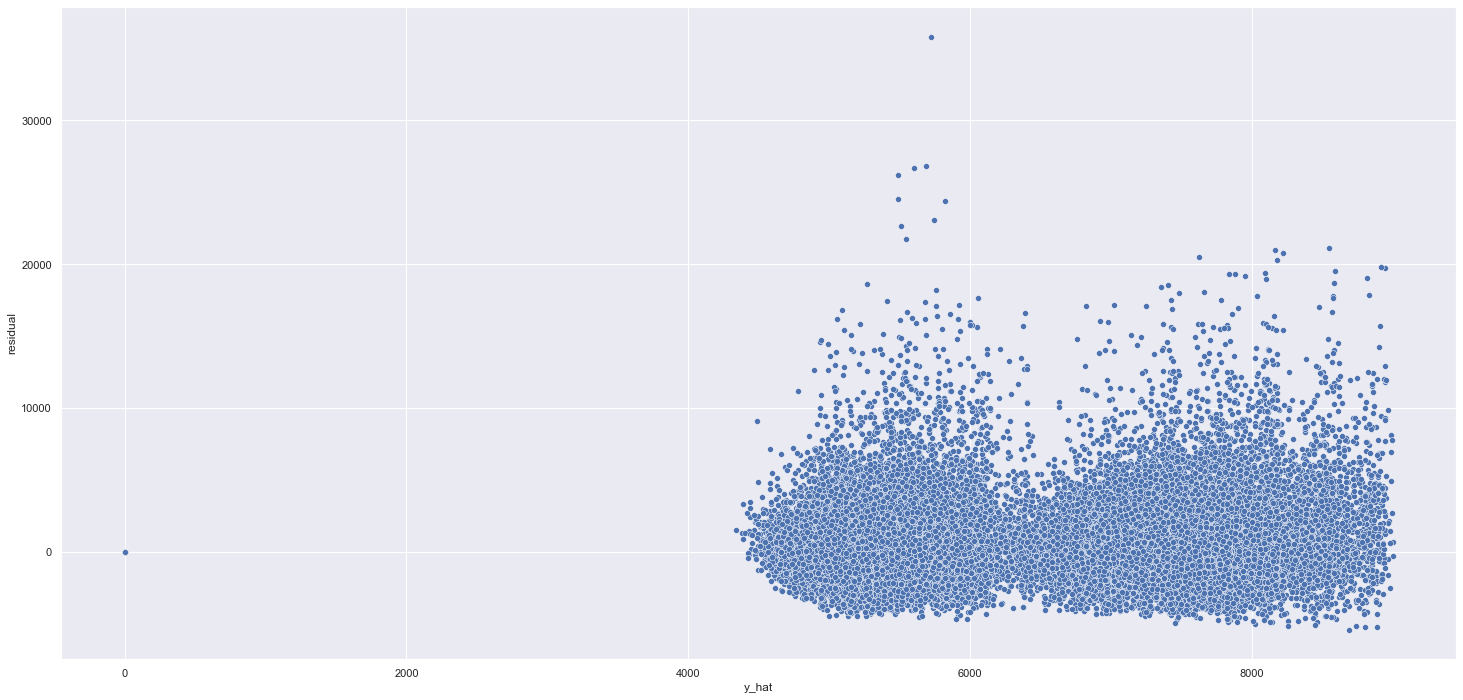

In [51]:
res_plot(y_test, yhat_lr);

### 7.2.1. LINEAR REGRESSION MODEL - CROSS VALIDATION

In [182]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

Model Name           MAE CV      MAPE CV           RMSE CV        R2 CV
0  Linear Regression  1736.44+/-249.7  0.25+/-0.01  2765.89+/-453.39  0.53+/-0.05

## 7.3 LINEAR REGRESSION REGULARIZED MODEL - LASSO

In [183]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

Model Name      MAE  MAPE    RMSE      R2
0  Linear Regression - Lasso  1672.87  0.26  2631.3  0.4972

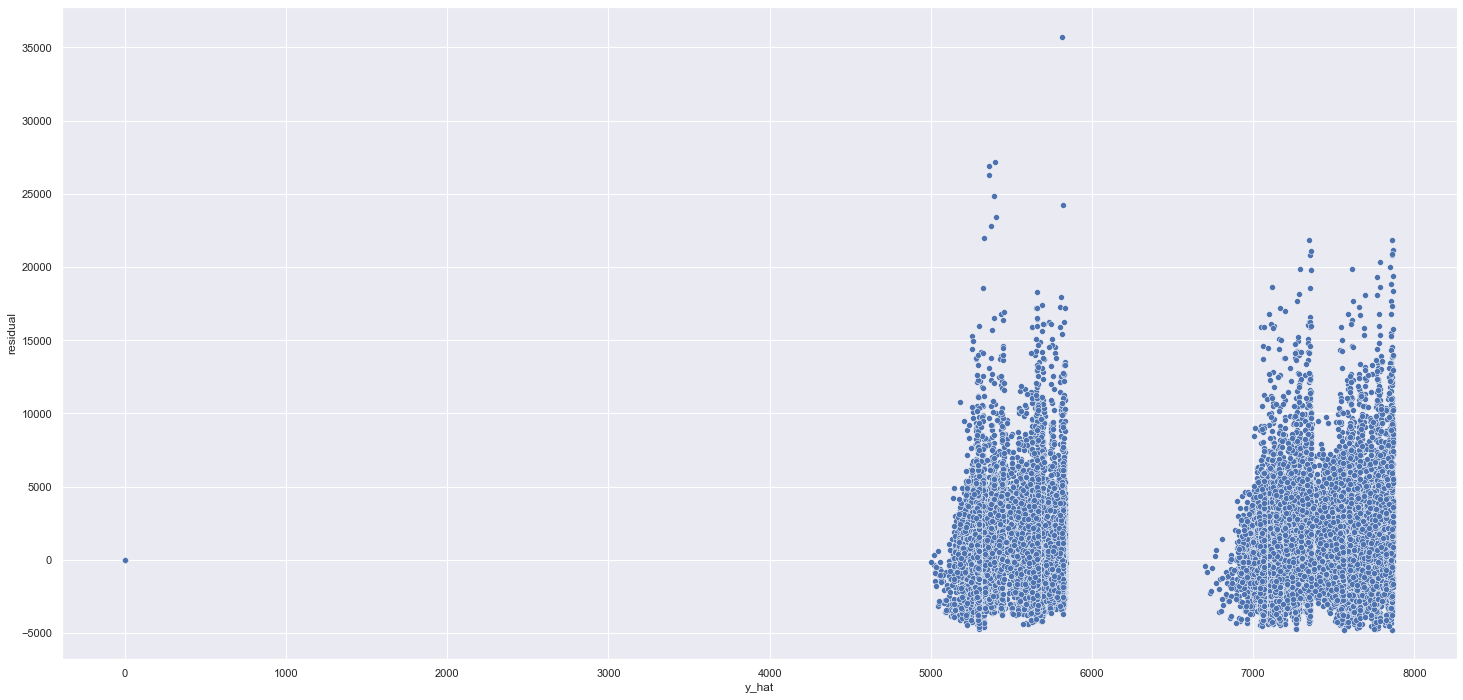

In [54]:
res_plot(y_test, yhat_lrr);

### 7.3.1. LINEAR REGRESSION REGULARIZED MODEL - LASSO - CROSS VALIDATION

In [184]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', lrr)
lrr_result_cv

Model Name           MAE CV      MAPE CV           RMSE CV        R2 CV
0  Linear Regression - Lasso  1767.8+/-268.63  0.26+/-0.01  2826.91+/-472.29  0.51+/-0.06

## 7.4. RANDOM FOREST REGRESSOR

In [185]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

Model Name     MAE  MAPE     RMSE      R2
0  Random Forest Regressor  656.22   0.1  1039.01  0.9216

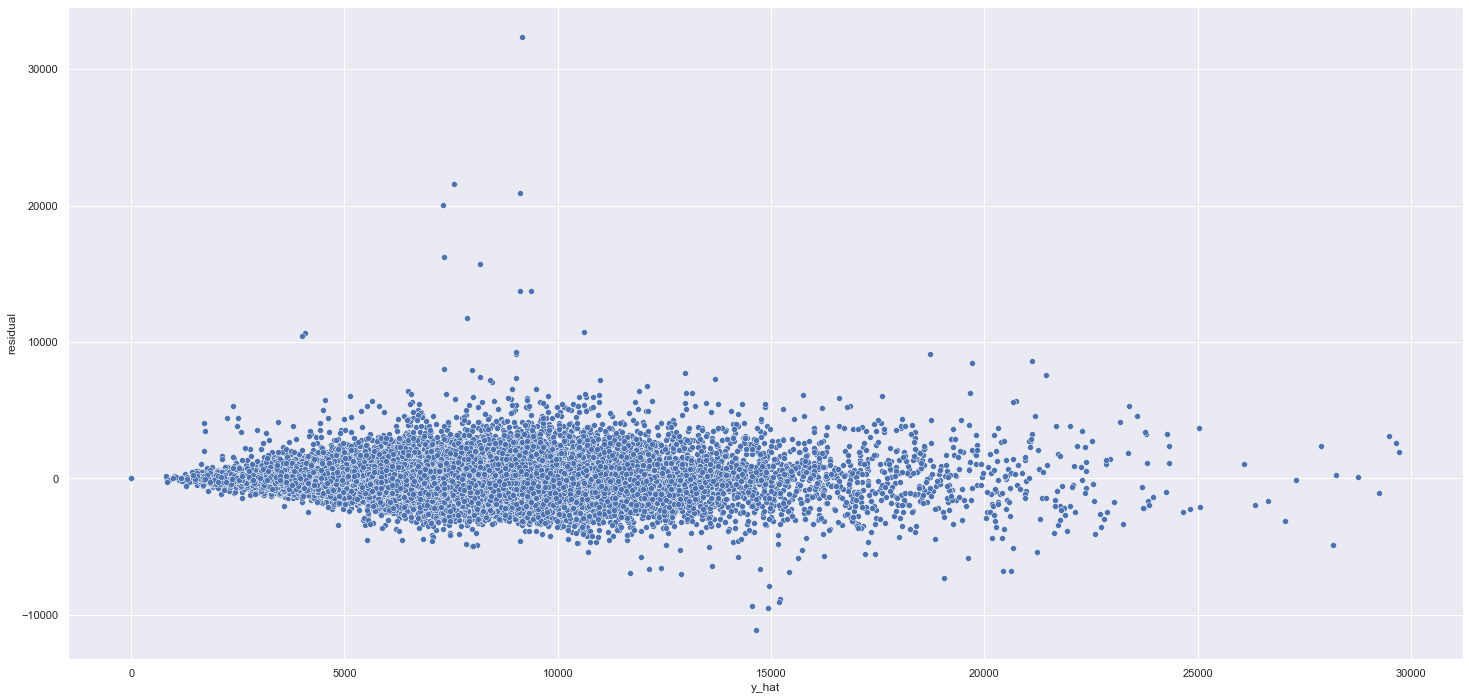

In [187]:
res_plot(y_test, yhat_rf);

### 7.4.1. RANDOM FOREST REGRESSOR - CROSS VALIDATION

In [188]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, True)
rf_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


Model Name           MAE CV     MAPE CV           RMSE CV        R2 CV
0  Random Forest Regressor  748.78+/-204.82  0.1+/-0.02  1240.71+/-342.58  0.91+/-0.03

## 7.5. XGBOOST REGRESSOR

###### MODEL

In [189]:
#model
model_xgb = xgb.XGBRegressor(
                            objective='reg:squarederror',
                            eval_metric='rmse'
                            ).fit(x_train, y_train, verbose=True)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

Model Name     MAE  MAPE     RMSE      R2
0  XGBoost Regressor  848.37  0.13  1328.14  0.8719

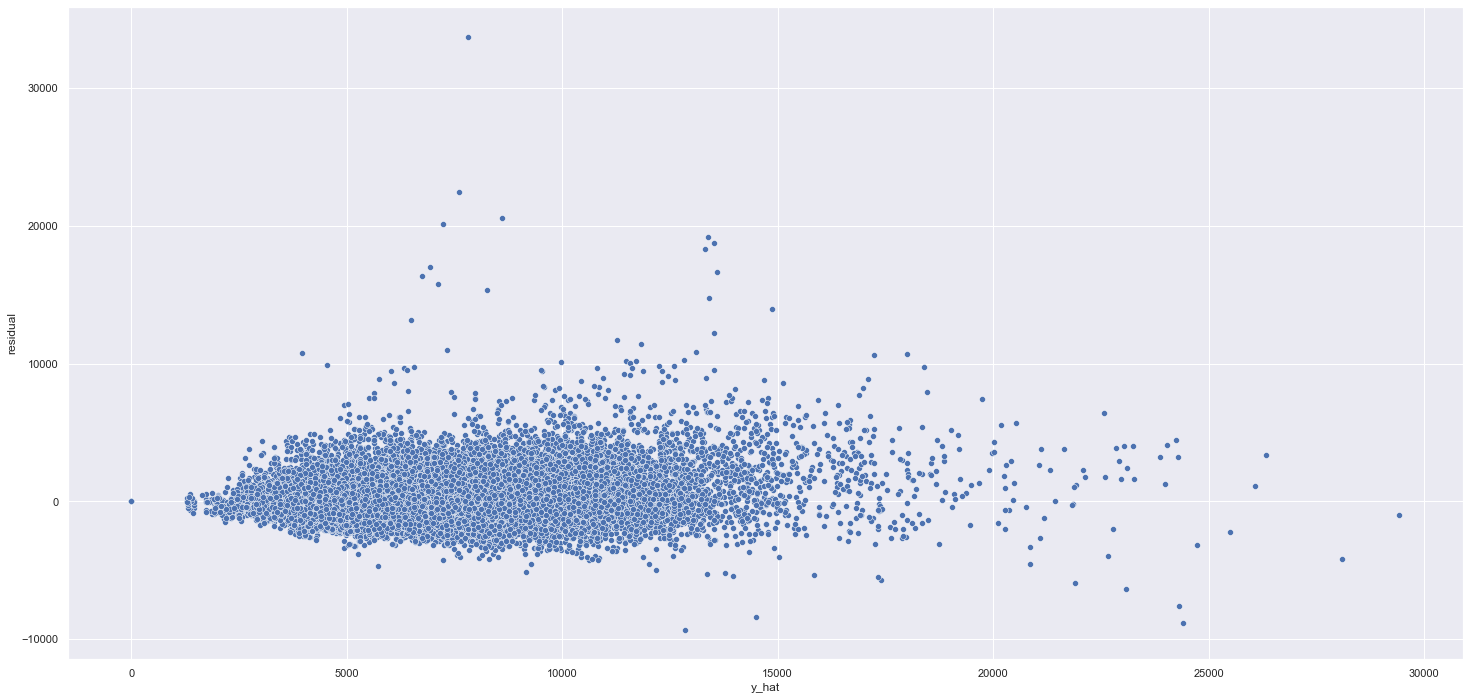

In [190]:
res_plot(y_test, yhat_xgb);

### 7.5.1. XGBOOST REGRESSOR - CROSS VALIDATION

In [191]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, True)
xgb_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


Model Name           MAE CV      MAPE CV          RMSE CV        R2 CV
0  XGBoost Regressor  934.85+/-150.31  0.14+/-0.02  1495.9+/-253.37  0.86+/-0.01

## 7.6 COMPARE MODEL´S PERFORMANCE

### 7.6.1 SINGLE PERFORMANCE

In [192]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

Model Name      MAE  MAPE     RMSE      R2
0    Random Forest Regressor   656.22  0.10  1039.01  0.9216
0          XGBoost Regressor   848.37  0.13  1328.14  0.8719
0              Average Model  1169.74  0.21  1705.20  0.7889
0          Linear Regression  1643.00  0.25  2579.16  0.5170
0  Linear Regression - Lasso  1672.87  0.26  2631.30  0.4972

### 7.6.2 REAL PERFORMANCE - CROSS VALIDATION

In [193]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

Model Name           MAE CV      MAPE CV           RMSE CV        R2 CV
0    Random Forest Regressor  748.78+/-204.82   0.1+/-0.02  1240.71+/-342.58  0.91+/-0.03
0          XGBoost Regressor  934.85+/-150.31  0.14+/-0.02   1495.9+/-253.37  0.86+/-0.01
0          Linear Regression  1736.44+/-249.7  0.25+/-0.01  2765.89+/-453.39  0.53+/-0.05
0  Linear Regression - Lasso  1767.8+/-268.63  0.26+/-0.01  2826.91+/-472.29  0.51+/-0.06

# 8.0 HYPERPARAMETER FINE TUNNING

## 8.1. RANDOM SEARCH

In [18]:
param = {
         'n_estimators': [1, 100, 1000, 2000],
         'eta': [0.1, 0.2, 0.3], 
         'max_depth': [5, 7],
         'subsample': [0.7, 1], 
         'colsample_bytree': [1],
         'min_child_weight':[1]
        }

In [19]:
prev_result = pd.DataFrame()
model_info = pd.DataFrame()

for i in range(len(param['n_estimators'])):
    for j in range(len(param['eta'])):
        for n in range(len(param['max_depth'])):
            for m in range(len(param['subsample'])):
                for o in range(len(param['colsample_bytree'])):
                    for p in range(len(param['min_child_weight'])):
                        model_info = pd.DataFrame({'n_estimators': list(param.values())[0][i],
                                                   'eta' : list(param.values())[1][j],
                                                   'max_depth' : list(param.values())[2][n],
                                                   'subsample': list(param.values())[3][m],
                                                   'colsample_bytree': list(param.values())[4][o],
                                                   'min_child_weight': list(param.values())[5][p],
                                                   }, index=[0])
                        
                        print(model_info)
                        
                        #model
                        model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                                     eval_metric='rmse',
                                                     n_estimators=list(param.values())[0][i],
                                                     eta=list(param.values())[1][j],
                                                     max_depth=list(param.values())[2][n],
                                                     subsample=list(param.values())[3][m],
                                                     colsample_bytree= list(param.values())[4][o],
                                                     min_child_weight=list(param.values())[5][p],                                                                           
                                                     ).fit(x_train, y_train)
                        
                        #prediction
                        yhat_train_xgb = model_xgb.predict(x_train)
                        yhat_xgb = model_xgb.predict(x_test)
                        
                        #performance
                        result = ml_error_(np.expm1(y_test), np.expm1(yhat_xgb), np.expm1(y_train), np.expm1(yhat_train_xgb))
                        result = pd.concat([model_info, result], axis=1)
                        prev_result = pd.concat([prev_result, result])

prev_result

   n_estimators  eta  max_depth  subsample  colsample_bytree  min_child_weight
0             1  0.1          5        0.7                 1                 1
   n_estimators  eta  max_depth  subsample  colsample_bytree  min_child_weight
0             1  0.1          5          1                 1                 1
   n_estimators  eta  max_depth  subsample  colsample_bytree  min_child_weight
0             1  0.1          7        0.7                 1                 1
   n_estimators  eta  max_depth  subsample  colsample_bytree  min_child_weight
0             1  0.1          7          1                 1                 1
   n_estimators  eta  max_depth  subsample  colsample_bytree  min_child_weight
0             1  0.2          5        0.7                 1                 1
   n_estimators  eta  max_depth  subsample  colsample_bytree  min_child_weight
0             1  0.2          5          1                 1                 1
   n_estimators  eta  max_depth  subsample  colsampl

n_estimators  eta  max_depth  subsample  colsample_bytree  min_child_weight  R2_TRAIN  R2_TEST  RMSE_TRAIN  RMSE_TEST
0             1  0.1          5        0.7                 1                 1   -2.2299  -2.6464     6930.09    7086.27
0             1  0.1          5        1.0                 1                 1   -2.2299  -2.6464     6930.09    7086.27
0             1  0.1          7        0.7                 1                 1   -2.2299  -2.6464     6930.09    7086.27
0             1  0.1          7        1.0                 1                 1   -2.2299  -2.6464     6930.09    7086.27
0             1  0.2          5        0.7                 1                 1   -2.2261  -2.6421     6926.02    7082.09
0             1  0.2          5        1.0                 1                 1   -2.2261  -2.6421     6926.02    7082.09
0             1  0.2          7        0.7                 1                 1   -2.2261  -2.6421     6926.01    7082.09
0             1  0.2          7        1.0                 1                 1   -2.2261  -2.6421     6926.01    7082.09
0             1  0.3          5        0.7                 1                 1   -2.2174  -2.6322     6916.68    7072.51
0             1  0.3          5        1.0                 1                 1   -2.2174  -2.6322     6916.67    7072.51
0             1  0.3          7        0.7                 1                 1   -2.2174  -2.6322     6916.63    7072.49
0             1  0.3          7        1.0                 1                 1   -2.2174  -2.6322     6916.62    7072.49
0           100  0.1          5        0.7                 1                 1    0.7004   0.6567     2110.47    2174.44
0           100  0.1          5        1.0                 1                 1    0.7003   0.6547     2110.87    2180.70
0           100  0.1          7        0.7                 1                 1    0.7910   0.7510     1762.87    1851.71
0           100  0.1          7        1.0                 1                 1    0.7831   0.7408     1795.85    1889.22
0           100  0.2          5        0.7                 1                 1    0.7965   0.7602     1739.64    1817.09
0           100  0.2          5        1.0                 1                 1    0.7985   0.7649     1730.75    1799.21
0           100  0.2          7        0.7                 1                 1    0.8897   0.8526     1280.68    1424.89
0           100  0.2          7        1.0                 1                 1    0.8896   0.8562     1281.43    1407.13
0           100  0.3          5        0.7                 1                 1    0.8479   0.8178     1504.05    1584.07
0           100  0.3          5        1.0                 1                 1    0.8474   0.8154     1506.11    1594.43
0           100  0.3          7        0.7                 1                 1    0.9295   0.8921     1023.58    1219.10
0           100  0.3          7        1.0                 1                 1    0.9278   0.8853     1035.90    1256.78
0          1000  0.1          5        0.7                 1                 1    0.9362   0.9018      973.82    1162.74
0          1000  0.1          5        1.0                 1                 1    0.9351   0.9019      982.25    1162.35
0          1000  0.1          7        0.7                 1                 1    0.9665   0.9278      705.31     997.21
0          1000  0.1          7        1.0                 1                 1    0.9651   0.9256      720.10    1012.04
0          1000  0.2          5        0.7                 1                 1    0.9549   0.9180      818.53    1062.52
0          1000  0.2          5        1.0                 1                 1    0.9542   0.9215      824.93    1039.94
0          1000  0.2          7        0.7                 1                 1    0.9749   0.9282      611.44     994.49
0          1000  0.2          7        1.0                 1                 1    0.9747   0.9300      612.82     981.49
0         

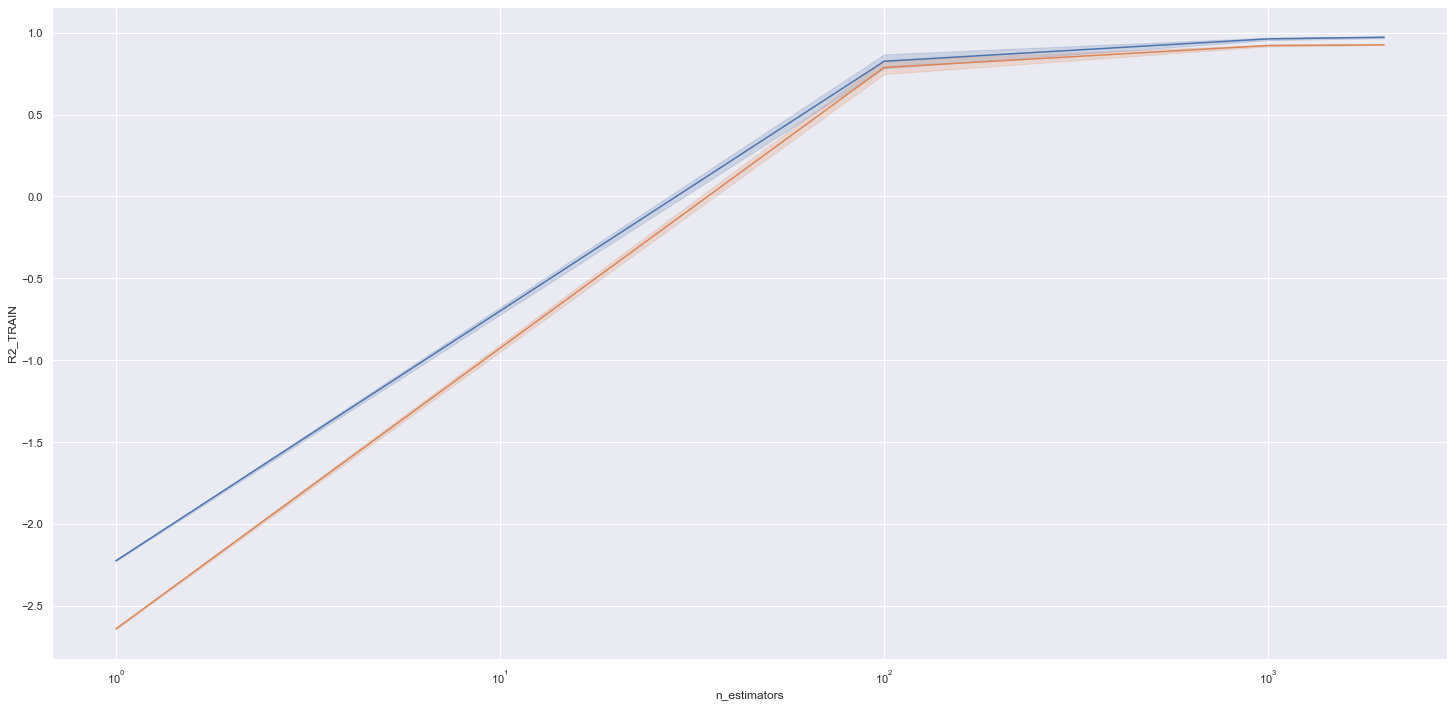

In [28]:
a = sns.lineplot(data=prev_result, x='n_estimators', y='R2_TRAIN')
a = sns.lineplot(data=prev_result, x='n_estimators', y='R2_TEST')
a.set(xscale='log');

In [21]:
#final_result = pd.DataFrame()
final_result = pd.concat([final_result, prev_result])
final_result

n_estimators  eta  max_depth  subsample  colsample_bytree  min_child_weight  R2_TRAIN  R2_TEST  RMSE_TRAIN  RMSE_TEST
0             1  0.1          5        0.7                 1                 1   -2.2299  -2.6464     6930.09    7086.27
0             1  0.1          5        1.0                 1                 1   -2.2299  -2.6464     6930.09    7086.27
0             1  0.1          7        0.7                 1                 1   -2.2299  -2.6464     6930.09    7086.27
0             1  0.1          7        1.0                 1                 1   -2.2299  -2.6464     6930.09    7086.27
0             1  0.2          5        0.7                 1                 1   -2.2261  -2.6421     6926.02    7082.09
0             1  0.2          5        1.0                 1                 1   -2.2261  -2.6421     6926.02    7082.09
0             1  0.2          7        0.7                 1                 1   -2.2261  -2.6421     6926.01    7082.09
0             1  0.2          7        1.0                 1                 1   -2.2261  -2.6421     6926.01    7082.09
0             1  0.3          5        0.7                 1                 1   -2.2174  -2.6322     6916.68    7072.51
0             1  0.3          5        1.0                 1                 1   -2.2174  -2.6322     6916.67    7072.51
0             1  0.3          7        0.7                 1                 1   -2.2174  -2.6322     6916.63    7072.49
0             1  0.3          7        1.0                 1                 1   -2.2174  -2.6322     6916.62    7072.49
0           100  0.1          5        0.7                 1                 1    0.7004   0.6567     2110.47    2174.44
0           100  0.1          5        1.0                 1                 1    0.7003   0.6547     2110.87    2180.70
0           100  0.1          7        0.7                 1                 1    0.7910   0.7510     1762.87    1851.71
0           100  0.1          7        1.0                 1                 1    0.7831   0.7408     1795.85    1889.22
0           100  0.2          5        0.7                 1                 1    0.7965   0.7602     1739.64    1817.09
0           100  0.2          5        1.0                 1                 1    0.7985   0.7649     1730.75    1799.21
0           100  0.2          7        0.7                 1                 1    0.8897   0.8526     1280.68    1424.89
0           100  0.2          7        1.0                 1                 1    0.8896   0.8562     1281.43    1407.13
0           100  0.3          5        0.7                 1                 1    0.8479   0.8178     1504.05    1584.07
0           100  0.3          5        1.0                 1                 1    0.8474   0.8154     1506.11    1594.43
0           100  0.3          7        0.7                 1                 1    0.9295   0.8921     1023.58    1219.10
0           100  0.3          7        1.0                 1                 1    0.9278   0.8853     1035.90    1256.78
0          1000  0.1          5        0.7                 1                 1    0.9362   0.9018      973.82    1162.74
0          1000  0.1          5        1.0                 1                 1    0.9351   0.9019      982.25    1162.35
0          1000  0.1          7        0.7                 1                 1    0.9665   0.9278      705.31     997.21
0          1000  0.1          7        1.0                 1                 1    0.9651   0.9256      720.10    1012.04
0          1000  0.2          5        0.7                 1                 1    0.9549   0.9180      818.53    1062.52
0          1000  0.2          5        1.0                 1                 1    0.9542   0.9215      824.93    1039.94
0          1000  0.2          7        0.7                 1                 1    0.9749   0.9282      611.44     994.49
0          1000  0.2          7        1.0                 1                 1    0.9747   0.9300      612.82     981.49
0         

In [22]:
#final_result = pd.read_csv('xgboost.csv')
final_result.sort_values('RMSE_TEST')
#final_result.to_csv('xgboost.csv', index=False)

n_estimators  eta  max_depth  subsample  colsample_bytree  min_child_weight  R2_TRAIN  R2_TEST  RMSE_TRAIN  RMSE_TEST
0          2000  0.1          7        0.7                 1                 1    0.9753   0.9306      606.43     977.85
0          2000  0.3          5        1.0                 1                 1    0.9708   0.9303      658.61     979.47
0          1000  0.2          7        1.0                 1                 1    0.9747   0.9300      612.82     981.49
0          2000  0.2          7        1.0                 1                 1    0.9808   0.9297      534.60     983.98
0          2000  0.2          5        1.0                 1                 1    0.9660   0.9287      710.93     990.84
0          2000  0.2          7        0.7                 1                 1    0.9807   0.9284      535.70     993.15
0          1000  0.2          7        0.7                 1                 1    0.9749   0.9282      611.44     994.49
0          1000  0.1          7        0.7                 1                 1    0.9665   0.9278      705.31     997.21
0          1000  0.3          5        1.0                 1                 1    0.9624   0.9275      747.81     999.03
0          2000  0.1          7        1.0                 1                 1    0.9743   0.9270      618.27    1002.31
0          2000  0.3          5        0.7                 1                 1    0.9700   0.9267      667.50    1004.55
0          1000  0.1          7        1.0                 1                 1    0.9651   0.9256      720.10    1012.04
0          1000  0.3          7        0.7                 1                 1    0.9777   0.9250      575.40    1016.35
0          2000  0.2          5        0.7                 1                 1    0.9660   0.9247      711.12    1018.52
0          2000  0.3          7        0.7                 1                 1    0.9829   0.9236      503.94    1025.66
0          1000  0.3          5        0.7                 1                 1    0.9618   0.9234      753.40    1026.83
0          1000  0.3          7        1.0                 1                 1    0.9779   0.9233      572.93    1028.06
0          2000  0.3          7        1.0                 1                 1    0.9834   0.9224      497.39    1033.96
0          1000  0.2          5        1.0                 1                 1    0.9542   0.9215      824.93    1039.94
0          2000  0.1          5        0.7                 1                 1    0.9554   0.9181      814.01    1061.84
0          1000  0.2          5        0.7                 1                 1    0.9549   0.9180      818.53    1062.52
0          2000  0.1          5        1.0                 1                 1    0.9536   0.9171      830.42    1068.41
0          1000  0.1          5        1.0                 1                 1    0.9351   0.9019      982.25    1162.35
0          1000  0.1          5        0.7                 1                 1    0.9362   0.9018      973.82    1162.74
0           100  0.3          7        0.7                 1                 1    0.9295   0.8921     1023.58    1219.10
0           100  0.3          7        1.0                 1                 1    0.9278   0.8853     1035.90    1256.78
0           100  0.2          7        1.0                 1                 1    0.8896   0.8562     1281.43    1407.13
0           100  0.2          7        0.7                 1                 1    0.8897   0.8526     1280.68    1424.89
0           100  0.3          5        0.7                 1                 1    0.8479   0.8178     1504.05    1584.07
0           100  0.3          5        1.0                 1                 1    0.8474   0.8154     1506.11    1594.43
0           100  0.2          5        1.0                 1                 1    0.7985   0.7649     1730.75    1799.21
0           100  0.2          5        0.7                 1                 1    0.7965   0.7602     1739.64    1817.09
0         

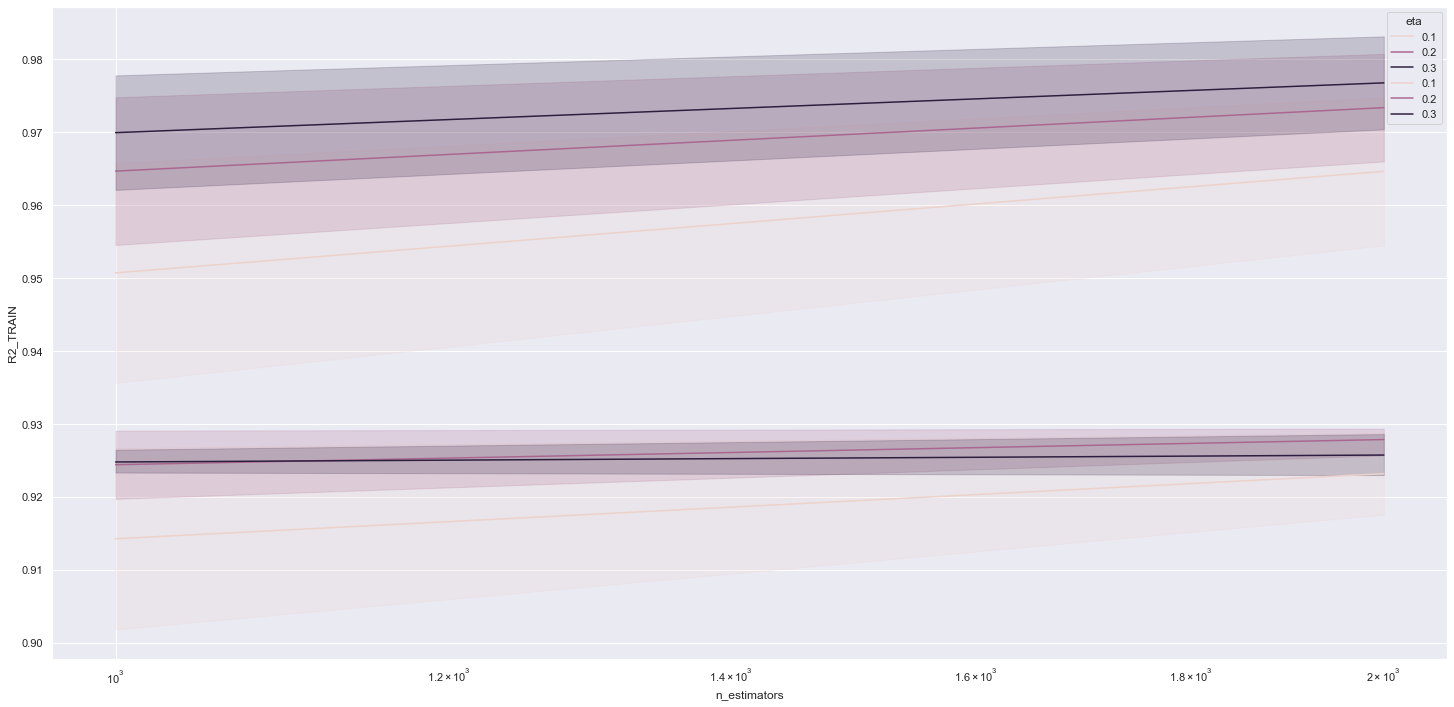

In [29]:
aux = final_result[final_result['n_estimators'] >= 1000]
a = sns.lineplot(data=aux, x='n_estimators', y='R2_TRAIN', hue='eta')
a = sns.lineplot(data=aux, x='n_estimators', y='R2_TEST', hue='eta')
a.set(xscale='log');

## 8.2 FINAL MODEL

In [30]:
param_tuned = {'n_estimators': 2000,
               'eta': 0.1,
               'max_depth': 7,
               'subsample': 0.7,
               'colsample_bytree': 1,
               'min_child_weight': 1
           }

In [31]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight']                                                                               
                                    ).fit(x_train, y_train)
        
#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned


Model Name     MAE  MAPE    RMSE      R2
0  XGBoost Regressor  624.77  0.09  977.85  0.9306

In [32]:
#pickle.dump(model_xgb_tuned, open('model_rossmann_c03.pkl', 'wb'))

In [33]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

nan

## 8.3 RELOAD MODEL

In [11]:
model_xgb_tuned = pickle.load(open('model_rossmann_c03.pkl', 'rb'))
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [34]:
df9 = X_test[cols_selected_boruta_full].copy()

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. BUSINESS PERFORMANCE

In [38]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'].values, x['predictions'].values)).reset_index().rename(columns={0:'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df92.head()

store    predictions  worst_scenario  best_scenario         MAE      MAPE
0      1  160663.843750   160383.740253  160943.947247  280.103497  0.066382
1      2  174817.046875   174469.826320  175164.267430  347.220555  0.073800
2      3  269521.281250   268951.312337  270091.250163  569.968913  0.084744
3      4  339153.625000   338364.418680  339942.831320  789.206320  0.079261
4      5  180400.171875   179964.319635  180836.024115  435.852240  0.101027

In [39]:
df92.sort_values('MAPE', ascending=False).head()

store    predictions  worst_scenario  best_scenario          MAE      MAPE
908    909  232244.890625   227953.923553  236535.857697  4290.967072  0.310064
840    841  126840.421875   126045.401370  127635.442380   795.020505  0.289040
291    292  102803.500000   101343.405055  104263.594945  1460.094945  0.260964
261    262  681477.875000   676134.662654  686821.087346  5343.212346  0.246470
273    274  196578.703125   195251.858756  197905.547494  1326.844369  0.227253

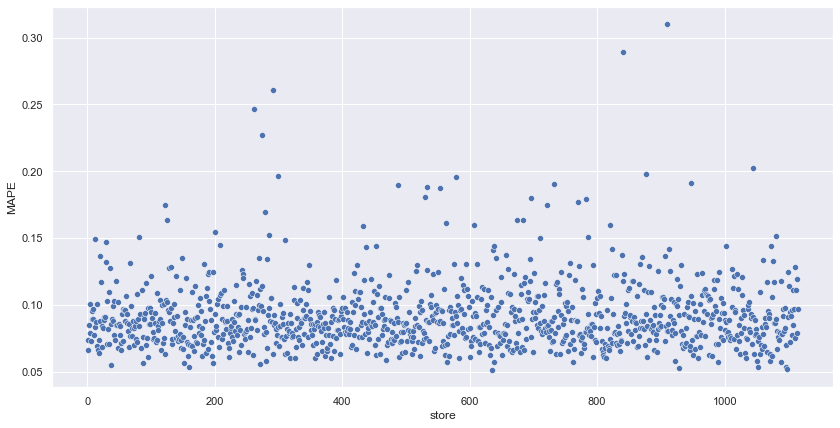

In [40]:
plt.figure(figsize=(14, 7))
sns.scatterplot(x='store', y='MAPE', data=df92)
plt.show()

## 9.2. TOTAL PERFORMANCE

In [41]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

Scenarios            Values
0     predictions  R$279,437,888.00
1  worst_scenario  R$278,741,290.63
2   best_scenario  R$280,134,523.34

## 9.3. MACHINE LEARNING PERFORMANCE

In [60]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9.apply(lambda x: 1 if x['sales'] == 0 else x['predictions'] / x['sales'], axis=1)

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

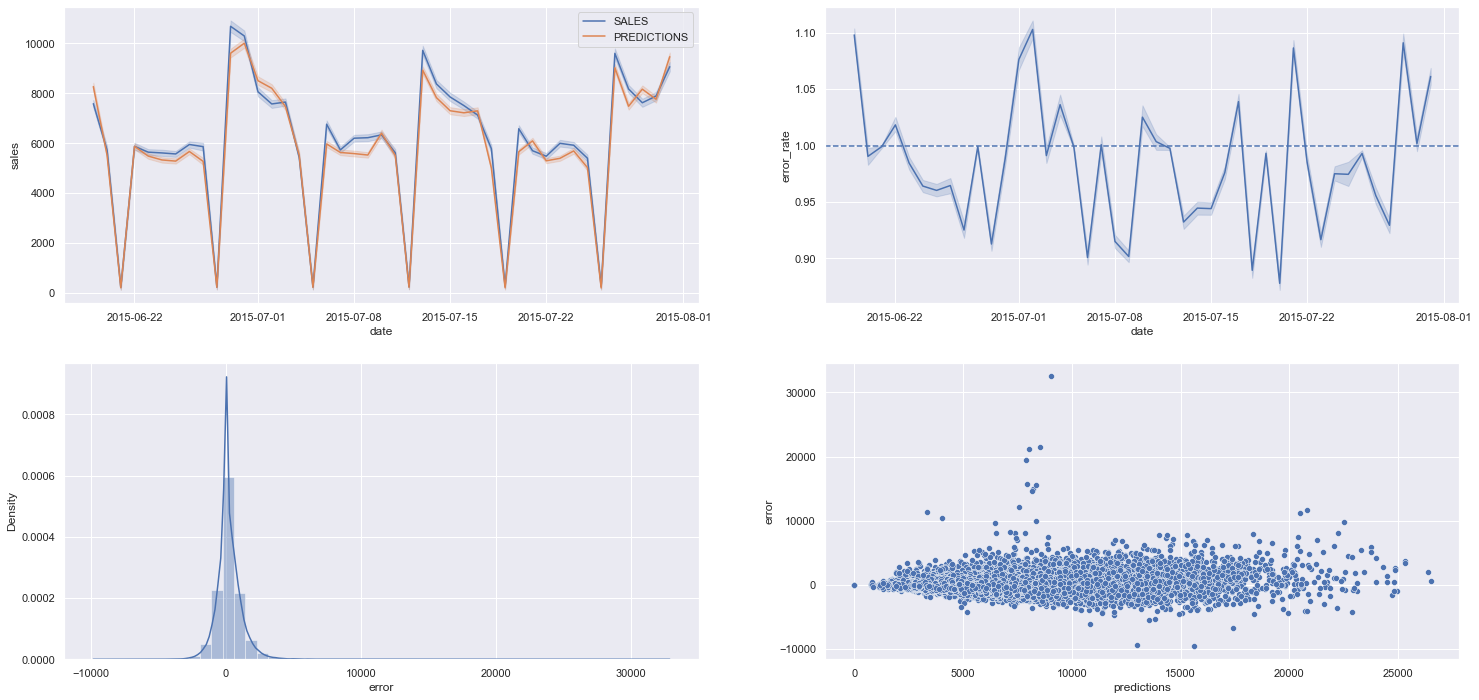

In [61]:
#plt.figure(figsize=(14, 7))
fig, axes = plt.subplots(2, 2)

sns.lineplot(x='date', y='sales', data=df9, label='SALES', ax=axes[0][0])
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS', ax=axes[0][0])

g = sns.lineplot(x='date', y='error_rate', data=df9, ax=axes[0][1])
g.axhline(1, linestyle='--')

sns.distplot(df9['error'], ax=axes[1][0])

sns.scatterplot(df9['predictions'], df9['error'], ax=axes[1][1])

## 9.4 VERIFIFY ERRORS

In [124]:
dfv1 = df9.copy()

In [128]:
dfv1.columns

Index(['store', 'store_type', 'assortment', 'store_cat',
       'competition_time_days', 'competition_distance', 'promo',
       'promo2_time_days', 'date', 'sales', 'predictions', 'error',
       'error_rate', 'year', 'month', 'day', 'day_of_week', 'week_of_year'],
      dtype='object')

In [125]:
# tranforming back
home_path = 'C:/Users/kaotc/Documents/repos/rossmann_ds/'
competition_distance_scaler = pickle.load(open(home_path + 'parameter/C02/competition_distance_scaler.pkl', 'rb'))
competition_time_days_scaler = pickle.load(open(home_path + 'parameter/C02/competition_time_days_scaler.pkl', 'rb'))
promo2_time_days_scaler = pickle.load(open(home_path + 'parameter/C02/promo2_time_days_scaler.pkl', 'rb'))
store_type_scaler = pickle.load(open(home_path + 'parameter/C02/store_type_scaler.pkl', 'rb'))
store_cat_scaler = pickle.load(open(home_path + 'parameter/C02/store_cat_scaler.pkl', 'rb'))
state_holiday_scaler = pickle.load(open(home_path + 'parameter/C02/state_holiday_scaler.pkl', 'rb'))

dfv1['competition_distance'] = competition_distance_scaler.inverse_transform(dfv1[['competition_distance']].values)
dfv1['competition_time_days'] = competition_time_days_scaler.inverse_transform(dfv1[['competition_time_days']].values)
dfv1['promo2_time_days'] = promo2_time_days_scaler.inverse_transform(dfv1[['promo2_time_days']].values)
dfv1['store_type'] = store_type_scaler.inverse_transform(dfv1[['store_type']].values)
dfv1['store_cat'] = store_cat_scaler.inverse_transform(dfv1[['store_cat']].values)

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [126]:
dfv1 = dfv1.drop(['day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos'], axis=1)

# year
dfv1['year'] = dfv1['date'].dt.year
# month
dfv1['month'] = dfv1['date'].dt.month
# day
dfv1['day'] = dfv1['date'].dt.day
# day
dfv1['day_of_week'] = dfv1['date'].dt.dayofweek
# week of year
dfv1['week_of_year'] = dfv1['date'].dt.isocalendar().week
dfv1['week_of_year2'] = dfv1['date'].dt.isocalendar().year
dfv1['week_of_year'] = dfv1.apply(lambda x: str(x['week_of_year2']) + '/0' + str(x['week_of_year']) if x['week_of_year'] < 10 else str(x['week_of_year2']) + '/' + str(x['week_of_year']), axis=1)
dfv1 = dfv1.drop(['week_of_year2'], axis=1)

In [129]:
arranged = ['date', 'store', 'sales', 'predictions', 'error','store_type', 'error_rate', 'assortment', 'store_cat',
            'competition_time_days', 'competition_distance', 'promo',
            'promo2_time_days', 'day_of_week', 'year', 'month', 'day', 'week_of_year']
dfv1 = dfv1[arranged]

In [135]:
dfv1[dfv1['day_of_week']==6].head()

date  store    sales   predictions        error store_type  error_rate  assortment   store_cat  competition_time_days  competition_distance  promo  promo2_time_days  day_of_week  year  month  day week_of_year
5565 2015-07-26     85  11421.0  10451.252930   969.747070          b    0.915091           1     b-basic                 1394.0                1870.0      0        508.000000            6  2015      7   26      2015/30
5566 2015-07-26    122   5773.0   1835.943237  3937.056763          a    0.318022           3  a-extended                  846.0               58260.0      0        508.000000            6  2015      7   26      2015/30
5567 2015-07-26    209   3742.0   1817.522705  1924.477295          a    0.485709           3  a-extended                 1424.0               11680.0      0       1246.261048            6  2015      7   26      2015/30
5568 2015-07-26    259  15998.0  12708.787109  3289.212891          b    0.794398           2     b-extra                   25.0                 210.0      0        508.000000            6  2015      7   26      2015/30
5569 2015-07-26    262  32547.0  26274.958984  6272.041016          b    0.807293           1     b-basic                  816.0                1180.0      0        508.000000            6  2015      7   26      2015/30

In [134]:
dfv1.dtypes

date                     datetime64[ns]
store                             int64
sales                           float64
predictions                     float32
error                           float64
store_type                       object
error_rate                      float64
assortment                        int64
store_cat                        object
competition_time_days           float64
competition_distance            float64
promo                             int64
promo2_time_days                float64
day_of_week                       int64
year                              int64
month                             int64
day                               int64
week_of_year                     object
dtype: object

## 9.4 KAGGLE SUBMISSION

### 9.4.1. FUNCTIONS

In [16]:
def data_description(df1):
    # storing columns names
    cols_old = list(df1.columns)
    
    # transforming to underscore the names and put into lowcase
    snakecase = lambda x: inflection.underscore( x )
    
    # creating a list with a new snakecase columns name and indicating the new one
    cols_new = list( map( snakecase, cols_old ) )
    
    #renaming columns name
    df1.columns = cols_new
    
    df1['date'] = pd.to_datetime(df1['date'])
    
    # competition_distance
    df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 5430.0 if math.isnan(x) else x)
    
    aux1 = df1['date'][0]

    # competition_open_since_month
    df1['competition_open_since_month'] = df1.apply(lambda x: aux1.month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
    
    # competition_open_since_year
    df1['competition_open_since_year'] = df1.apply(lambda x: aux1.year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
    
    df1['promo2_since_week'] = df1.apply(lambda x: 0 if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

    # promo2_since_year
    df1['promo2_since_year'] = df1.apply(lambda x: 0 if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
    
    # promo_interval
    df1['promo_interval'].fillna(0, inplace=True)
    
    df1['day_of_week'] = df1['day_of_week'].astype('str')
    df1['open'] = df1['open'].astype('str')
    df1['promo'] = df1['promo'].astype('str')
    df1['state_holiday'] = df1['state_holiday'].astype('str')
    df1['school_holiday'] = df1['school_holiday'].astype('str')
    df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
    df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('str')
    df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
    df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('str')
    df1['promo2'] = df1['promo2'].astype('str')
    df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
    df1['promo2_since_week'] = df1['promo2_since_week'].astype('str')
    df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
    df1['promo2_since_year'] = df1['promo2_since_year'].astype('str')
    return df1

In [17]:
def feature_engineering(df2):
    # year week
    df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
    
    # promo since
    df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
    df2['promo2_since'] = df2['promo2_since'].apply(lambda x: (datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7)) if x != '0-0' else datetime.datetime(year=2015, month=7, day=31))
    df2['promo2_time_days'] = df2.apply(lambda x: 0 if (x['date'] < x['promo2_since']) else (x['date'] - x['promo2_since']), axis=1)
    df2['promo2_time_days'] = df2['promo2_time_days'].apply(lambda x: 0 if isinstance(x, int) else x.days).astype('int64')
    
    # assortment
    df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')
    
    # state holiday
    df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x=='a' else 'eastern_holiday' if x=='b' else 'christimas' if x=='c' else 'regular_day')
    # competition since
    df2['competition_open_since_month'] = df2['competition_open_since_month'].astype('int64')
    df2['competition_open_since_year'] = df2['competition_open_since_year'].astype('int64')
    df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
    df2['competition_time_days'] = df2.apply(lambda x: 0 if (x['date'] < x['competition_since']) else (x['date'] - x['competition_since']), axis=1)
    df2['competition_time_days'] = df2['competition_time_days'].apply( lambda x: 0 if isinstance(x, int) else x.days).astype('int64')
    
    month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    df2['month_map'] = df2['date'].dt.month.map(month_map)
    
    df2['promo2_on'] = df2[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
    
    df2['store_cat'] = df2['store_type'] + '-' + df2['assortment']
    
    # year
    df2['year'] = df2['date'].dt.year
    # month
    df2['month'] = df2['date'].dt.month
    # day
    df2['day'] = df2['date'].dt.day
    # week of year
    df2['week_of_year'] = df2['date'].dt.isocalendar().week
    df2['week_of_year2'] = df2['date'].dt.isocalendar().year
    df2['week_of_year'] = df2.apply(lambda x: str(x['week_of_year2']) + '/0' + str(x['week_of_year']) if x['week_of_year'] < 10 else str(x['week_of_year2']) + '/' + str(x['week_of_year']), axis=1)
    
    df2 = df2.drop(['competition_open_since_month', 'competition_open_since_year', 
                'promo2_since_week', 'promo2_since_year', 'promo_interval',
                'year_week', 'promo2_since', 'competition_since', 'month_map', 'week_of_year2'
               ], axis=1)
    return df2

In [61]:
def preparation(df5):
    home_path = 'C:/Users/kaotc/Documents/repos/rossmann_ds/'
    competition_distance_scaler = pickle.load(open(home_path + 'parameter/C02/competition_distance_scaler.pkl', 'rb'))
    competition_time_days_scaler = pickle.load(open(home_path + 'parameter/C02/competition_time_days_scaler.pkl', 'rb'))
    promo2_time_days_scaler = pickle.load(open(home_path + 'parameter/C02/promo2_time_days_scaler.pkl', 'rb'))
    store_type_scaler = pickle.load(open(home_path + 'parameter/C02/store_type_scaler.pkl', 'rb'))
    store_cat_scaler = pickle.load(open(home_path + 'parameter/C02/store_cat_scaler.pkl', 'rb'))
    state_holiday_scaler = pickle.load(open(home_path + 'parameter/C02/state_holiday_scaler.pkl', 'rb'))
    
    df5['date'] = pd.to_datetime(df5['date'])
    df5['school_holiday'] = df5['school_holiday'].astype('str')
    df5['day_of_week'] = df5['day_of_week'].astype('int64')
    df5['open'] = df5['open'].astype('float64')
    df5['promo'] = df5['promo'].astype('str')
    df5['promo2_on'] = df5['promo2_on'].astype('str')
    
    #df5 = df5[(df5['open']==1)]
    df5 = df5.drop('open', axis=1)
    
    df5['competition_distance'] = competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
    df5['competition_time_days'] = competition_time_days_scaler.fit_transform(df5[['competition_time_days']].values)
    df5['promo2_time_days'] = promo2_time_days_scaler.fit_transform(df5[['promo2_time_days']].values)
    
    assortment_dict = {'basic': 1, 'extra' : 2, 'extended' : 3}
    df5['assortment'] = df5['assortment'].map(assortment_dict)
    
    df5['store_type'] = store_type_scaler.fit_transform(df5[['store_type']].values)
    df5['store_cat'] = store_cat_scaler.fit_transform(df5[['store_cat']].values)
    df5['state_holiday'] = state_holiday_scaler.fit_transform(df5[['state_holiday']].values)
    
    #day of the week
    df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
    df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
    #month
    df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
    df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
    #day
    df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
    df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))
    #week of year
    df5['week_of_year'] = df5['week_of_year'].apply(lambda x: x.split('/')[1])
    df5['week_of_year'] = df5['week_of_year'].astype('int64')
    df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
    df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))
    return df5

In [55]:
def feature_selection(df6):
    cols_selected_boruta = ['store',
                            'store_type',
                            'assortment',
                            'store_cat',
                            'competition_time_days',
                            'competition_distance',
                            'promo',
                            'promo2_time_days',
                            'day_of_week_sin',
                            'day_of_week_cos',
                            'month_cos',
                            'day_sin',
                            'day_cos',
                            'week_of_year_cos']
    df6 = df6[cols_selected_boruta]
    return df6

### 9.4.2. KAGGLE TEST SET

In [139]:
df_test_kg = pd.read_csv('dataset/test.csv')
df_store_raw = pd.read_csv( 'dataset/store.csv', low_memory=False)

#merge - MAIN: SALES MERGING LEFT - Because all sales are related to a store.
df_test_raw = pd.merge( df_test_kg, df_store_raw, how='left', on='Store')

In [63]:
df1_kg = data_description(df_test_raw)
df2_kg = feature_engineering(df1_kg)
df5_kg = preparation(df2_kg)
df6_kg = feature_selection(df5_kg)
df6_kg.head()

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


store  store_type  assortment  store_cat  competition_time_days  competition_distance promo  promo2_time_days  day_of_week_sin  day_of_week_cos     month_cos   day_sin   day_cos  week_of_year_cos
0      1           2           1          5               0.679208             -0.206474     1         -0.341357        -0.433884        -0.900969 -1.836970e-16 -0.406737 -0.913545         -0.120537
1      3           0           1          0               0.932673              2.043745     1          0.806878        -0.433884        -0.900969 -1.836970e-16 -0.406737 -0.913545         -0.120537
2      7           0           3          1               0.016634              3.770779     1         -0.341357        -0.433884        -0.900969 -1.836970e-16 -0.406737 -0.913545         -0.120537
3      8           0           1          0              -0.200396              0.887139     1         -0.341357        -0.433884        -0.900969 -1.836970e-16 -0.406737 -0.913545         -0.120537
4      9           0           3          1               1.848713             -0.073491     1         -0.341357        -0.433884        -0.900969 -1.836970e-16 -0.406737 -0.913545         -0.120537

### 4.4.3. MACHINE LEARNING

In [58]:
model_xgb_tuned = pickle.load(open('model_rossmann_c02.pkl', 'rb'))

In [64]:
#prediction
yhat_xgb_tuned_kg = model_xgb_tuned.predict(df6_kg)

In [65]:
yhat_xgb_tuned_kg = np.expm1(yhat_xgb_tuned_kg)
yhat_xgb_tuned_kg.shape

(41088,)

### 4.4.4. SUBMITTION

In [66]:
submission = pd.read_csv('dataset/sample_submission.csv')
submission['Sales'] = yhat_xgb_tuned_kg
submission.to_csv('dataset/submission01.csv', index=False)

In [67]:
submission.head()

Id        Sales
0   1  4584.753906
1   2  7376.702637
2   3  8248.839844
3   4  5894.759766
4   5  5822.422363

In [142]:
total_kg = pd.concat([df6_kg, submission['Sales'], df_test_kg['DayOfWeek'],df_test_kg['Open']], axis=1)

In [145]:
rearange = ['store', 'store_type', 'assortment', 'store_cat',
            'competition_time_days', 'competition_distance', 'promo',
            'promo2_time_days', 'Sales', 'DayOfWeek', 'Open']
total_kg = total_kg[rearange]
total_kg.head()

store  store_type  assortment  store_cat  competition_time_days  competition_distance promo  promo2_time_days        Sales  DayOfWeek  Open
0      1           2           1          5               0.679208             -0.206474     1         -0.341357  4584.753906          4   1.0
1      3           0           1          0               0.932673              2.043745     1          0.806878  7376.702637          4   1.0
2      7           0           3          1               0.016634              3.770779     1         -0.341357  8248.839844          4   1.0
3      8           0           1          0              -0.200396              0.887139     1         -0.341357  5894.759766          4   1.0
4      9           0           3          1               1.848713             -0.073491     1         -0.341357  5822.422363          4   1.0

In [146]:
total_kg[total_kg['Open'] == 0]

store  store_type  assortment  store_cat  competition_time_days  competition_distance promo  promo2_time_days         Sales  DayOfWeek  Open
543      703           0           1          0               1.149703             -0.414698     1         -0.341357   4351.358887          4   0.0
676      879           3           1          7              -0.333069              0.521435     1          0.320362   4619.790527          4   0.0
840     1097           1           2          4               1.620198             -0.302712     1         -0.341357  10164.501953          4   0.0
1399     703           0           1          0               1.149307             -0.414698     1         -0.342081   4277.454590          3   0.0
1532     879           3           1          7              -0.333465              0.521435     1          0.319638   4693.125977          3   0.0
1696    1097           1           2          4               1.619802             -0.302712     1         -0.342081  10091.725586          3   0.0
2255     703           0           1          0               1.148911             -0.414698     1         -0.342805   5099.229004          2   0.0
2388     879           3           1          7              -0.333861              0.521435     1          0.318914   5401.277344          2   0.0
2552    1097           1           2          4               1.619406             -0.302712     1         -0.342805  10860.536133          2   0.0
3111     703           0           1          0               1.148515             -0.414698     1         -0.343529   5402.601562          1   0.0
3244     879           3           1          7              -0.334257              0.521435     1          0.318190   6340.510742          1   0.0
3408    1097           1           2          4               1.619010             -0.302712     1         -0.343529  11004.269531          1   0.0
3424       1           2           1          5               0.677624             -0.206474     0         -0.344253   6093.263184          7   0.0
3425       3           0           1          0               0.931089              2.043745     0          0.803982   3070.245850          7   0.0
3426       7           0           3          1               0.015050              3.770779     0         -0.344253   3706.902588          7   0.0
3427       8           0           1          0              -0.201980              0.887139     0         -0.344253   2740.577637          7   0.0
3428       9           0           3          1               1.847129             -0.073491     0         -0.344253   5437.187012          7   0.0
3429      10           0           1          0               0.533069              0.124234     0         -0.344253   3038.862305          7   0.0
3430      11           0           3          1               0.219802             -0.260717     0          0.606335   3782.260010          7   0.0
3431      12           0           3          1              -0.334653             -0.241470     0          1.072579   5065.115723          7   0.0
3432      13           3           1          7              -0.334653             -0.374453     0          1.173937   4868.448730          7   0.0
3433      14           0           1          0              -0.117228             -0.201225     0          0.672217   3645.718262          7   0.0
3434      15           3           3          8               0.461386              0.290464     0          0.803982   5176.147949          7   0.0
3435      16           0           3          1              -0.334653              0.143482     0         -0.344253   3858.629639          7   0.0
3436      19           0           3          1              -0.334653              0.138233     0          0.763439   4229.335449          7   0.0
3437      20           3           1          7               0.581782             -0.019248     0         -0.123439   5398.176758          7   0.0
3438      2

# 10.0 DEPLOY MODEL TO PRODUCTION

## 10.1. ROSSMAN CLASS

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        #state = 1
        self.home_path = 'C:/Users/kaotc/Documents/repos/sales_prediction/'
        self.competititon_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competititon_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        
        ## 1.1 Rename Colums

        cols_old = ['Store', 'DayOfWeek', 'Date',
                    #'Sales', 'Customers',
                    'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )
        
        cols_new = list( map( snakecase, cols_old ) )

        #rename
        df1.columns = cols_new

        ## 1.3 Data Types

        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5 Fillout NA

        df1['competition_distance'].max()

        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6 Change Types

        df1.dtypes
        
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    def feature_engineering(self,df2):

        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype('int64')

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype('int64')

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x=='a' else 'eastern_holiday' if x=='b' else 'christimas' if x=='c' else 'regular_day')
        
        ## 3.1. Filtragem das linhas
        
        df2 = df2[(df2['open'] != 0)]

        # 3.2. Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2

    def data_preparation(self, df5):
        ## 5.2. RESCALLING

        #competition distance
        df5['competition_distance'] = self.competititon_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        #competition time month
        df5['competition_time_month'] = self.competititon_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3. TRANSFORMAÇÃO

        ### 5.3.1 ENCODING

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])


        #assortment - Oridinal Encoding
        assortment_dict = {'basic': 1, 'extra' : 2, 'extended' : 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.2. NATURE TRANSFORMATION

        #day of the week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))
        #week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))
        
        cols_selected = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']
        
        return df5[cols_selected]
                  
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API HANDLER

In [ ]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('C:/Users/kaotc/Documents/repos/sales_prediction/model_rossmann.pkl', 'rb'))

#initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): #Unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: #Multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instaciate Rossmann Class
        pipeline = Rossmann()
        
        # Data Cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)
        
        # Data Preparation
        df3 = pipeline.data_preparation(df2)
        
        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')
    

if __name__ == '__main__':
    app.run( host = "192.168.15.77", port= 5000, debug=True)

## 10.3 API TESTER

In [3]:
import requests

In [4]:
# loading test dataset
df10 = pd.read_csv('dataset/test.csv')

In [5]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24, 12, 22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()] #~ não pega os campos vazios
df_test = df_test.drop('Id', axis=1)

In [6]:
# convert DataFrame to json
data = json.dumps(df_test.to_dict(orient='records'))
data

'[{"Store": 12, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "c", "CompetitionDistance": 1070.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 13.0, "Promo2SinceYear": 2010.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 24, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "c", "CompetitionDistance": 4590.0, "CompetitionOpenSinceMonth": 3.0, "CompetitionOpenSinceYear": 2000.0, "Promo2": 1, "Promo2SinceWeek": 

In [7]:
# API Call
#url = 'https://geordano-model.herokuapp.com/rossmann/predict'
url = 'https://rosmann-model-test.herokuapp.com/rossmann/predict'
#url = 'http://192.168.15.77:5000/rossmann/predict'
#url = 'http://192.168.15.6:5000/rossmann/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [8]:
# DEPOIS DE RODAR O API CALL
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [9]:
d1.head()

store  day_of_week                      date  open  promo state_holiday  \
0     12            4  2015-09-17T00:00:00.000Z   1.0      1   regular_day   
1     22            4  2015-09-17T00:00:00.000Z   1.0      1   regular_day   
2     24            4  2015-09-17T00:00:00.000Z   1.0      1   regular_day   
3     12            3  2015-09-16T00:00:00.000Z   1.0      1   regular_day   
4     22            3  2015-09-16T00:00:00.000Z   1.0      1   regular_day   

   school_holiday store_type assortment  competition_distance  ...  year  \
0               0          a   extended                1070.0  ...  2015   
1               0          a      basic                1040.0  ...  2015   
2               0          a   extended                4590.0  ...  2015   
3               0          a   extended                1070.0  ...  2015   
4               0          a      basic                1040.0  ...  2015   

   month  day  week_of_year  year_week         competition_since  \
0      9   17            38    2015-37  2015-09-01T00:00:00.000Z   
1      9   17            38    2015-37  2015-09-01T00:00:00.000Z   
2      9   17            38    2015-37  2000-03-01T00:00:00.000Z   
3      9   16            38    2015-37  2015-09-01T00:00:00.000Z   
4      9   16            38    2015-37  2015-09-01T00:00:00.000Z   

  competition_time_month               promo_since  promo_time_week  \
0                      0  2010-03-22T00:00:00.000Z              286   
1                      0  2012-05-21T00:00:00.000Z              173   
2                    189  2011-09-26T00:00:00.000Z              207   
3                      0  2010-03-22T00:00:00.000Z              286   
4                      0  2012-05-21T00:00:00.000Z              173   

    prediction  
0  6868.093262  
1  4234.729004  
2  7839.891113  
3  6988.126465  
4  4299.241699  

[5 rows x 28 columns]

In [10]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range (len(d2)):
    print('Store Number {} will sell R$ {:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store Number 12 will sell R$ 258,738.96 in the next 6 weeks
Store Number 22 will sell R$ 155,993.56 in the next 6 weeks
Store Number 24 will sell R$ 291,482.27 in the next 6 weeks
